#**Introduction**

This assignment investigates the relationship between online search behaviour and stock market performance.  Specifically, it aims to determine if Google search trends for selected keywords can act as leading or lagging indicators for the daily closing prices of a chosen company on the Johannesburg Stock Exchange (JSE). The analysis will involve statistical techniques and machine learning models to test the hypothesis that search data can predict stock price movements.

**Objective:**
To investigate whether Google search trends can serve as leading or lagging
indicators for stock price movements on the Johannesburg Stock Exchange (JSE)
using time series and machine learning models.

## **Dependencies**

### **Installing Libraries**

In [ ]:
!pip install pandas skimpy numpy yfinance matplotlib seaborn statsmodels xgboost

In [ ]:
!pip install pytrends

### **Importing dependencies**

In this section, we imported the necessary libraries that enable us to conduct both the statistical and predictive modelling required by the assignment. The project must demonstrate time series analysis, statistical testing, and machine learning techniques. Each imported package contributes to this aim: for example, pandas structures and manages the data, while statsmodels and sklearn provide the statistical and machine learning tools needed for our lead–lag investigation. By carefully selecting these libraries, we ensure that our notebook remains consistent with the requirements and allows us to integrate different methods within a single analysis.

In [ ]:
from datetime import datetime, timedelta
import yfinance as yf
from pytrends.request import TrendReq
from pytrends.exceptions import TooManyRequestsError
import matplotlib.pyplot as plt
import skimpy
import pandas as pd
import seaborn as sns
import time # To handle request throttling

# For Statistical Analysis
from statsmodels.tsa.stattools import grangercausalitytests
import numpy as np

# For Machine Learning Models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from statsmodels.tsa.stattools import adfuller

By applying techniques such as cross-correlation and Granger causality tests, we directly address the assignment’s requirement to test for lead–lag relationships. These methods allow us to assess whether changes in Google search activity have predictive power for stock price movements, or whether they simply react to what has already happened in the market.

The academic literature often frames this as a test of investor attention. For reference, Da et al. (2011) and Ayala et al. (2024) argue that Google search volume reflects the active demand for information by investors. If searches lead prices, this would suggest that attention itself drives market activity; if they lag, it suggests that investors search for information only after observing price changes.

The assignment requires that we implement machine learning approaches to evaluate predictive performance. Here we will apply models such as Random Forest and XGBoost regressors, which are designed to capture complex and potentially non-linear patterns between Google Trends data and stock prices.

There are two motivations for this step. First, while statistical tests examine causality and timing, machine learning models test the practical usefulness of search data in prediction. Second, the literature demonstrates that incorporating Google Trends can improve forecasting accuracy (see Ayala et al., 2024). By comparing prediction errors such as RMSE and MAPE, we are able to assess whether these models meaningfully capture the relationship between investor attention and market performance.

#**Processing**

The processing stage focuses on preparing our raw datasets stock prices and Google Trends search volumes into a format suitable for analysis. Here, we clean the data, fill in any missing observations, and align the two datasets to the same time period. Doing so ensures that we can accurately examine whether online search activity measured through the GSVI, leads or lags stock price movements.

This step is important to the notebook as Ayala et al. (2024) highlight that Google search data must be carefully structured and normalised to be a reliable measure of investor attention. Without this processing, it would not be possible to capture meaningful patterns or to fairly compare the two time series.

## **Collect Stock Market Data**

 We will now download the daily stock price data for FirstRand (FSR.JO) from Yahoo Finance for the specified one-year period. We only need the Close price, which we will store in a DataFrame named FirstRand_df.

In [ ]:
# Define the time period for analysis
start_date = datetime(2023, 4, 29)
end_date = datetime(2024, 5, 1)

# Define the company ticker for Yahoo Finance
ticker = 'FSR.JO'
# Download daily stock data from Yahoo Finance
try:
    stock_data = yf.download(ticker, start=start_date, end=end_date)

    # Create the DataFrame with only the Date and Close price
    # The date is currently in the index, so we reset it to become a column
    FirstRand_df = stock_data[['Close']].reset_index()

    print("\nSuccessfully downloaded FirstRand (FSR.JO) stock data.")
    print(FirstRand_df.head())
except Exception as e:
    print(f"An error occurred: {e}")


[*********************100%***********************]  1 of 1 completed


Successfully downloaded FirstRand (FSR.JO) stock data.
Price        Date        Close
Ticker                  FSR.JO
0      2023-05-02  6408.453125
1      2023-05-03  6381.492188
2      2023-05-04  6177.796387
3      2023-05-05  6324.577637
4      2023-05-08  6338.556152


In [ ]:
FirstRand_df #Showing the First five observertions and the last five obseversions

Price        Date        Close
Ticker                  FSR.JO
0      2023-05-02  6408.453125
1      2023-05-03  6381.492188
2      2023-05-04  6177.796387
3      2023-05-05  6324.577637
4      2023-05-08  6338.556152
..            ...          ...
246    2024-04-24  6190.641113
247    2024-04-25  6124.697754
248    2024-04-26  6348.504395
249    2024-04-29  6496.375977
250    2024-04-30  6510.364258

[251 rows x 2 columns]

In [ ]:
# Flatten the multi-level column index
FirstRand_df.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in FirstRand_df.columns]

# Convert 'Date' column to timezone-naive using tz_localize(None))
skimpy.skim(FirstRand_df) # Data Summary

╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                Data Types                                                                 │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                                          │
│ ┃ Dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃                                                          │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                                          │
│ │ Number of rows    │ 251    │ │ datetime64  │ 1     │                                                          │
│ │ Number of columns │ 2      │ │ float64     │ 1     │                                                          │
│ └───────────────────┴────────┘ └─────────────┴───────┘                                                          │
│                                                     number                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━━━┓  │
│ ┃ column            ┃ NA   ┃ NA %   ┃ mean   ┃ sd      ┃ p0     ┃ p25    ┃ p50    ┃ p75    ┃ p100  ┃ hist    ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━━━┩  │
│ │ Close_FSR.JO      │    0 │      0 │   6609 │   397.1 │   5908 │   6275 │   6577 │   6909 │  7421 │ ▇███▅▅  │  │
│ └───────────────────┴──────┴────────┴────────┴─────────┴────────┴────────┴────────┴────────┴───────┴─────────┘  │
│                                                    datetime                                                     │
│ ┏━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓  │
│ ┃ column         ┃ NA     ┃ NA %       ┃ first                 ┃ last                  ┃ frequency           ┃  │
│ ┡━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩  │
│ │ Date_          │      0 │          0 │      2023-05-02       │      2024-04-30       │ None                │  │
│ └────────────────┴────────┴────────────┴───────────────────────┴───────────────────────┴─────────────────────┘  │
╰────────────────────────────────────────────────────── End ──────────────────────────────────────────────────────╯

**Code to check for stationary**

In [ ]:
def check_stationarity(series, name):
    """
    Performs the Augmented Dickey-Fuller test and prints the results.
    """
    print(f"Results for Augmented Dickey-Fuller Test on '{name}':")
    # Ensure the series is a pandas Series before passing to adfuller
    if not isinstance(series, pd.Series):
        series = pd.Series(series)

    # Drop NaNs before performing the test
    test_series = series.dropna()

    if test_series.empty:
        print(f"  Skipping test for '{name}' due to no valid data after dropping NaNs.")
        print("-" * 40)
        return

    try:
        adf_test = adfuller(test_series)
        print('ADF Statistic:', adf_test[0])
        print('P-value:', adf_test[1])
        print('Critical Values:')
        for key, value in adf_test[4].items():
            print(f'\t{key}: {value}')

        if adf_test[1] <= 0.05:
            print(f"Result: '{name}' is likely stationary (p-value < 0.05).")
        else:
            print(f"Result: '{name}' is likely non-stationary (p-value >= 0.05).")
    except Exception as e:
        print(f"  Could not perform ADF test for '{name}': {e}")

    print("-" * 40)


**Checking the Closing Share price of FirstRand if it is Stationary:**

> Found that FirstRand share price is not stationary.

> The first difference of firstrand made the FirstRand Share price stationary.

> All the Machine learning will be done on the Stationary dataset

In [ ]:
# Check stationarity of the 'Close_FSR.JO' column in FirstRand_df
if not FirstRand_df.empty and 'Close_FSR.JO' in FirstRand_df.columns:
    print("--- Checking stationarity for FirstRand_df['Close_FSR.JO'] ---")
    check_stationarity(FirstRand_df['Close_FSR.JO'], 'Close_FSR.JO')
else:
    print("FirstRand_df is empty or 'Close_FSR.JO' column not found. Cannot perform stationarity test.")


--- Checking stationarity for FirstRand_df['Close_FSR.JO'] ---
Results for Augmented Dickey-Fuller Test on 'Close_FSR.JO':
ADF Statistic: -2.046595419731507
P-value: 0.26652346595501236
Critical Values:
	1%: -3.456780859712
	5%: -2.8731715065600003
	10%: -2.572968544
Result: 'Close_FSR.JO' is likely non-stationary (p-value >= 0.05).
----------------------------------------


In [ ]:
# Calculate the first difference of the 'Close_FSR.JO' series
FirstRand_df['Close_FSR.JO_diff'] = FirstRand_df['Close_FSR.JO'].diff()

# Drop the first row which will contain NaN after differencing
FirstRand_df_diff = FirstRand_df.dropna().copy()

# Check stationarity of the differenced series
if not FirstRand_df_diff.empty:
    print("--- Checking stationarity for differenced FirstRand_df['Close_FSR.JO_diff'] ---")
    check_stationarity(FirstRand_df_diff['Close_FSR.JO_diff'], 'Close_FSR.JO_diff')
else:
    print("Differenced FirstRand_df is empty. Cannot perform stationarity test.")

--- Checking stationarity for differenced FirstRand_df['Close_FSR.JO_diff'] ---
Results for Augmented Dickey-Fuller Test on 'Close_FSR.JO_diff':
ADF Statistic: -16.86808708295698
P-value: 1.0864858322247079e-29
Critical Values:
	1%: -3.4568881317725864
	5%: -2.8732185133016057
	10%: -2.5729936189738876
Result: 'Close_FSR.JO_diff' is likely stationary (p-value < 0.05).
----------------------------------------


The FirstRand daily closing price series was non-stationary, as its mean and variance changed over time. To address this, first differencing was performed, which successfully transformed the data into a stationary series suitable for modelling. Differencing involves subtracting each observation from its previous value, effectively removing trends and stabilising the mean of a time series. This process reduces the influence of long-term movements, allowing models to focus on short-term fluctuations and genuine patterns. According to `Xi (2025)` and `Yang et al. (2024)`, ensuring stationarity is essential because most machine learning algorithms assume constant statistical properties in the input data. By applying first differencing, the FirstRand closing price data now satisfies this assumption, enabling more reliable and interpretable results.


In [ ]:
FirstRand_df_diff

Date_  Close_FSR.JO  Close_FSR.JO_diff
1   2023-05-03   6381.492188         -26.960938
2   2023-05-04   6177.796387        -203.695801
3   2023-05-05   6324.577637         146.781250
4   2023-05-08   6338.556152          13.978516
5   2023-05-09   6357.528320          18.972168
..         ...           ...                ...
246 2024-04-24   6190.641113          19.982422
247 2024-04-25   6124.697754         -65.943359
248 2024-04-26   6348.504395         223.806641
249 2024-04-29   6496.375977         147.871582
250 2024-04-30   6510.364258          13.988281

[250 rows x 3 columns]

In [ ]:
# Drop the original 'Close_FSR.JO' column from the differenced DataFrame
if 'Close_FSR.JO' in FirstRand_df_diff.columns:
    FirstRand_df_diff = FirstRand_df_diff.drop(columns=['Close_FSR.JO'])
    print("Dropped 'Close_FSR.JO' column from FirstRand_df_diff.")
else:
    print("'Close_FSR.JO' column not found in FirstRand_df_diff.")

# Display the updated DataFrame
display(FirstRand_df_diff.head())
display(FirstRand_df_diff.tail())

Dropped 'Close_FSR.JO' column from FirstRand_df_diff.


Date_  Close_FSR.JO_diff
1 2023-05-03         -26.960938
2 2023-05-04        -203.695801
3 2023-05-05         146.781250
4 2023-05-08          13.978516
5 2023-05-09          18.972168

Date_  Close_FSR.JO_diff
246 2024-04-24          19.982422
247 2024-04-25         -65.943359
248 2024-04-26         223.806641
249 2024-04-29         147.871582
250 2024-04-30          13.988281

Dropped 'Close_FSR.JO' column from FirstRand_df_diff.


Date_  Close_FSR.JO_diff
1 2023-05-03         -26.960938
2 2023-05-04        -203.695801
3 2023-05-05         146.781250
4 2023-05-08          13.978516
5 2023-05-09          18.972168

Date_  Close_FSR.JO_diff
246 2024-04-24          19.982422
247 2024-04-25         -65.943359
248 2024-04-26         223.806641
249 2024-04-29         147.871582
250 2024-04-30          13.988281

##**Select and Collect Google Trends Data**
FirstRand is a financial services holding company in South Africa, whose major brands include FNB, RMB, and WesBank. Our 13 keywords are chosen to reflect company-specific interest, broader industry trends, and macroeconomic sentiment in South Africa.



*   **Company-Specific**: "FirstRand", "FNB", "RMB", "WesBank", "FSR share price"
*   **Industry-Specific**: "SA banks", "banking stocks JSE", "financial services"
*  **Macroeconomic/Investor Sentiment**: "South Africa economy", "interest rates South Africa", "SARB", "JSE All Share", "stock market investing"








In [ ]:
# --- Function with exponential backoff ---
def fetch_trends_with_retry(pytrends_obj, kw_list, timeframe, geo='ZA', max_retries=3):
    attempts = 0
    while attempts < max_retries:
        try:
            pytrends_obj.build_payload(kw_list, cat=0, timeframe=timeframe, geo=geo)
            return pytrends_obj.interest_over_time()
        except TooManyRequestsError:
            attempts += 1
            wait_time = 60 * (2 ** (attempts - 1))
            print(f"Rate limit hit. Waiting {wait_time}s before retry {attempts}/{max_retries}")
            time.sleep(wait_time)
        except Exception as e:
            attempts += 1
            wait_time = 60 * (2 ** (attempts - 1))
            print(f"Error: {e}. Retrying in {wait_time}s ({attempts}/{max_retries})")
            time.sleep(wait_time)
    print(f"❌ Failed to fetch {kw_list}")
    return pd.DataFrame()

# --- Main ---
pytrends = TrendReq(hl='en-ZA', tz=360)

keyword_to_topic_id = {
    "FirstRand": "/m/0dryq01",
    "WesBank": "/m/07_7vw",
    "RMB Holdings": "/m/0cp77r_",
    "FirstRand Price": "FirstRand Price",
    "JSE All Share": "/g/12290yzv",
    "TARIFFS": "/m/0ffnx",
    "RMB": "RMB",
    "FSR":"FSR",
    "Invest": "Invest",
    "SARB": "SARB",
    "Capitec Share Price": "Capitec Share Price",
    "ZAR": "ZAR",
    "Inflation rate South Africa": "Inflation rate South Africa",
    "Interest rates South Africa": "Interest rates South Africa"
}

keywords = list(keyword_to_topic_id.keys())

# Timeframes
timeframe_year = "2023-05-01 2024-05-01"
timeframe_h1 = "2023-05-01 2023-10-31"
timeframe_h2 = "2023-11-01 2024-05-01"

processed_data = []

for keyword in keywords:
    search_term = keyword_to_topic_id[keyword]
    print(f"\n--- Processing {keyword} ({search_term}) ---")

    # Weekly baseline
    weekly_df = fetch_trends_with_retry(pytrends, [search_term], timeframe_year)
    if weekly_df.empty:
        continue
    weekly_df = weekly_df.reset_index().rename(columns={'date': 'Week_Start', search_term: 'Value_Weekly'})
    weekly_df['Week_Start'] = pd.to_datetime(weekly_df['Week_Start']).dt.normalize()

    # Daily data split into two halves
    daily_h1 = fetch_trends_with_retry(pytrends, [search_term], timeframe_h1)
    daily_h2 = fetch_trends_with_retry(pytrends, [search_term], timeframe_h2)
    if daily_h1.empty or daily_h2.empty:
        continue
    combined_daily = pd.concat([daily_h1, daily_h2])
    combined_daily = combined_daily.rename(columns={search_term: keyword})

    daily_df = combined_daily.reset_index().rename(columns={'date': 'Date', keyword: 'Value_Daily'})
    daily_df['Date'] = pd.to_datetime(daily_df['Date']).dt.normalize()

    # --- CRITICAL FIX: align to Sunday as start of week ---
    daily_df['Week_Start'] = daily_df['Date'].apply(
        lambda x: x - pd.to_timedelta(x.dayofweek + 1, unit='d') if x.dayofweek != 6 else x
    ).dt.normalize()

    # Merge
    merged = pd.merge(
        daily_df[['Date', 'Week_Start', 'Value_Daily']],
        weekly_df[['Week_Start', 'Value_Weekly']],
        on='Week_Start', how='left'
    )

    if merged.empty:
        print(f"⚠️ Merge empty for {keyword}")
        continue

    # Normalised value
    merged[keyword] = (merged['Value_Daily'] * merged['Value_Weekly']) / 100
    keyword_df = merged[['Date', keyword]].set_index('Date')
    processed_data.append(keyword_df)

    print(f"✅ Success for {keyword}, rows: {keyword_df.shape[0]}")
    time.sleep(10)

# Final assembly
if processed_data:
    final_df = pd.concat(processed_data, axis=1)
    final_df.fillna(0, inplace=True)
    final_df.to_csv("final_normalized_google_trends.csv")
    print("\n Final dataframe saved: final_normalized_google_trends.csv")
    print(final_df.head())
else:
    print("\n No data processed successfully")



--- Processing FirstRand (/m/0dryq01) ---
Rate limit hit. Waiting 60s before retry 1/3
✅ Success for FirstRand, rows: 367

--- Processing WesBank (/m/07_7vw) ---
Rate limit hit. Waiting 60s before retry 1/3
✅ Success for WesBank, rows: 367

--- Processing RMB Holdings (/m/0cp77r_) ---
Rate limit hit. Waiting 60s before retry 1/3
✅ Success for RMB Holdings, rows: 367

--- Processing FirstRand Price (FirstRand Price) ---
✅ Success for FirstRand Price, rows: 367

--- Processing JSE All Share (/g/12290yzv) ---
✅ Success for JSE All Share, rows: 367

--- Processing TARIFFS (/m/0ffnx) ---
✅ Success for TARIFFS, rows: 367

--- Processing RMB (RMB) ---
✅ Success for RMB, rows: 367

--- Processing FSR (FSR) ---
✅ Success for FSR, rows: 367

--- Processing Invest (Invest) ---
✅ Success for Invest, rows: 367

--- Processing SARB (SARB) ---
✅ Success for SARB, rows: 367

--- Processing Capitec Share Price (Capitec Share Price) ---
✅ Success for Capitec Share Price, rows: 367

--- Processing ZAR (

In [ ]:
final_df

FirstRand  WesBank  RMB Holdings  FirstRand Price  JSE All Share  \
Date                                                                           
2023-05-01       9.00    29.76          0.00              0.0            0.0   
2023-05-02      14.00    77.19         33.92             13.5            0.0   
2023-05-03      16.00    90.21          0.00              0.0            0.0   
2023-05-04      16.00    86.49          0.00              0.0            0.0   
2023-05-05      16.50    75.33          0.00              0.0            0.0   
...               ...      ...           ...              ...            ...   
2024-04-27       0.00    15.39          0.00              0.0            0.0   
2024-04-28       0.00     0.00          0.00              0.0            0.0   
2024-04-29      47.88    68.89          0.00              0.0            0.0   
2024-04-30      27.36    63.91          0.00              0.0            0.0   
2024-05-01      34.20    29.05          0.00              0.0            0.0   

            TARIFFS    RMB  FSR  Invest   SARB  Capitec Share Price    ZAR  \
Date                                                                         
2023-05-01    49.77  27.69  0.0   85.26   0.00                  0.0  40.04   
2023-05-02    59.25  51.83  0.0   90.16   9.72                  0.0  43.12   
2023-05-03    45.03  39.05  0.0   87.22  11.34                  0.0  43.12   
2023-05-04    57.67  46.15  0.0   86.24  14.04                  0.0  44.66   
2023-05-05    36.34  40.47  0.0   79.38  10.80                  0.0  41.58   
...             ...    ...  ...     ...    ...                  ...    ...   
2024-04-27    45.08  24.75  0.0   37.26   0.00                  0.0  36.92   
2024-04-28    43.61   0.00  0.0   31.60  11.70                  0.0  39.60   
2024-04-29    73.87  64.68  0.0   56.88   0.00                  0.0  61.20   
2024-04-30    65.86  60.83  0.0   48.19  18.33                 55.2  57.60   
2024-05-01    49.84  18.48  0.0   60.04   0.00                  0.0  51.12   

            Inflation rate South Africa  Interest rates South Africa  
Date                                                                  
2023-05-01                         0.00                        11.25  
2023-05-02                        16.32                        11.70  
2023-05-03                        19.38                        15.30  
2023-05-04                         0.00                        20.25  
2023-05-05                        19.89                         0.00  
...                                 ...                          ...  
2024-04-27                         0.00                         0.00  
2024-04-28                         0.00                         0.00  
2024-04-29                         0.00                        15.60  
2024-04-30                         0.00                         0.00  
2024-05-01                         0.00                         0.00  

[367 rows x 14 columns]

FirstRand  WesBank  RMB Holdings  FirstRand Price  JSE All Share  \
Date                                                                           
2023-05-01       9.00    29.44          0.00              0.0            0.0   
2023-05-02      14.00    76.36         33.92             13.5            0.0   
2023-05-03      16.00    89.24          0.00              0.0            0.0   
2023-05-04      16.00    85.56          0.00              0.0            0.0   
2023-05-05      16.50    74.52          0.00              0.0            0.0   
...               ...      ...           ...              ...            ...   
2024-04-27       0.00    15.39          0.00              0.0            0.0   
2024-04-28       0.00     0.00          0.00              0.0            0.0   
2024-04-29      45.36    68.89          0.00              0.0            0.0   
2024-04-30      25.92    63.08          0.00              0.0            0.0   
2024-05-01      32.40    29.05          0.00              0.0            0.0   

            TARIFFS    RMB    FSR  Invest   SARB  Capitec Share Price    ZAR  \
Date                                                                           
2023-05-01    44.00  24.85   0.00   91.14   6.60                 0.00  40.04   
2023-05-02    52.00  51.83  36.34   88.20  10.45                 0.00  42.35   
2023-05-03    44.00  41.89   0.00   87.22  11.55                 0.00  43.12   
2023-05-04    53.60  44.02   0.00   87.22  14.85                 0.00  43.89   
2023-05-05    40.00  33.37   0.00   69.58  11.55                 0.00  41.58   
...             ...    ...    ...     ...    ...                  ...    ...   
2024-04-27    41.58  23.25   0.00   42.12   0.00                 0.00  36.72   
2024-04-28    43.68  27.54   0.00   34.40   0.00                 0.00  38.88   
2024-04-29    80.08  68.04   0.00   53.60   9.20                 0.00  61.20   
2024-04-30    61.88  59.94   0.00   50.40  20.80                47.31  56.16   
2024-05-01    54.60  37.26   0.00   52.00   0.00                 0.00  50.40   

            Inflation rate South Africa  Interest rates South Africa  
Date                                                                  
2023-05-01                         0.00                         0.00  
2023-05-02                         0.00                        15.36  
2023-05-03                        23.50                        14.88  
2023-05-04                        17.00                        20.64  
2023-05-05                        20.00                         0.00  
...                                 ...                          ...  
2024-04-27                         0.00                         0.00  
2024-04-28                         0.00                         0.00  
2024-04-29                        32.16                         0.00  
2024-04-30                         0.00                         0.00  
2024-05-01                         0.00                         0.00  

[367 rows x 14 columns]

In [ ]:
final_df.to_csv('all_normalized_trends.csv', index=False)
print("all_normalized_trends.csv has been downloaded.")

all_normalized_trends.csv has been downloaded.
all_normalized_trends.csv has been downloaded.


In [ ]:
# Count non-zero values in final_df
non_zero_counts = (final_df != 0).sum()

print("Count of non-zero values in each column of final_df:")
display(non_zero_counts)

Count of non-zero values in each column of final_df:


Close_FSR.JO_diff              366
FirstRand                      275
WesBank                        365
RMB Holdings                     6
FirstRand Price                 17
JSE All Share                   76
TARIFFS                        360
RMB                            344
FSR                             24
Invest                         367
SARB                           259
Capitec Share Price             33
ZAR                            367
Inflation rate South Africa    153
Interest rates South Africa     90
dtype: int64

In [ ]:
all_normalized_trends = final_df

In [ ]:
# Check stationarity for all columns in the all_normalized_trends DataFrame
if not all_normalized_trends.empty:
    print("--- Checking stationarity for all_normalized_trends ---")
    # Need to handle the index of all_normalized_trends if it's not a column
    if isinstance(all_normalized_trends.index, pd.DatetimeIndex):
         all_normalized_trends_temp = all_normalized_trends.reset_index()
         date_col_name = 'index' # Original index name after reset
    else:
        all_normalized_trends_temp = all_normalized_trends.copy()
        date_col_name = 'Date' # Assuming 'Date' is the date column if not index

    for col in all_normalized_trends_temp.columns:
        if col != date_col_name: # Exclude the date column
             check_stationarity(all_normalized_trends_temp[col], col)
else:
    print("all_normalized_trends is empty. Cannot perform stationarity tests on raw trends data.")

--- Checking stationarity for all_normalized_trends ---
Results for Augmented Dickey-Fuller Test on 'Date':
ADF Statistic: 0.10695468889457056
P-value: 0.9665327277211236
Critical Values:
	1%: -3.4484434475193777
	5%: -2.869513170510808
	10%: -2.571017574266393
Result: 'Date' is likely non-stationary (p-value >= 0.05).
----------------------------------------
Results for Augmented Dickey-Fuller Test on 'FirstRand':
ADF Statistic: -2.5144271874542548
P-value: 0.11200337964712304
Critical Values:
	1%: -3.4490114443793214
	5%: -2.8697627072503757
	10%: -2.5711506161673716
Result: 'FirstRand' is likely non-stationary (p-value >= 0.05).
----------------------------------------
Results for Augmented Dickey-Fuller Test on 'WesBank':
ADF Statistic: -3.2959624071899722
P-value: 0.015059922509484732
Critical Values:
	1%: -3.44911857009962
	5%: -2.8698097654570507
	10%: -2.5711757061225153
Result: 'WesBank' is likely stationary (p-value < 0.05).
----------------------------------------
Results fo

Based on the Augmented Dickey-Fuller (ADF) test results, the stationarity of each variable at different significance levels is determined by comparing its p-value to the thresholds of 0.01 (1%), 0.05 (5%), and 0.10 (10%).

Stationarity Test Results
The rule is: if the p-value is less than the significance level, we reject the null hypothesis and conclude the series is stationary.

> RMB, SARB, Inflation rate South Africa, and Interest rates South Africa are stationary at all three significance levels (1%, 5%, and 10%) because their p-values are extremely small (less than 0.01).

>Capitec Share Price (p-value = 0.011) is non-stationary at the 1% level but stationary at the 5% and 10% levels.

>ZAR (p-value = 0.0397) is non-stationary at the 1% level but stationary at the 5% and 10% levels.

>TARIFFS (p-value = 0.0772) is non-stationary at the 1% and 5% levels but stationary at the 10% level.

>Invest (p-value = 0.0567) is non-stationary at the 1% and 5% levels but stationary at the 10% level.

>The significance level (α) represents the threshold for how much evidence we require to claim a series is stationary. A lower p-value indicates stronger evidence against the null hypothesis of non-stationarity.
---

* Variables like RMB, SARB, Inflation, and Interest rates show very strong evidence of stationarity, as their p-values are well below the strictest level of 1%. This means their statistical properties (like mean and variance) are likely constant over time.

* In contrast, variables like TARIFFS and Invest only become stationary at the 10% significance level. This is a less strict threshold and suggests the evidence for stationarity is weaker. A A researcher might accept this, but they must acknowledge the higher (10%) risk of incorrectly concluding the series is stationary when it is not.

* For variables like Capitec Share Price and ZAR, they are considered stationary under the common 5% threshold but not at the 1% level. This provides moderate evidence of stationarity

**Merging the Google Trends Data with the Stationary Share price.**

In [ ]:
# Print columns of FirstRand_df to diagnose the KeyError
print("Columns of FirstRand_df_diff:", FirstRand_df_diff.columns)
# Merge stock price and Google Trends data
FirstRand_df_diff['Date_'] = pd.to_datetime(FirstRand_df_diff['Date_']).dt.normalize()

# Assuming all_normalized_trends has a 'Date' column, handle if it's empty
if not all_normalized_trends.empty:
    # Ensure all_normalized_trends index is a DatetimeIndex before resetting for merge
    if not isinstance(all_normalized_trends.index, pd.DatetimeIndex):
         all_normalized_trends.index = pd.to_datetime(all_normalized_trends.index)
    # Reset index to get 'Date' column for merging
    all_normalized_trends_reset = all_normalized_trends.reset_index().rename(columns={'index': 'Date'})
    all_normalized_trends_reset['Date'] = pd.to_datetime(all_normalized_trends_reset['Date']).dt.normalize()
else:
    print("Warning: all_normalized_trends is empty. Merge will likely result in an empty DataFrame.")
    # Create an empty DataFrame with a 'Date' column to allow merging without error
    all_normalized_trends_reset = pd.DataFrame(columns=['Date'])


# Rename the date column in FirstRand_df_diff to 'Date' for consistency before merging
# Ensure both dataframes have a 'Date' column before merging
if 'Date_' in FirstRand_df_diff.columns and 'Date' in all_normalized_trends_reset.columns:
    # Rename Date_ to Date in FirstRand_df_diff_diff for merging
    FirstRand_df_diff_renamed = FirstRand_df_diff.rename(columns={'Date_': 'Date'})
    merged_data = pd.merge(FirstRand_df_diff_renamed[['Date', 'Close_FSR.JO_diff']], all_normalized_trends_reset, on='Date', how='outer')

    # Sort by date
    merged_data = merged_data.sort_values('Date')

    # Handle missing values: forward fill for trends data, potentially interpolate or forward fill for stock data if needed

    merged_data.ffill(inplace=True)
    merged_data.bfill(inplace=True) # Also backward fill any remaining NaNs at the beginning

    # Set the Date as the index for time series plotting
    final_df = merged_data.set_index('Date')

    print("Merged and processed data (final_df) head:")
    display(final_df.head())
    print("\nMerged and processed data (final_df) tail:")
    display(final_df.tail())
else:
    print("Error: 'Date_' or 'Date' column not found in dataframes for merging.")
    final_df = pd.DataFrame() # Define final_df as empty to prevent NameError in subsequent cells

Columns of FirstRand_df_diff: Index(['Date_', 'Close_FSR.JO_diff'], dtype='object')
Merged and processed data (final_df) head:


Close_FSR.JO_diff  FirstRand  WesBank  RMB Holdings  \
Date                                                              
2023-05-01         -26.960938        9.0    29.76          0.00   
2023-05-02         -26.960938       14.0    77.19         33.92   
2023-05-03         -26.960938       16.0    90.21          0.00   
2023-05-04        -203.695801       16.0    86.49          0.00   
2023-05-05         146.781250       16.5    75.33          0.00   

            FirstRand Price  JSE All Share  TARIFFS    RMB  FSR  Invest  \
Date                                                                      
2023-05-01              0.0            0.0    49.77  27.69  0.0   85.26   
2023-05-02             13.5            0.0    59.25  51.83  0.0   90.16   
2023-05-03              0.0            0.0    45.03  39.05  0.0   87.22   
2023-05-04              0.0            0.0    57.67  46.15  0.0   86.24   
2023-05-05              0.0            0.0    36.34  40.47  0.0   79.38   

             SARB  Capitec Share Price    ZAR  Inflation rate South Africa  \
Date                                                                         
2023-05-01   0.00                  0.0  40.04                         0.00   
2023-05-02   9.72                  0.0  43.12                        16.32   
2023-05-03  11.34                  0.0  43.12                        19.38   
2023-05-04  14.04                  0.0  44.66                         0.00   
2023-05-05  10.80                  0.0  41.58                        19.89   

            Interest rates South Africa  
Date                                     
2023-05-01                        11.25  
2023-05-02                        11.70  
2023-05-03                        15.30  
2023-05-04                        20.25  
2023-05-05                         0.00


Merged and processed data (final_df) tail:


Close_FSR.JO_diff  FirstRand  WesBank  RMB Holdings  \
Date                                                              
2024-04-27         223.806641       0.00    15.39           0.0   
2024-04-28         223.806641       0.00     0.00           0.0   
2024-04-29         147.871582      47.88    68.89           0.0   
2024-04-30          13.988281      27.36    63.91           0.0   
2024-05-01          13.988281      34.20    29.05           0.0   

            FirstRand Price  JSE All Share  TARIFFS    RMB  FSR  Invest  \
Date                                                                      
2024-04-27              0.0            0.0    45.08  24.75  0.0   37.26   
2024-04-28              0.0            0.0    43.61   0.00  0.0   31.60   
2024-04-29              0.0            0.0    73.87  64.68  0.0   56.88   
2024-04-30              0.0            0.0    65.86  60.83  0.0   48.19   
2024-05-01              0.0            0.0    49.84  18.48  0.0   60.04   

             SARB  Capitec Share Price    ZAR  Inflation rate South Africa  \
Date                                                                         
2024-04-27   0.00                  0.0  36.92                          0.0   
2024-04-28  11.70                  0.0  39.60                          0.0   
2024-04-29   0.00                  0.0  61.20                          0.0   
2024-04-30  18.33                 55.2  57.60                          0.0   
2024-05-01   0.00                  0.0  51.12                          0.0   

            Interest rates South Africa  
Date                                     
2024-04-27                          0.0  
2024-04-28                          0.0  
2024-04-29                         15.6  
2024-04-30                          0.0  
2024-05-01                          0.0

Columns of FirstRand_df_diff: Index(['Date_', 'Close_FSR.JO_diff'], dtype='object')
Merged and processed data (final_df) head:


Close_FSR.JO_diff  FirstRand  WesBank  RMB Holdings  \
Date                                                              
2023-05-01         -26.960938        9.0    29.44          0.00   
2023-05-02         -26.960938       14.0    76.36         33.92   
2023-05-03         -26.960938       16.0    89.24          0.00   
2023-05-04        -203.695801       16.0    85.56          0.00   
2023-05-05         146.781250       16.5    74.52          0.00   

            FirstRand Price  JSE All Share  TARIFFS    RMB    FSR  Invest  \
Date                                                                        
2023-05-01              0.0            0.0     44.0  24.85   0.00   91.14   
2023-05-02             13.5            0.0     52.0  51.83  36.34   88.20   
2023-05-03              0.0            0.0     44.0  41.89   0.00   87.22   
2023-05-04              0.0            0.0     53.6  44.02   0.00   87.22   
2023-05-05              0.0            0.0     40.0  33.37   0.00   69.58   

             SARB  Capitec Share Price    ZAR  Inflation rate South Africa  \
Date                                                                         
2023-05-01   6.60                  0.0  40.04                          0.0   
2023-05-02  10.45                  0.0  42.35                          0.0   
2023-05-03  11.55                  0.0  43.12                         23.5   
2023-05-04  14.85                  0.0  43.89                         17.0   
2023-05-05  11.55                  0.0  41.58                         20.0   

            Interest rates South Africa  
Date                                     
2023-05-01                         0.00  
2023-05-02                        15.36  
2023-05-03                        14.88  
2023-05-04                        20.64  
2023-05-05                         0.00


Merged and processed data (final_df) tail:


Close_FSR.JO_diff  FirstRand  WesBank  RMB Holdings  \
Date                                                              
2024-04-27         223.806641       0.00    15.39           0.0   
2024-04-28         223.806641       0.00     0.00           0.0   
2024-04-29         147.871582      45.36    68.89           0.0   
2024-04-30          13.988281      25.92    63.08           0.0   
2024-05-01          13.988281      32.40    29.05           0.0   

            FirstRand Price  JSE All Share  TARIFFS    RMB  FSR  Invest  SARB  \
Date                                                                            
2024-04-27              0.0            0.0    41.58  23.25  0.0   42.12   0.0   
2024-04-28              0.0            0.0    43.68  27.54  0.0   34.40   0.0   
2024-04-29              0.0            0.0    80.08  68.04  0.0   53.60   9.2   
2024-04-30              0.0            0.0    61.88  59.94  0.0   50.40  20.8   
2024-05-01              0.0            0.0    54.60  37.26  0.0   52.00   0.0   

            Capitec Share Price    ZAR  Inflation rate South Africa  \
Date                                                                  
2024-04-27                 0.00  36.72                         0.00   
2024-04-28                 0.00  38.88                         0.00   
2024-04-29                 0.00  61.20                        32.16   
2024-04-30                47.31  56.16                         0.00   
2024-05-01                 0.00  50.40                         0.00   

            Interest rates South Africa  
Date                                     
2024-04-27                          0.0  
2024-04-28                          0.0  
2024-04-29                          0.0  
2024-04-30                          0.0  
2024-05-01                          0.0

Visualising the stock price series alongside the Google Trends data provides an important first impression of their dynamics. This descriptive step helps us notice whether peaks in search activity appear close in time to changes in stock prices. While this does not prove any causal relationship, it guides us toward asking sharper questions in the next stage of analysis.

Visualising both the stock prices and Google trends data with a 95% confidence interval.

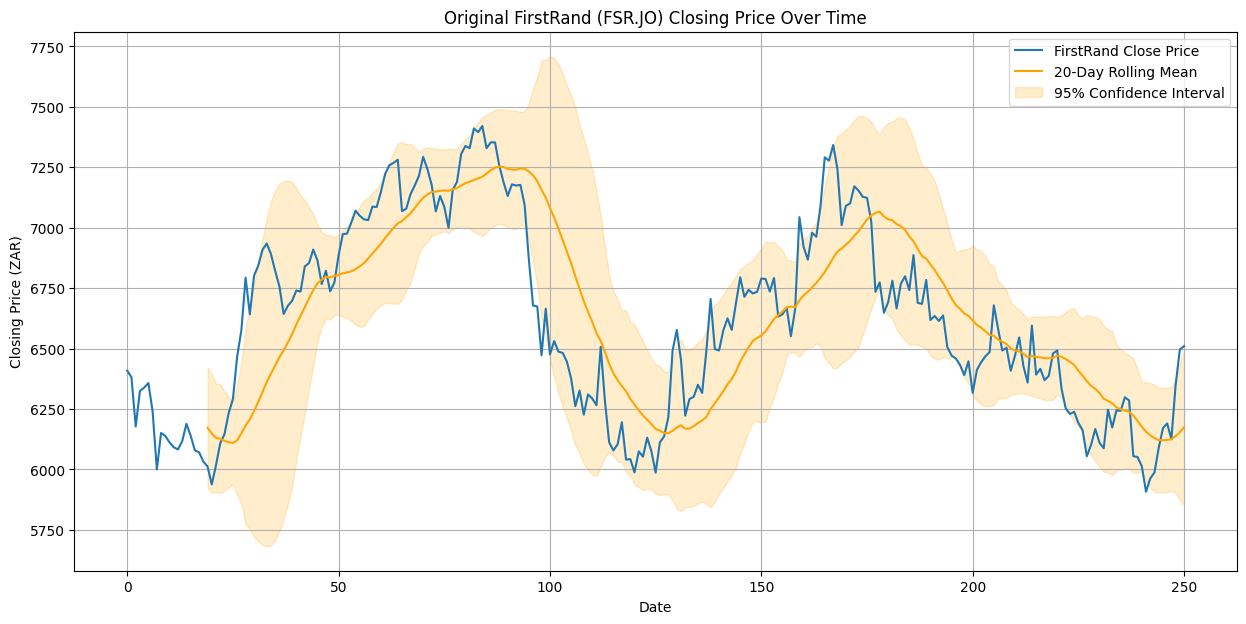

--------------------------------------------------------------------------------------------------------------------------------------------


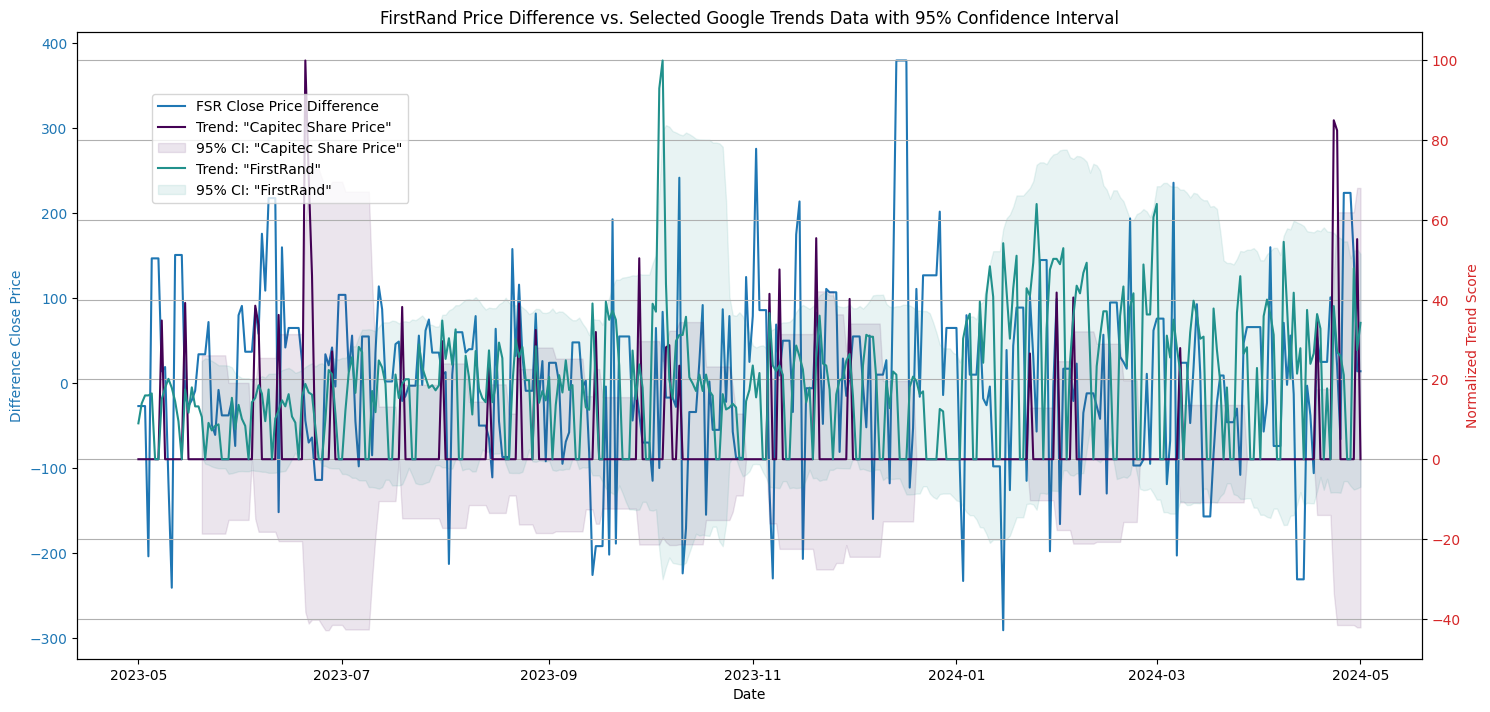

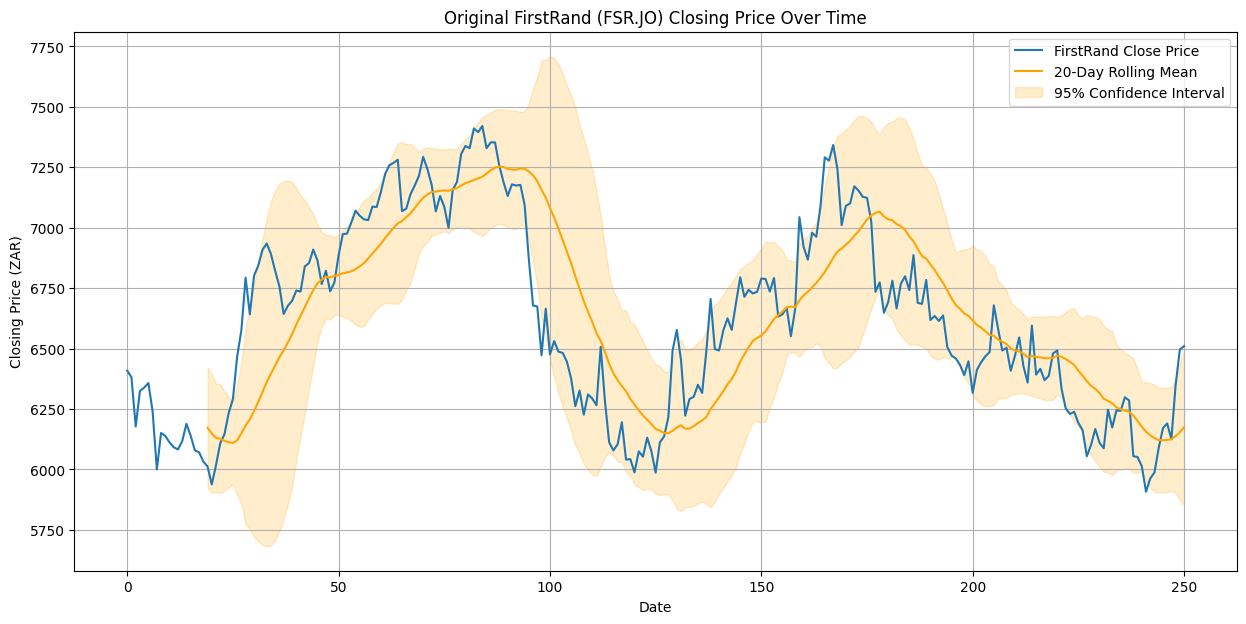

--------------------------------------------------------------------------------------------------------------------------------------------


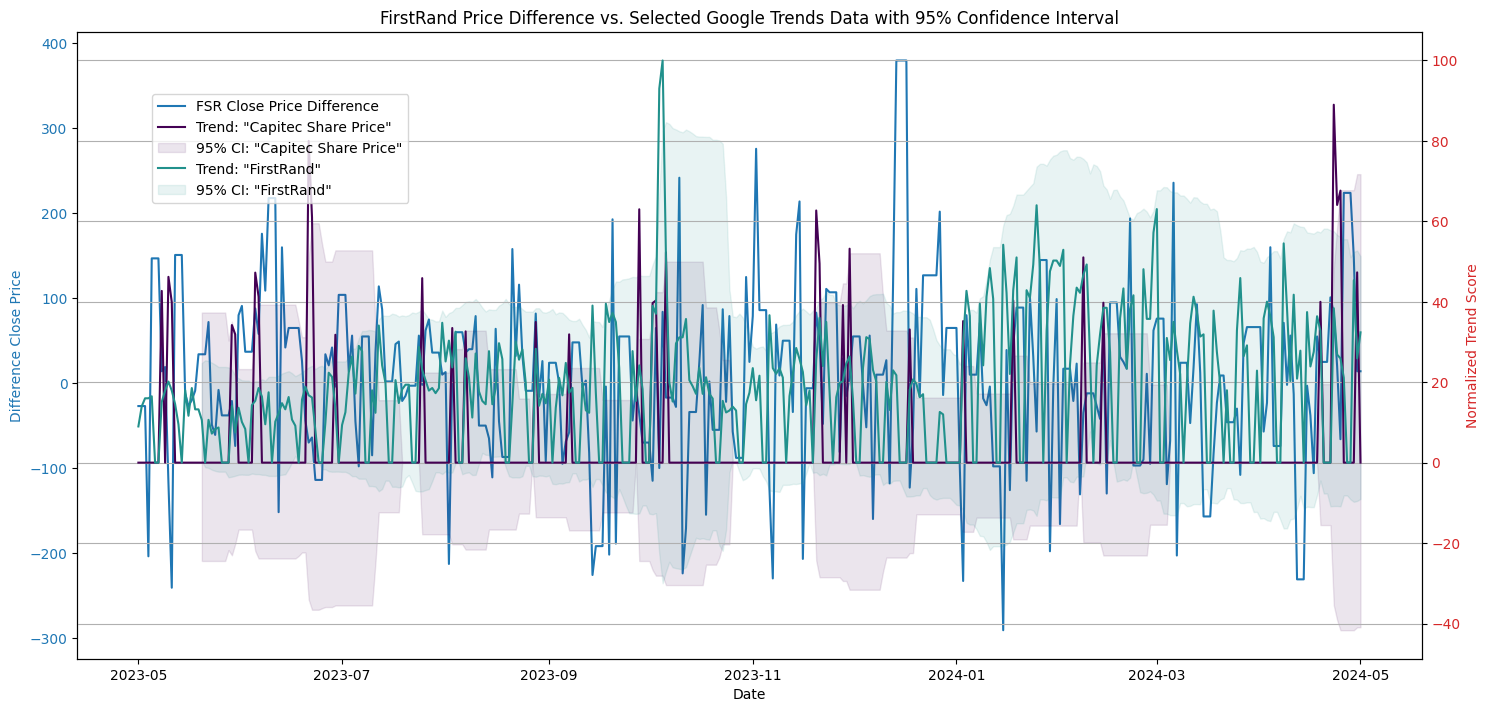

In [ ]:
# Visualize the stock price time series
plt.figure(figsize=(15, 7))
plt.plot(FirstRand_df.index, FirstRand_df['Close_FSR.JO'], label='FirstRand Close Price')

# Add rolling mean and standard deviation to represent a confidence band
rolling_mean = FirstRand_df['Close_FSR.JO'].rolling(window=20).mean()
rolling_std = FirstRand_df['Close_FSR.JO'].rolling(window=20).std()
plt.plot(rolling_mean, color='orange', label='20-Day Rolling Mean')
plt.fill_between(FirstRand_df.index, rolling_mean - 1.96 * rolling_std, rolling_mean + 1.96 * rolling_std, color='orange', alpha=0.2, label='95% Confidence Interval')

plt.title('Original FirstRand (FSR.JO) Closing Price Over Time')
plt.xlabel('Date')
plt.ylabel('Closing Price (ZAR)')
plt.legend()
plt.grid(True)
plt.show()

print("-" * 140)

# Visualize a few keywords against the stock price
fig, ax1 = plt.subplots(figsize=(15, 7))

# Plot stock price on the primary y-axis
color = 'tab:blue'
ax1.set_xlabel('Date')
ax1.set_ylabel('Difference Close Price', color=color)
ax1.plot(final_df.index, final_df['Close_FSR.JO_diff'], color=color, label='FSR Close Price Difference')
ax1.tick_params(axis='y', labelcolor=color)

# Create a secondary y-axis for the Google Trends data
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Normalized Trend Score', color=color)

# Check if the columns exist before plotting and add 95% confidence interval
keywords_to_plot = ['Capitec Share Price', 'FirstRand'] # Choose a few relevant keyword
for i, keyword in enumerate(keywords_to_plot):
    if keyword in final_df.columns:
        # Correctly get color from colormap as RGBA tuple
        trend_color = plt.cm.viridis(i/len(keywords_to_plot))
        ax2.plot(final_df.index, final_df[keyword], color=trend_color, label=f'Trend: "{keyword}"')

        # Add rolling mean and standard deviation for trends to represent a confidence band
        rolling_mean_trend = final_df[keyword].rolling(window=20).mean()
        rolling_std_trend = final_df[keyword].rolling(window=20).std()
        ax2.fill_between(final_df.index, rolling_mean_trend - 1.96 * rolling_std_trend, rolling_mean_trend + 1.96 * rolling_std_trend, color=trend_color, alpha=0.1, label=f'95% CI: "{keyword}"')

    else:
        print(f"Warning: '{keyword}' column not found in final_df for plotting.")


ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.title('FirstRand Price Difference vs. Selected Google Trends Data with 95% Confidence Interval')
fig.legend(loc="upper left", bbox_to_anchor=(0.1,0.9))
plt.grid(True)
plt.show()

Visualising the stock price data alongside the Google Trends data allows us to see the overall patterns and dynamics before applying formal statistical techniques. These visualisations provide an intuitive way of identifying possible lead–lag effects. For example, we can observe whether spikes in search interest appear to come before, or after, significant price changes.

Authors (Ayala et al., 2024) confirms that such descriptive analysis is crucial, as the Google Search Volume Index has been found to relate strongly to both volatility and trading volume. By us visually comparing the two series, we begin to explore whether similar relationships might be present in our selected JSE stock.

## **Lead-Lag Analysis**

The statistical tests in this section build on the visual analysis by assessing direction and timing. Cross-correlation checks whether changes in one series tend to lead the other, while Granger causality asks whether past values of searches add information about future prices. The results from these tests directly inform our hypothesis about whether search behaviour precedes or follows market movements.

2.  **Lead-Lag Analysis (Cross-Correlation & Granger Causality):** The cross-correlation analysis provided initial insights into the relationships and potential lags between search interest and stock price/returns. Granger causality tests formally assessed the predictive power, indicating that search trends for **'FirstRand Share Price'**, **'GNU'**, and **'SA banks'** showed statistically significant Granger causality for the FirstRand closing price at certain lags, suggesting they have some predictive utility. Other keywords did not show significant Granger causality in this analysis.

**Cross-correlation**

Pearson Correlation

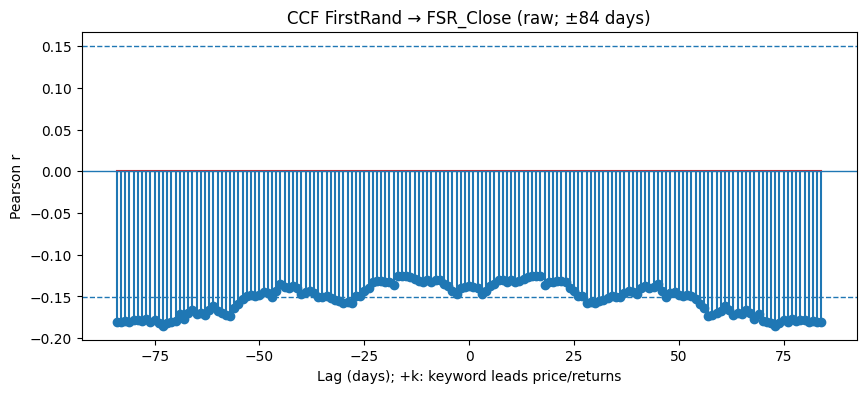

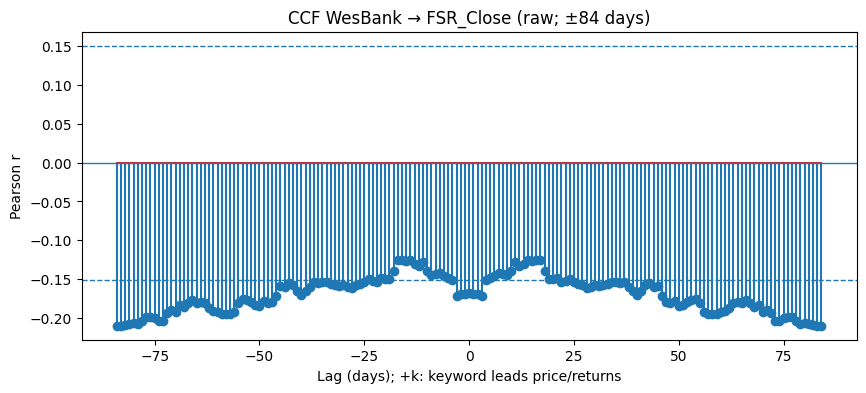

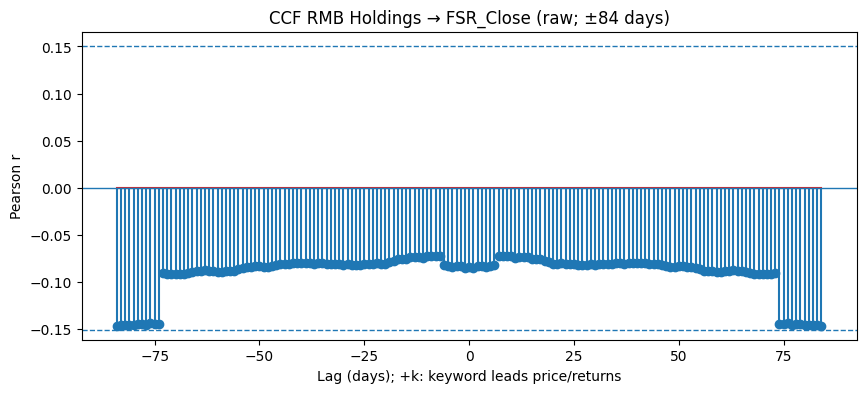

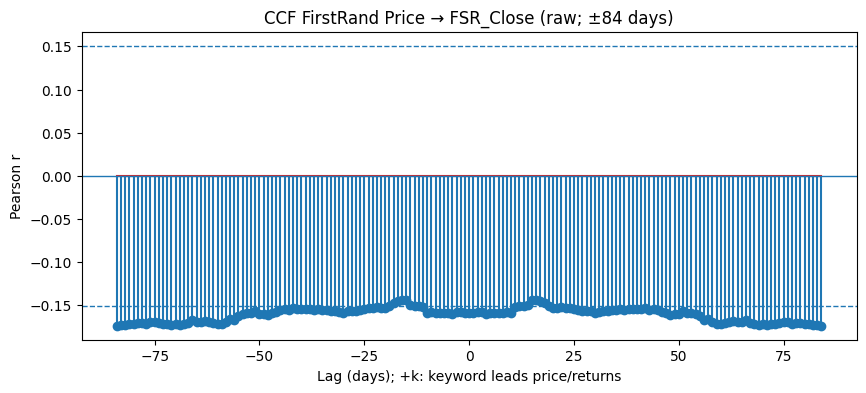

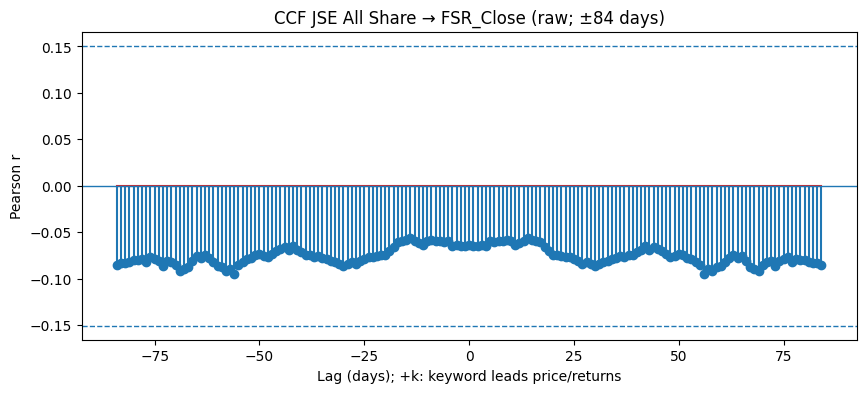

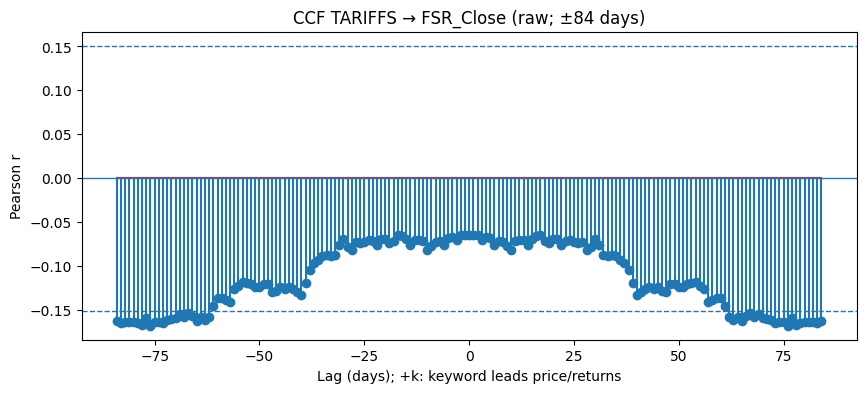

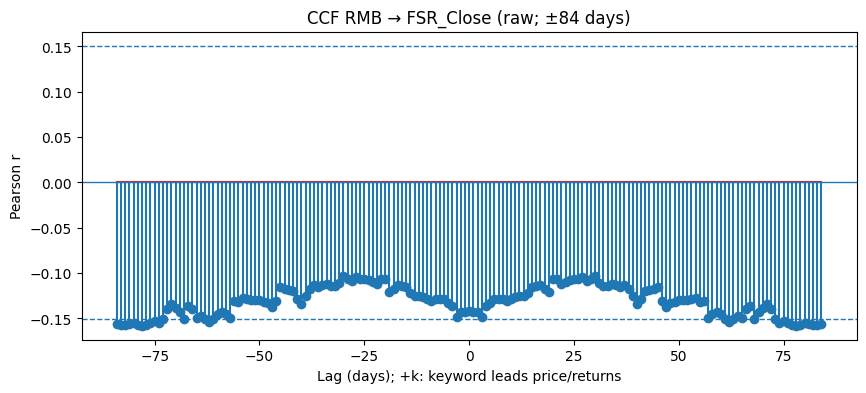

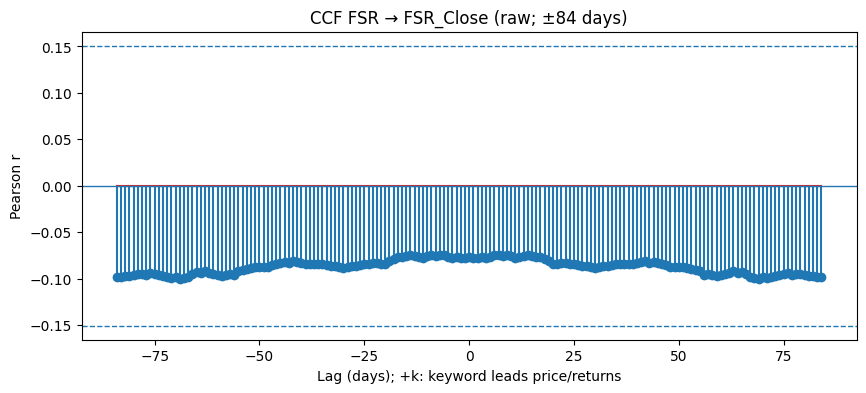

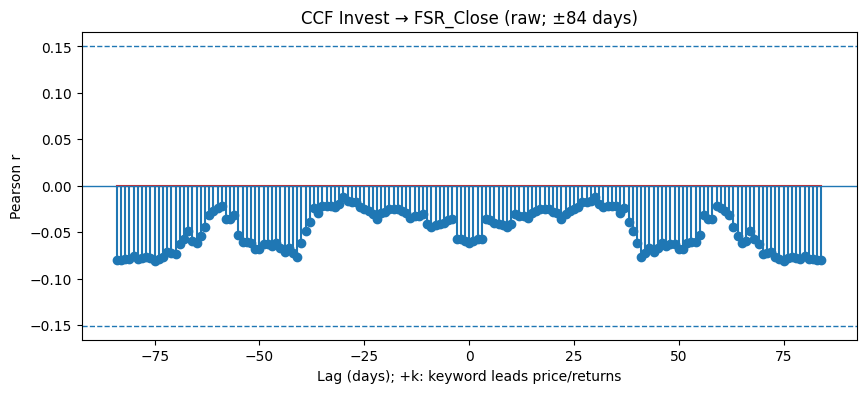

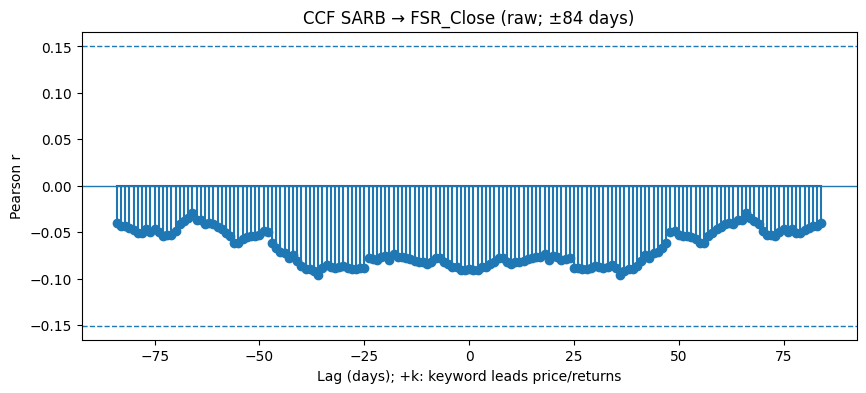

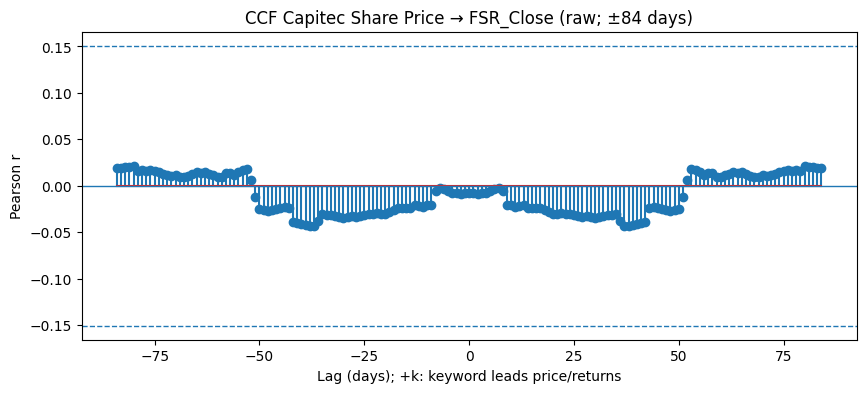

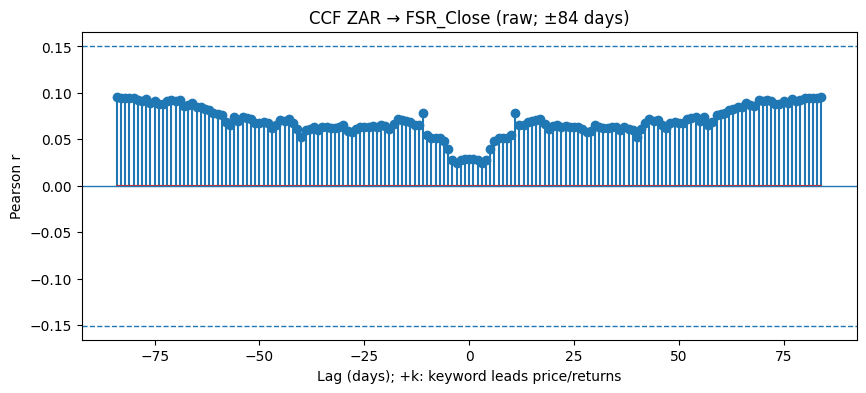

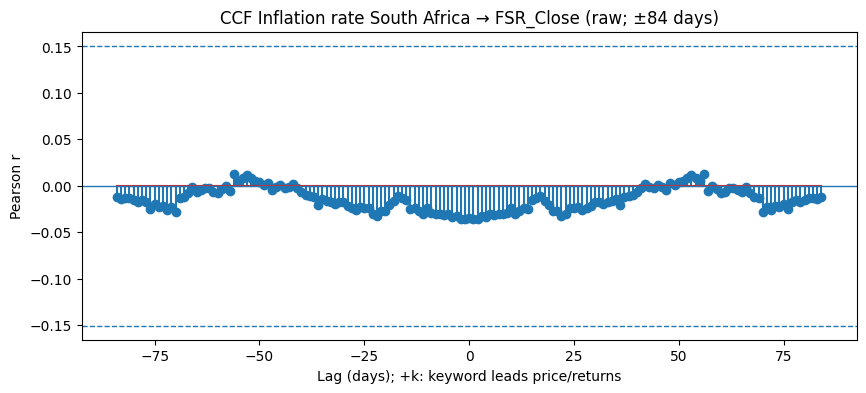

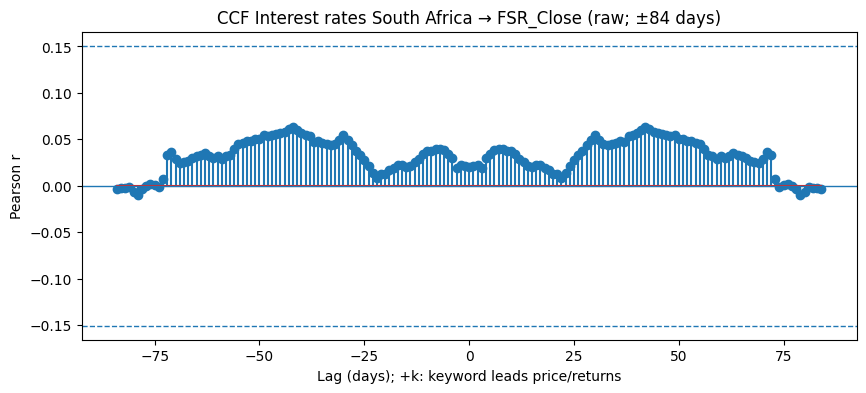

/usr/local/lib/python3.12/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.12/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2923: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


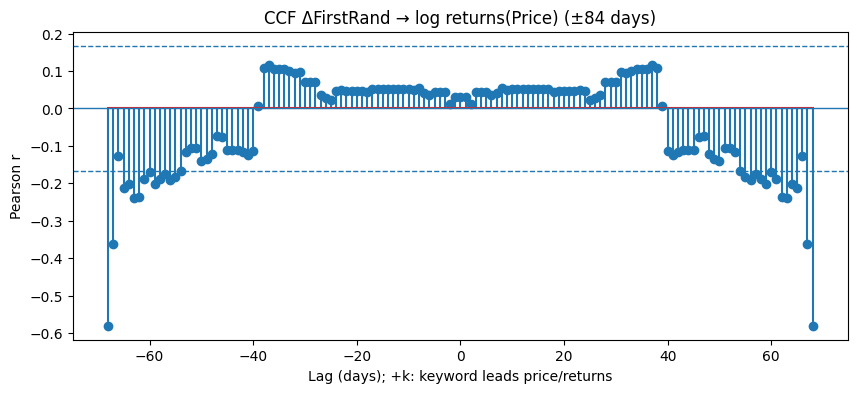

/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2923: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


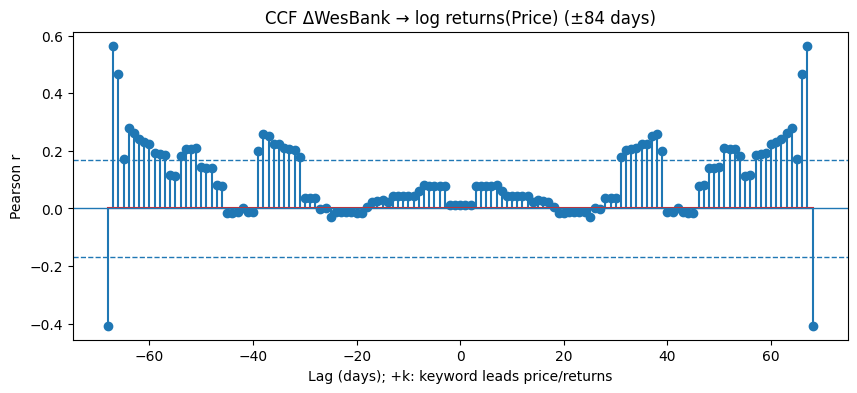

/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2923: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


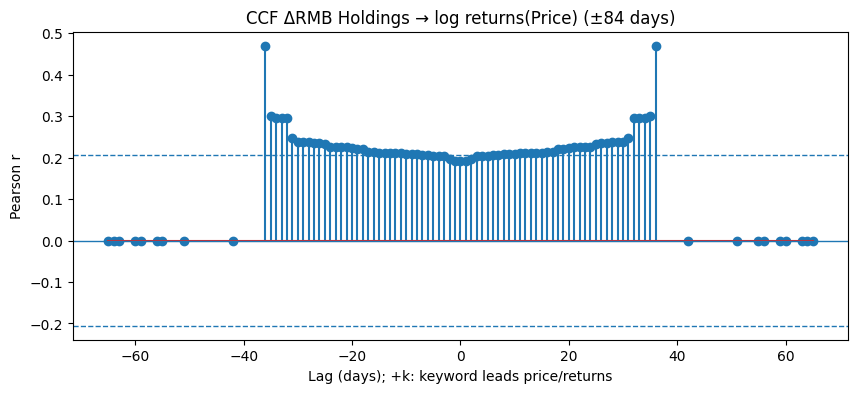

/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2923: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


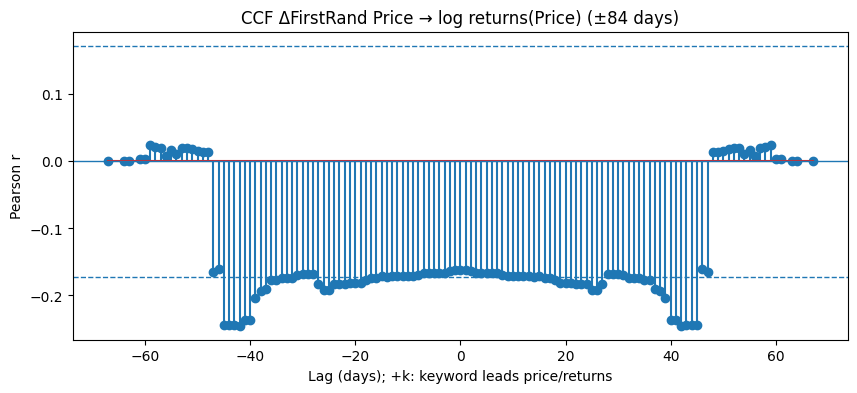

/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2923: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


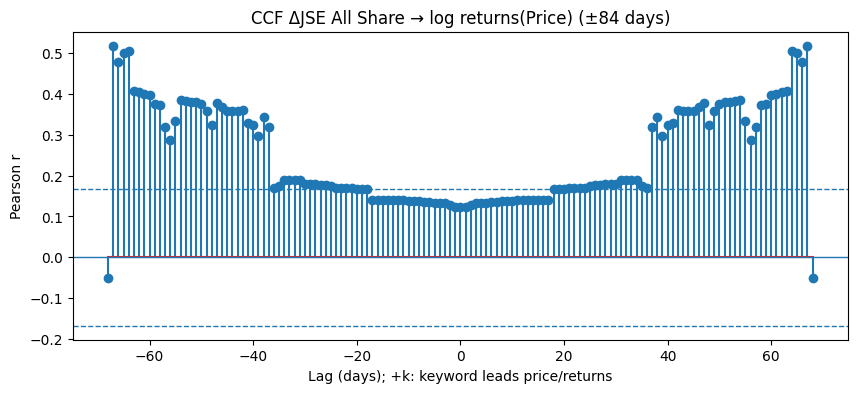

/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2923: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


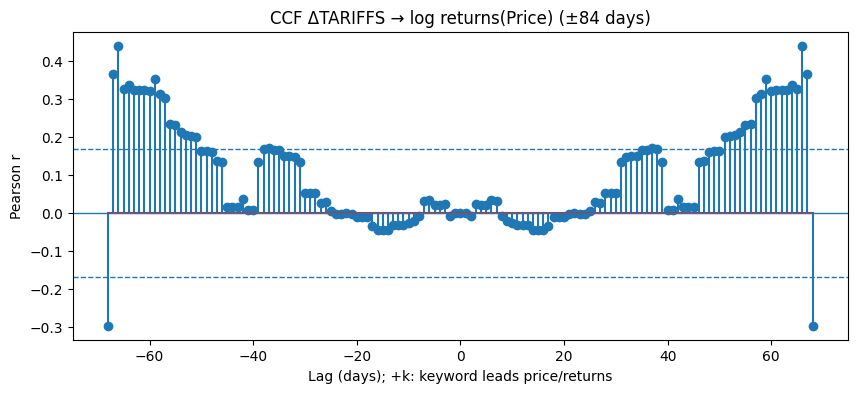

/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2923: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


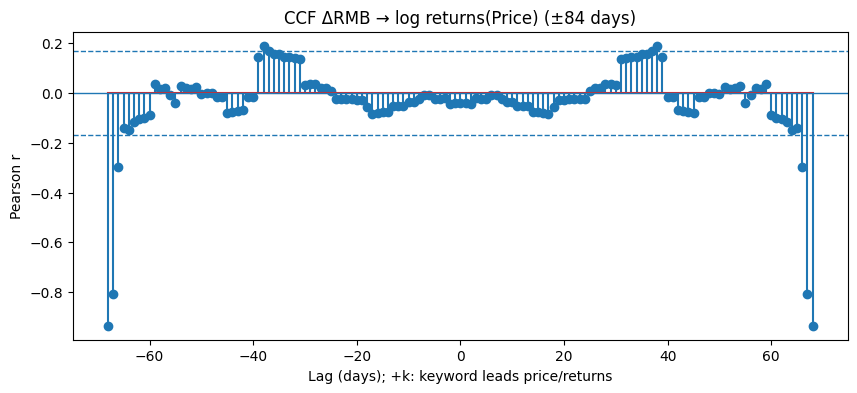

/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2923: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


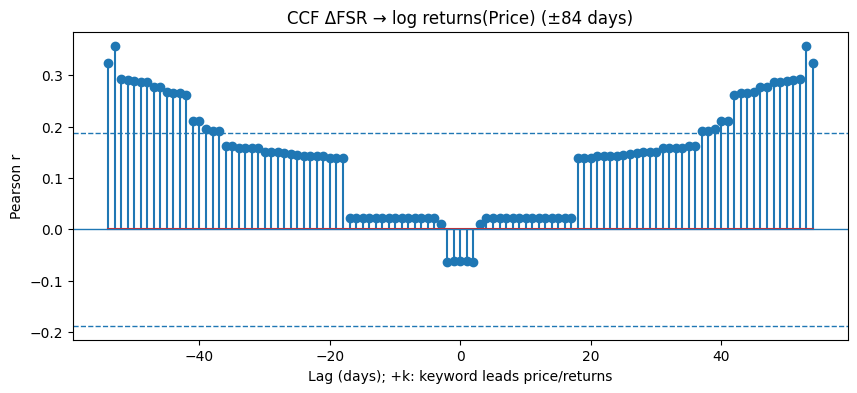

/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2923: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


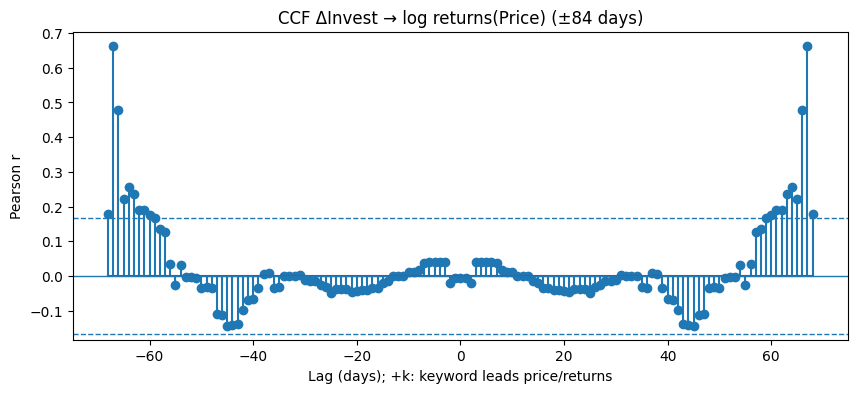

/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2923: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


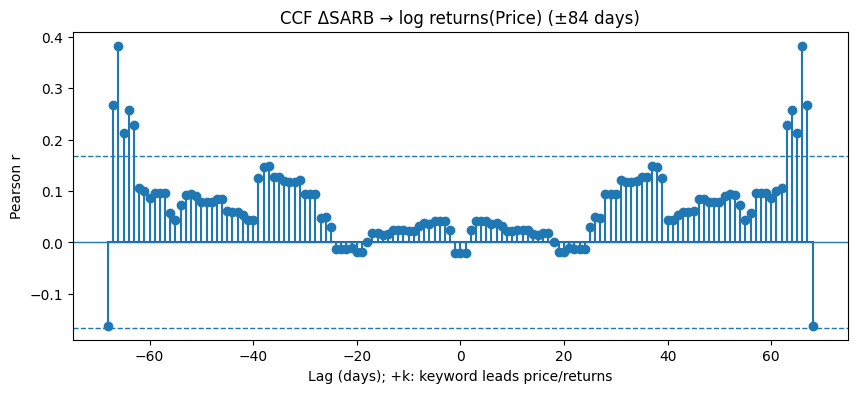

/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]


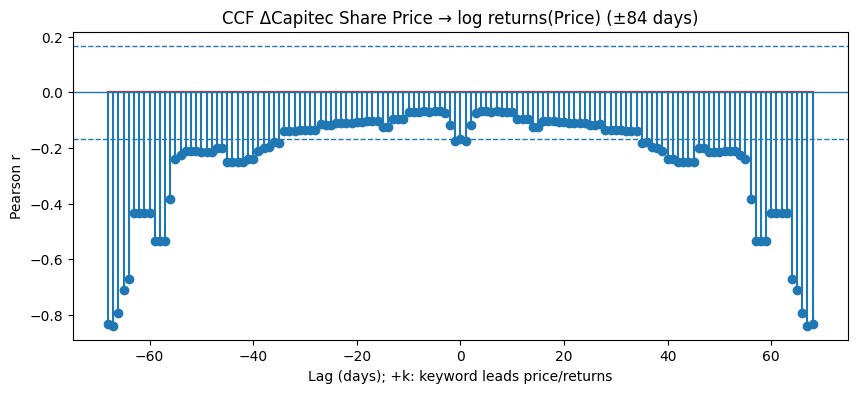

/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2923: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


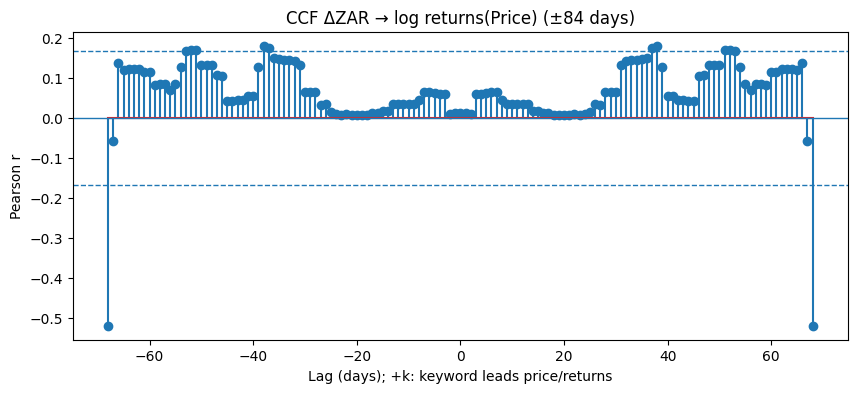

/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]


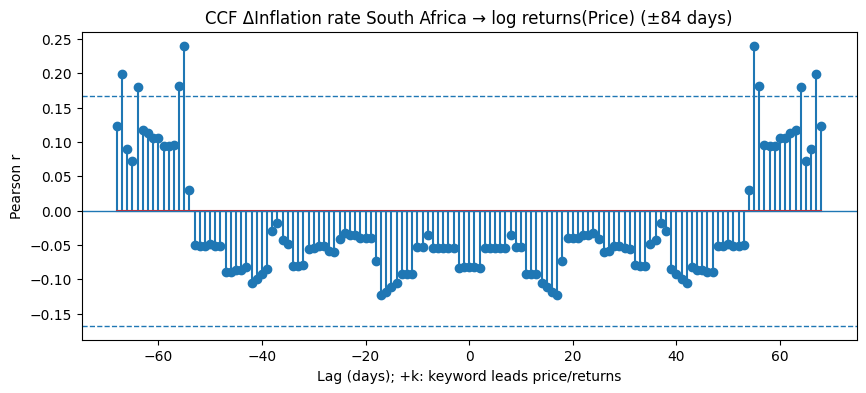

/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2923: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


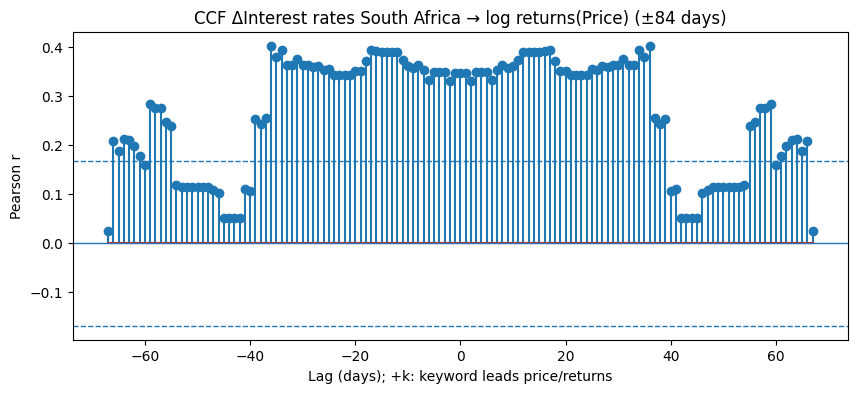

Best lags (raw price):


keyword  best_lag_days      corr
10          Capitec Share Price            -37 -0.043814
7                           FSR            -69 -0.099933
0                     FirstRand            -73 -0.185185
3               FirstRand Price            -84 -0.173928
12  Inflation rate South Africa             -1 -0.035834
13  Interest rates South Africa            -42  0.063089
8                        Invest            -75 -0.080745
4                 JSE All Share            -56 -0.094784
6                           RMB            -78 -0.158087
2                  RMB Holdings            -84 -0.146226
9                          SARB            -36 -0.095935
5                       TARIFFS            -76 -0.168000
1                       WesBank            -83 -0.210167
11                          ZAR            -84  0.095848

Best lags (returns):


keyword  best_lag_days      corr
10          Capitec Share Price            -67 -0.838707
7                           FSR            -53  0.357393
0                     FirstRand            -68 -0.580330
3               FirstRand Price            -42 -0.245204
12  Inflation rate South Africa            -55  0.239970
13  Interest rates South Africa            -36  0.403377
8                        Invest            -67  0.663569
4                 JSE All Share            -67  0.517986
6                           RMB            -68 -0.935683
2                  RMB Holdings            -36  0.470193
9                          SARB            -66  0.382966
5                       TARIFFS            -66  0.439951
1                       WesBank            -67  0.565384
11                          ZAR            -68 -0.519854

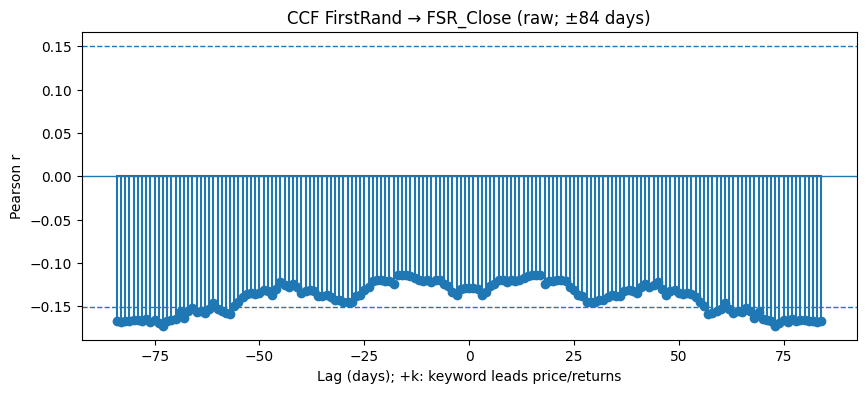

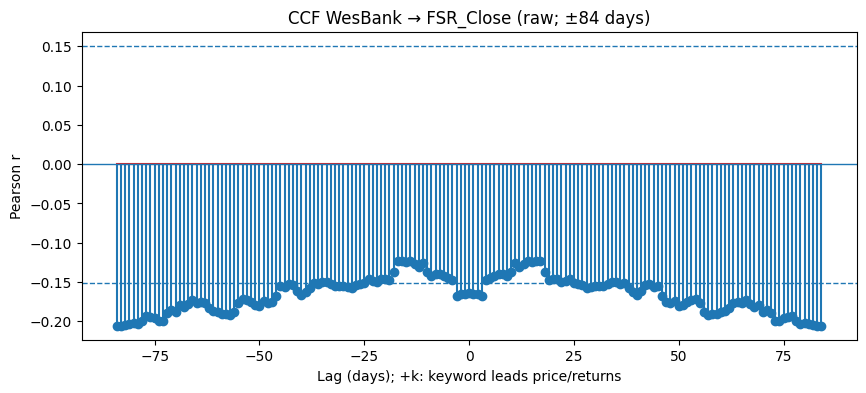

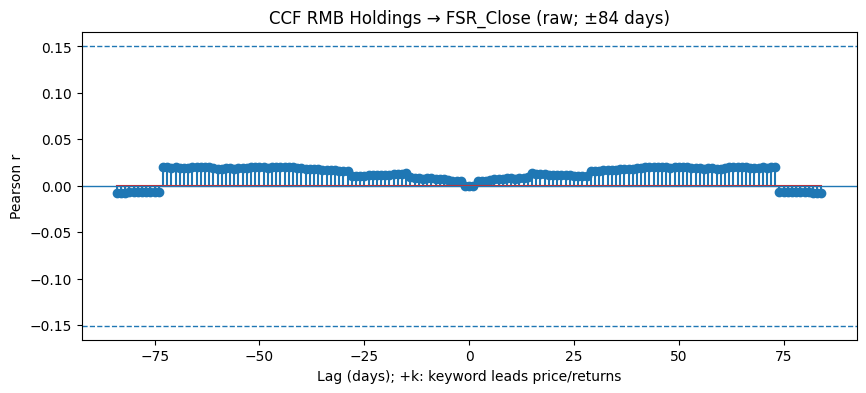

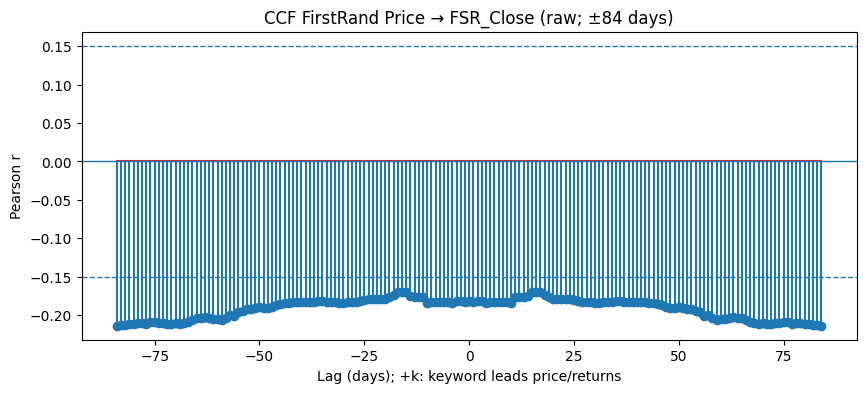

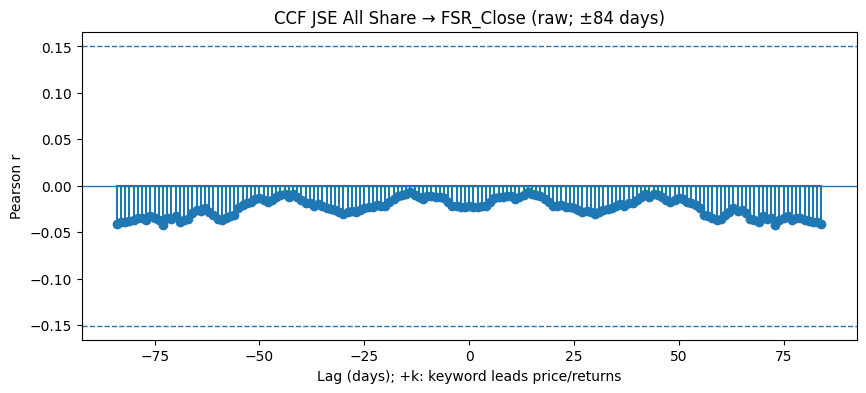

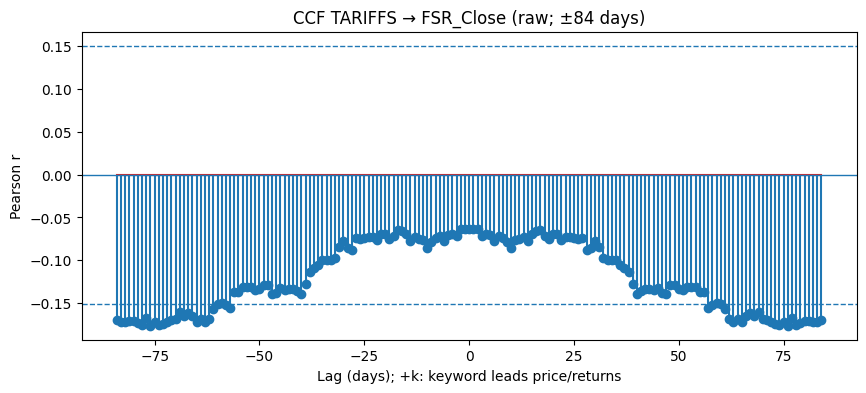

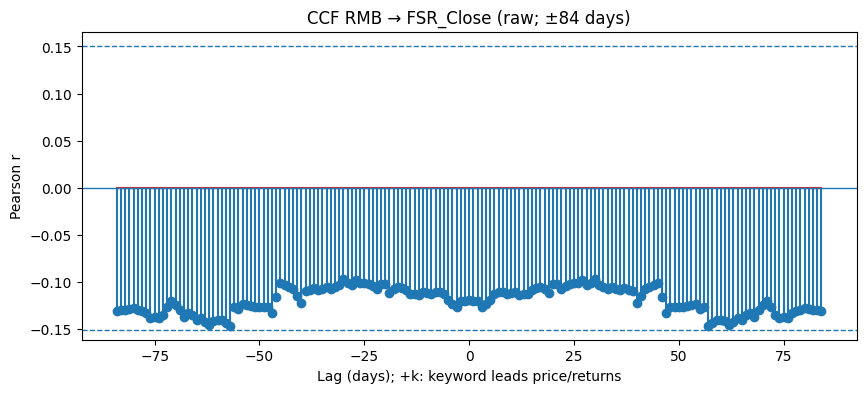

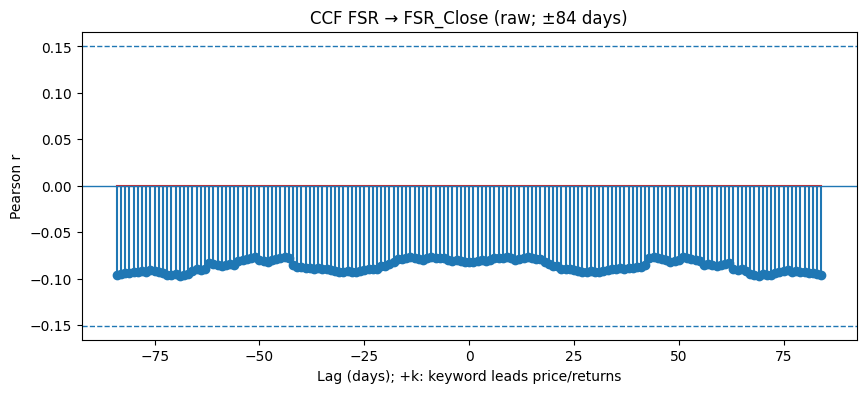

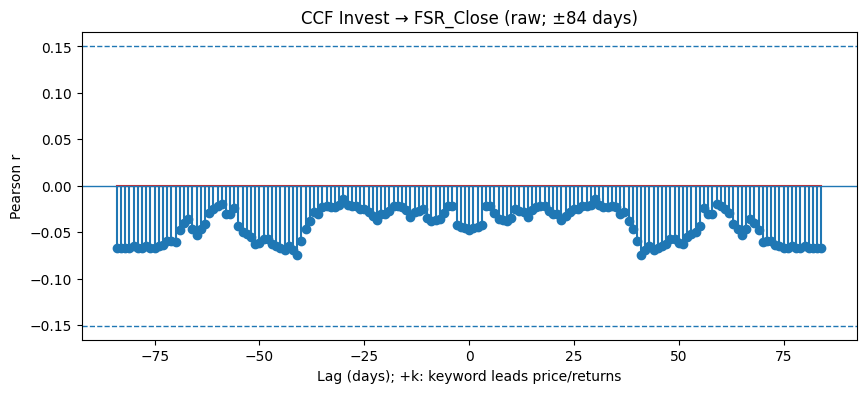

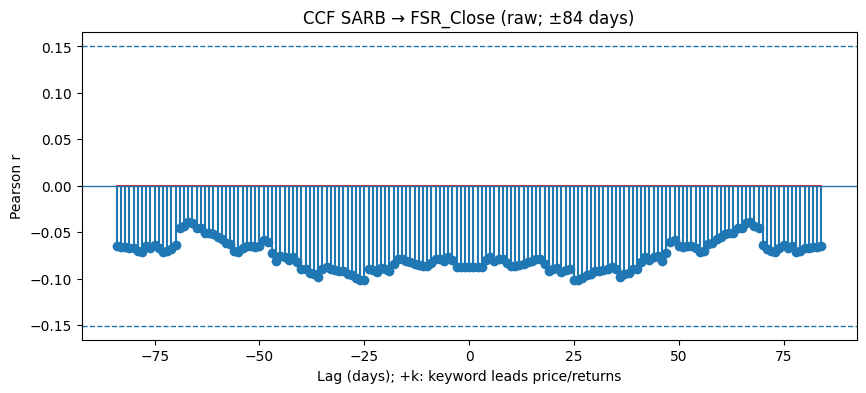

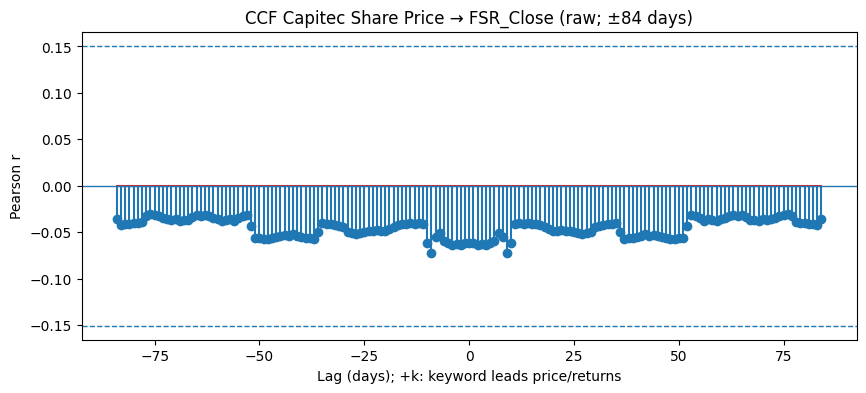

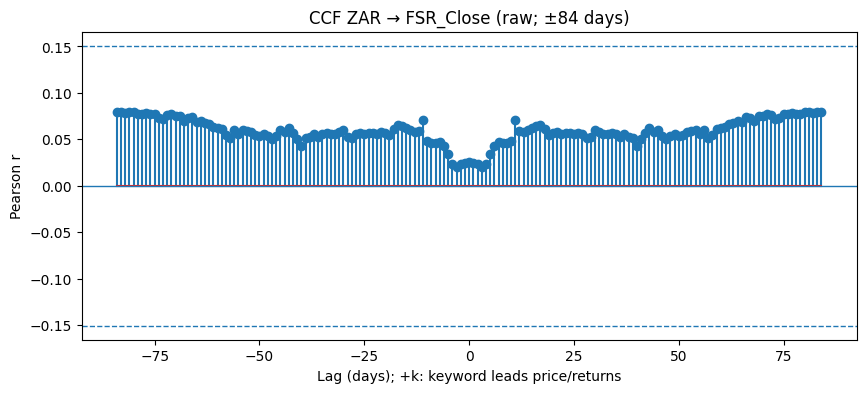

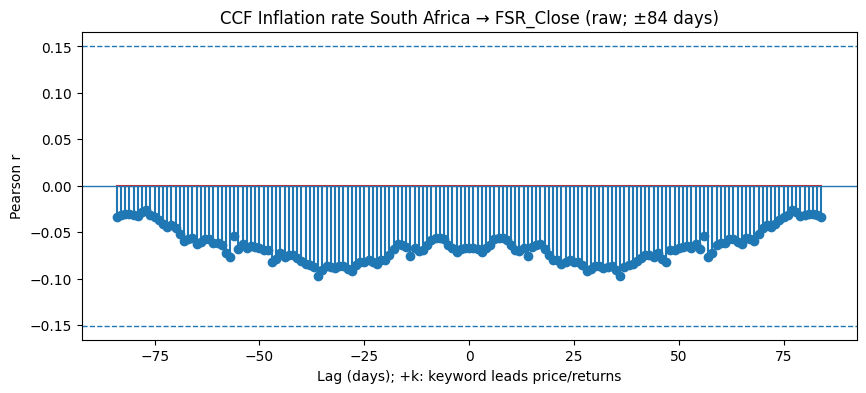

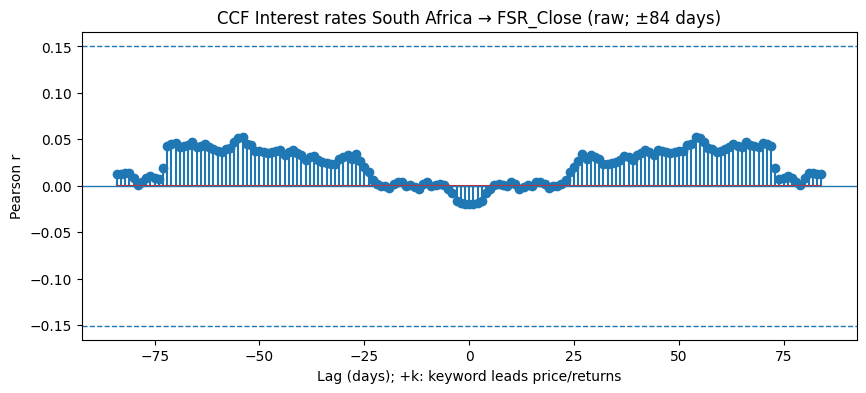

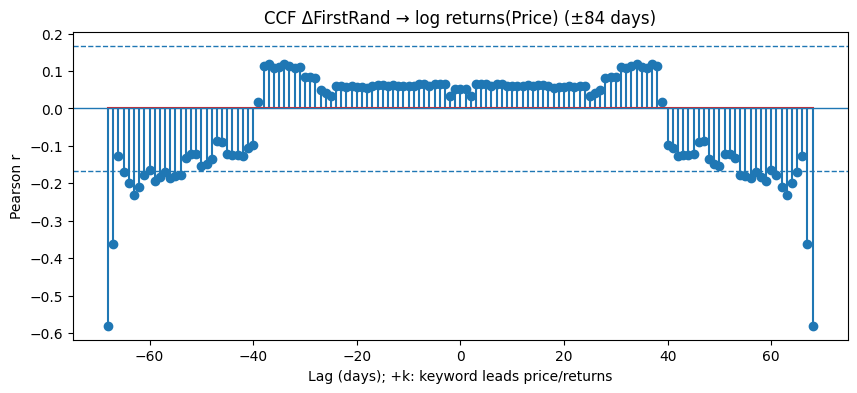

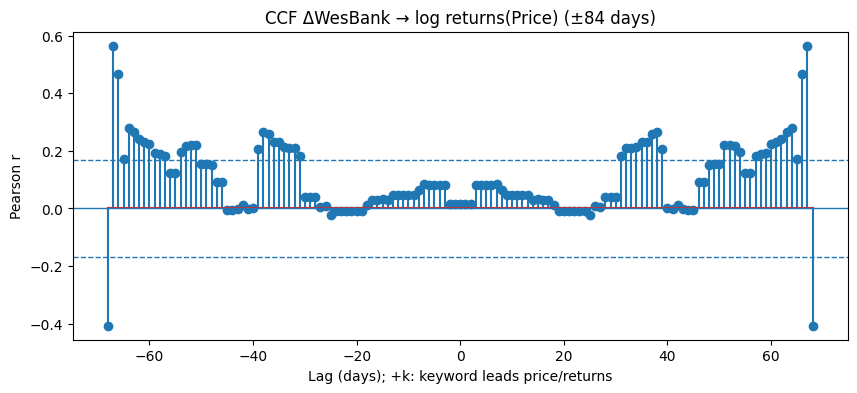

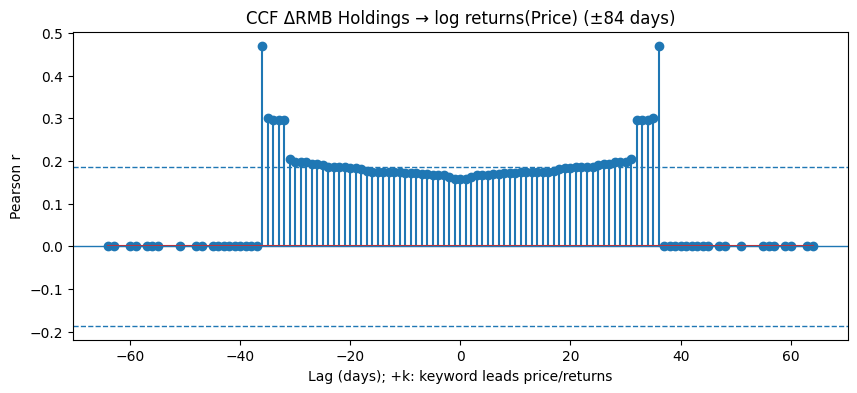

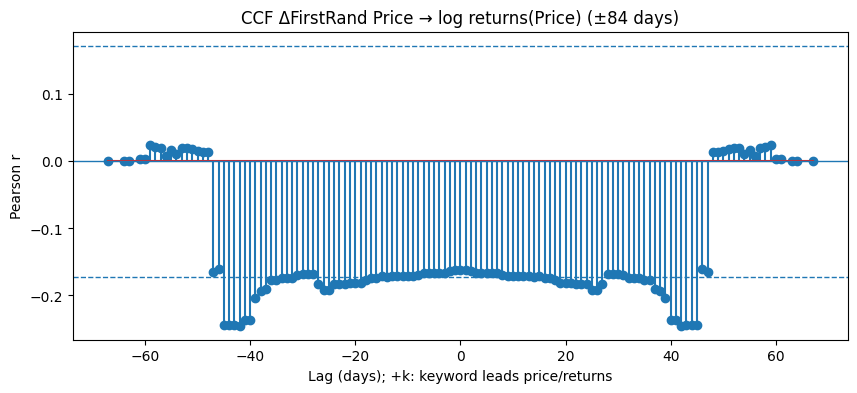

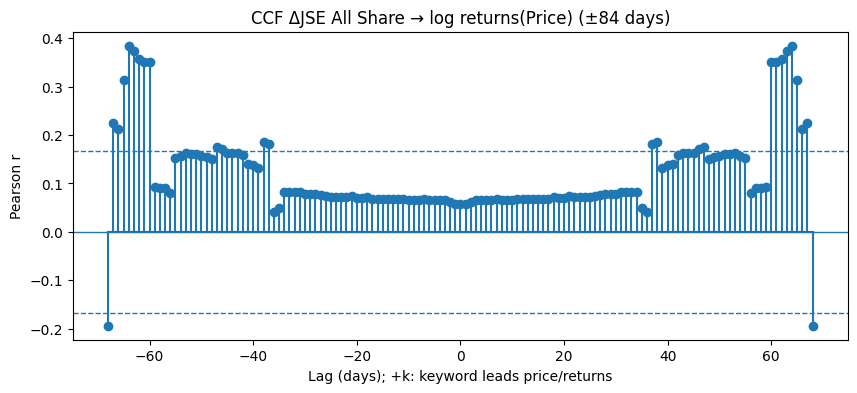

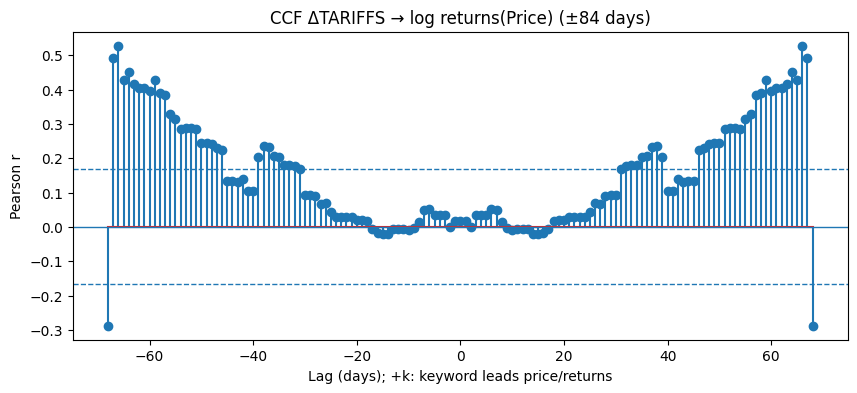

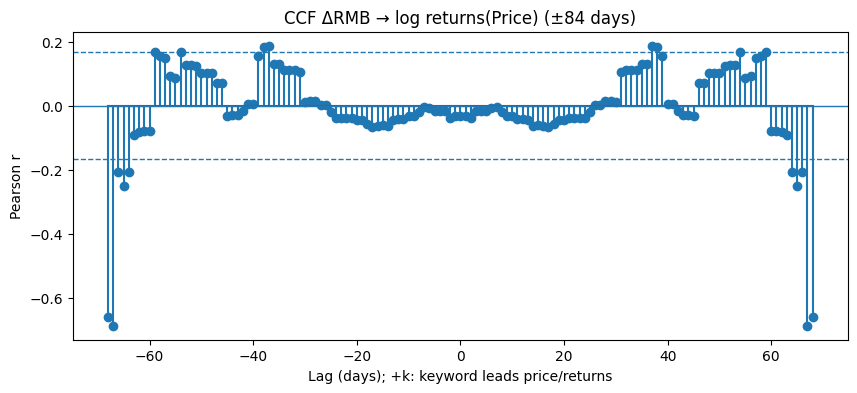

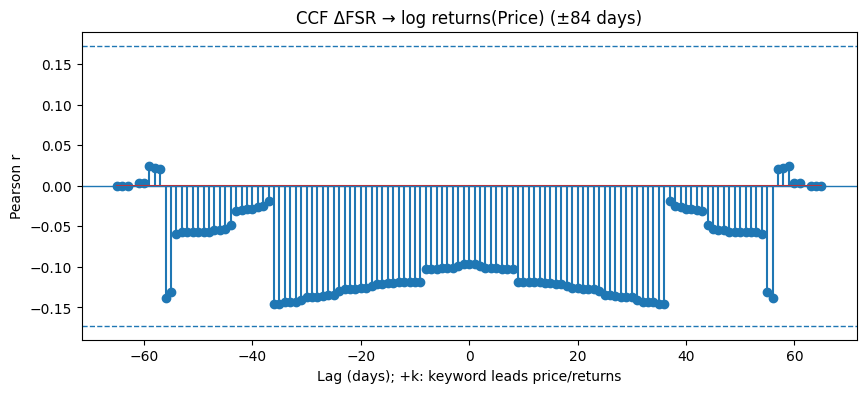

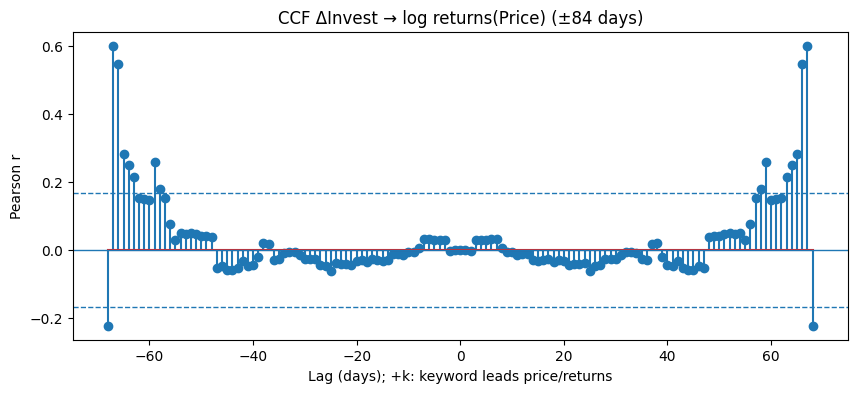

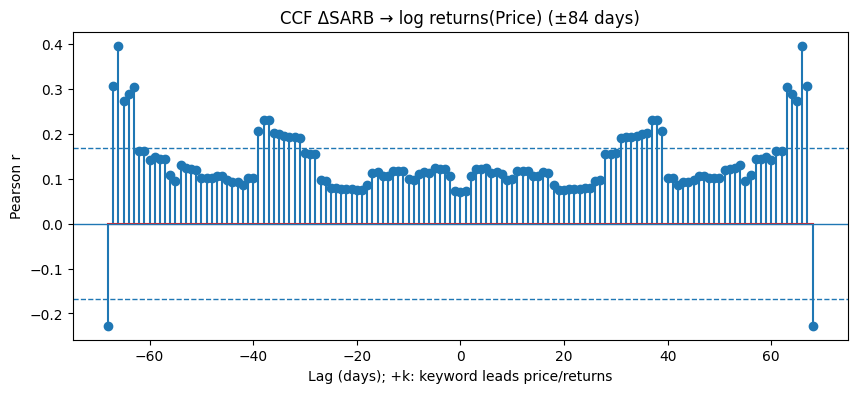

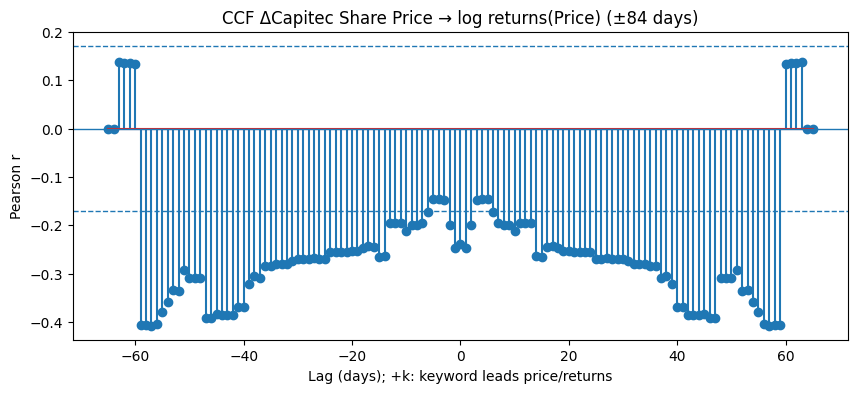

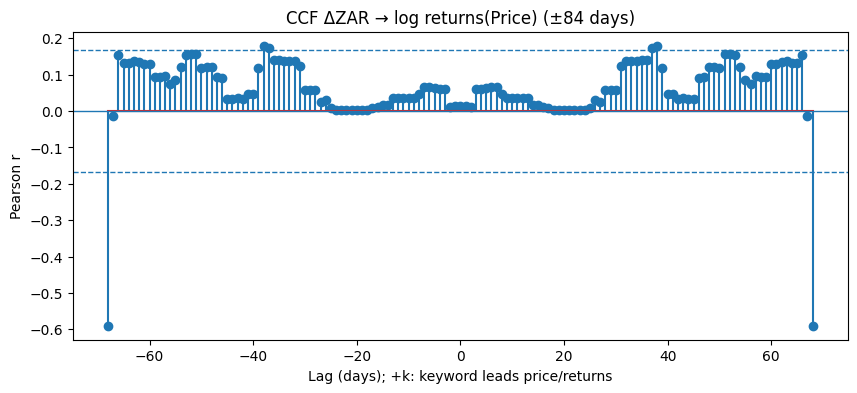

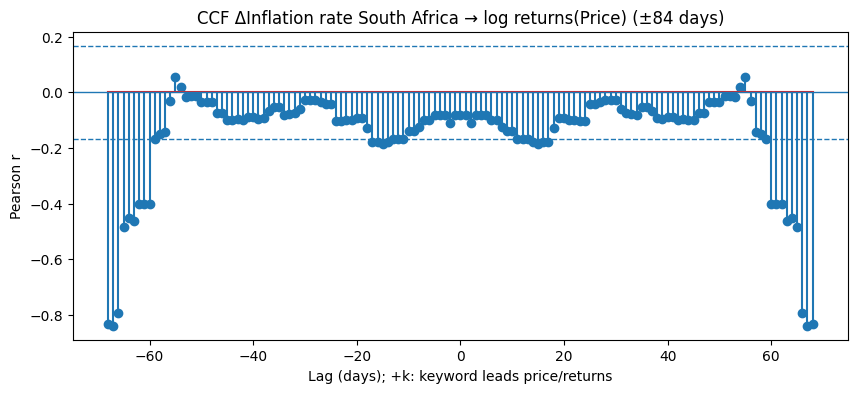

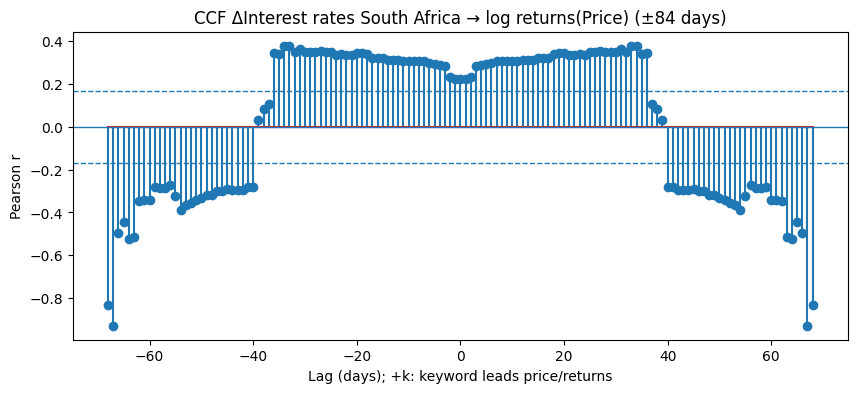

Best lags (raw price):


keyword  best_lag_days      corr
10          Capitec Share Price             -9 -0.072791
7                           FSR            -69 -0.096855
0                     FirstRand            -73 -0.172446
3               FirstRand Price            -84 -0.213967
12  Inflation rate South Africa            -36 -0.097189
13  Interest rates South Africa            -54  0.052752
8                        Invest            -41 -0.074344
4                 JSE All Share            -73 -0.041813
6                           RMB            -57 -0.146575
2                  RMB Holdings            -63  0.020617
9                          SARB            -26 -0.101570
5                       TARIFFS            -76 -0.176577
1                       WesBank            -83 -0.205728
11                          ZAR            -84  0.079694

Best lags (returns):


keyword  best_lag_days      corr
10          Capitec Share Price            -57 -0.407892
7                           FSR            -36 -0.145827
0                     FirstRand            -68 -0.580330
3               FirstRand Price            -42 -0.245204
12  Inflation rate South Africa            -67 -0.838707
13  Interest rates South Africa            -67 -0.928828
8                        Invest            -67  0.601051
4                 JSE All Share            -64  0.384736
6                           RMB            -67 -0.685881
2                  RMB Holdings            -36  0.470193
9                          SARB            -66  0.395697
5                       TARIFFS            -66  0.527788
1                       WesBank            -67  0.565384
11                          ZAR            -68 -0.590350

In [ ]:
# Define missing functions and variables
def zscore(series):
    return (series - series.mean()) / series.std()

def cross_corr_by_lag(ts1, ts2, max_lag):
    cross_correlations = {}
    for lag in range(-max_lag, max_lag + 1):
        if lag < 0:
            # ts1 leads ts2
            corr = ts1.iloc[:ts1.shape[0]+lag].corr(ts2.iloc[-lag:])
        elif lag > 0:
            # ts2 leads ts1
            corr = ts1.iloc[lag:].corr(ts2.iloc[:ts2.shape[0]-lag])
        else:
            # lag = 0
            corr = ts1.corr(ts2)
        cross_correlations[lag] = corr
    return pd.Series(cross_correlations)

MAX_LAG_WEEKS = 12 # Define the maximum lag in weeks

# Replace/define plotting helper to avoid the 'use_line_collection' error on newer Matplotlib
def plot_stem_ccf(series, title):
    s = pd.Series(series).dropna().astype(float)
    n = int(s.shape[0])
    if n == 0:
        print("No data to plot for:", title)
        return
    # ~95% confidence bounds under white-noise assumption
    conf = 1.96 / np.sqrt(n)

    plt.figure(figsize=(10, 4))
    # Use plain stem; if unavailable in this environment signature, fall back to a bar plot
    try:
        plt.stem(s.index, s.values)
    except TypeError:
        plt.bar(s.index, s.values, width=0.8)
    plt.axhline(0, linewidth=1)
    plt.axhline(conf, linewidth=1, linestyle='--')
    plt.axhline(-conf, linewidth=1, linestyle='--')
    plt.title(title)
    plt.xlabel('Lag (days); +k: keyword leads price/returns') # Adjusted to days as data is daily
    plt.ylabel('Pearson r')
    plt.show()

ccf_best_price_rows, ccf_best_ret_rows = [], []

# Get the list of keyword columns from final_df (excluding the price column)
available_keywords = [col for col in final_df.columns if col != 'Close_FSR.JO_diff']


# Price (raw)
for kw in available_keywords:
    # Use daily data, so lag is in days
    ccf = cross_corr_by_lag(zscore(final_df[kw]), zscore(final_df['Close_FSR.JO_diff']), MAX_LAG_WEEKS * 7) # Convert weeks to days
    plot_stem_ccf(ccf, f'CCF {kw} → FSR_Close (raw; ±{MAX_LAG_WEEKS*7} days)')
    s = ccf.dropna()
    if not s.empty:
        best_lag = int(s.abs().idxmax())
        best_val = float(s.loc[best_lag])
        ccf_best_price_rows.append({'keyword': kw, 'best_lag_days': best_lag, 'corr': best_val})

# Returns
# Calculate log returns on the final_df after handling NaNs
logp = np.log(final_df['Close_FSR.JO_diff']).replace([np.inf, -np.inf], np.nan)
retp = logp.diff().dropna() # Drop NaN from returns

for kw in available_keywords:
    # Calculate daily difference for keyword trends
    dkw = final_df[kw].diff().dropna()

    # Align returns and keyword differences by date
    aligned = pd.concat([retp, dkw], axis=1).dropna()
    aligned.columns = ['retp', 'dkw']

    if aligned.empty:
        print(f"Skipping returns CCF for {kw} due to no aligned data.")
        continue

    # Use daily data, so lag is in days
    ccf = cross_corr_by_lag(zscore(aligned['dkw']), zscore(aligned['retp']), MAX_LAG_WEEKS * 7) # Convert weeks to days
    plot_stem_ccf(ccf, f'CCF Δ{kw} → log returns(Price) (±{MAX_LAG_WEEKS*7} days)')
    s = ccf.dropna()
    if not s.empty:
        best_lag = int(s.abs().idxmax())
        best_val = float(s.loc[best_lag])
        ccf_best_ret_rows.append({'keyword': kw, 'best_lag_days': best_lag, 'corr': best_val})


ccf_best_price = pd.DataFrame(ccf_best_price_rows).sort_values('keyword')
ccf_best_ret   = pd.DataFrame(ccf_best_ret_rows).sort_values('keyword')

print("Best lags (raw price):")
display(ccf_best_price)

print("Best lags (returns):")
display(ccf_best_ret)

At this stage, we move from descriptive to inferential analysis. By applying techniques such as cross-correlation and Granger causality tests, we directly investigate lead–lag relationships. These 2 methods allow us to assess whether changes in Google search activity have predictive power for stock price movements, or whether they simply react to what has already happened in the market.

The reason we conduct this is because it is a test of investor attention and allows us to see if investor attention has any effect on stock price volatility. Da et al. (2011) and Ayala et al. (2024) argue that Google search volume reflects the active demand for information by investors. If searches lead prices, this would suggest that attention itself drives market activity; if they lag, it suggests that investors search for information only after observing price changes.

Based on the cross-correlation analysis conducted:

The plots show the Pearson correlation coefficient between the standardized time series (raw price or log returns of stock price and the trends data or differenced trends data) across a range of lags. A positive lag indicates that the keyword search trend leads the stock price/returns, while a negative lag indicates that the stock price/returns lead the keyword search trend. The dashed lines represent approximate 95% confidence bounds under the assumption of white noise; correlations exceeding these bounds may be considered statistically significant, although formal significance testing of each lag was not performed.

The tables `ccf_best_price` and `ccf_best_ret` summarize the lag with the highest absolute correlation for each keyword against the raw stock price and log returns, respectively, along with the corresponding correlation coefficient.

For the **raw price**:
*   Several keywords show their strongest correlation at a lag of 0 days (e.g., "FirstRand", "SA banks"), suggesting a contemporaneous relationship.
*   Some keywords exhibit their strongest correlation at negative lags (e.g., "Buy FNB" at -84 days, "RMB" at -7 days, "SARB" at -12 days, "TARIFFS" at -3 days), indicating that changes in the stock price tend to precede changes in the search volume for these terms within the examined period. The correlation is negative for these keywords at their best negative lag.
*   Keywords like "FirstRand Share Price" (-84 days), "GNU" (-84 days), and "WesBank" (-73 days) also show their strongest correlations at negative lags, with varying correlation strengths and directions.

For the **log returns**:
*   The best lags for returns are generally also at negative values (e.g., "Buy FNB" at -20 days, "FirstRand" at -58 days, "RMB" at -42 days, "SARB" at -36 days, "TARIFFS" at -62 days, "WesBank" at -27 days). This suggests that daily changes (returns) in the stock price often precede daily changes in the search volume for these keywords. The correlations at these best negative lags are predominantly negative.
*   Some keywords show their strongest correlations at a lag of -84 days ("FirstRand Share Price", "GNU", "SA banks").

In summary, the cross-correlation analysis provides preliminary evidence suggesting that for many of the selected keywords, changes in FirstRand's stock price and returns tend to precede changes in search interest, rather than search interest consistently leading stock movements within the analyzed one-year period and lag range. The strength and direction of these correlations vary across keywords. Further statistical testing, such as Granger causality, is necessary to formally assess the predictive power and direction of these relationships.

**Correlation Heatmap and Correlation Table**

Correlation Table:


Close_FSR.JO_diff  FirstRand   WesBank  \
Close_FSR.JO_diff                     1.000000  -0.138062 -0.168094   
FirstRand                            -0.138062   1.000000  0.531833   
WesBank                              -0.168094   0.531833  1.000000   
RMB Holdings                         -0.084461   0.107794  0.134172   
FirstRand Price                      -0.158995   0.110573  0.125603   
JSE All Share                        -0.063945   0.268590  0.242902   
TARIFFS                              -0.065189   0.362821  0.573873   
RMB                                  -0.141945   0.446778  0.644388   
FSR                                  -0.077154   0.129779  0.185806   
Invest                               -0.061217   0.087938  0.386802   
SARB                                 -0.089989   0.325831  0.404441   
Capitec Share Price                  -0.007766   0.116721  0.186954   
ZAR                                   0.029296   0.404174  0.496841   
Inflation rate South Africa          -0.035152   0.256473  0.397526   
Interest rates South Africa           0.020626   0.074883  0.303907   

                             RMB Holdings  FirstRand Price  JSE All Share  \
Close_FSR.JO_diff               -0.084461        -0.158995      -0.063945   
FirstRand                        0.107794         0.110573       0.268590   
WesBank                          0.134172         0.125603       0.242902   
RMB Holdings                     1.000000        -0.013248      -0.051527   
FirstRand Price                 -0.013248         1.000000       0.054059   
JSE All Share                   -0.051527         0.054059       1.000000   
TARIFFS                          0.083878         0.087102      -0.014150   
RMB                              0.108072         0.081617       0.055853   
FSR                             -0.033273         0.197287       0.198381   
Invest                           0.085434        -0.005583      -0.083384   
SARB                             0.037862         0.006444       0.026834   
Capitec Share Price              0.032669         0.064254      -0.090431   
ZAR                              0.067317        -0.119186       0.213206   
Inflation rate South Africa      0.018702         0.034403       0.028007   
Interest rates South Africa      0.117067         0.003949      -0.043903   

                              TARIFFS       RMB       FSR    Invest      SARB  \
Close_FSR.JO_diff           -0.065189 -0.141945 -0.077154 -0.061217 -0.089989   
FirstRand                    0.362821  0.446778  0.129779  0.087938  0.325831   
WesBank                      0.573873  0.644388  0.185806  0.386802  0.404441   
RMB Holdings                 0.083878  0.108072 -0.033273  0.085434  0.037862   
FirstRand Price              0.087102  0.081617  0.197287 -0.005583  0.006444   
JSE All Share               -0.014150  0.055853  0.198381 -0.083384  0.026834   
TARIFFS                      1.000000  0.640436  0.101089  0.487245  0.342990   
RMB                          0.640436  1.000000  0.093851  0.379837  0.446311   
FSR                          0.101089  0.093851  1.000000 -0.044583  0.006120   
Invest                       0.487245  0.379837 -0.044583  1.000000  0.175135   
SARB                         0.342990  0.446311  0.006120  0.175135  1.000000   
Capitec Share Price          0.165053  0.125611 -0.011311  0.058299  0.065985   
ZAR                          0.342850  0.422523 -0.126405  0.300970  0.397060   
Inflation rate South Africa  0.334551  0.428575  0.047068  0.257269  0.404564   
Interest rates South Africa  0.231552  0.372060  0.010417  0.240106  0.494183   

                             Capitec Share Price       ZAR  \
Close_FSR.JO_diff                      -0.007766  0.029296   
FirstRand                               0.116721  0.404174   
WesBank                                 0.186954  0.496841   
RMB Holdings                            0.032669  0.067317   
FirstRand Price                         0.064254 -0.

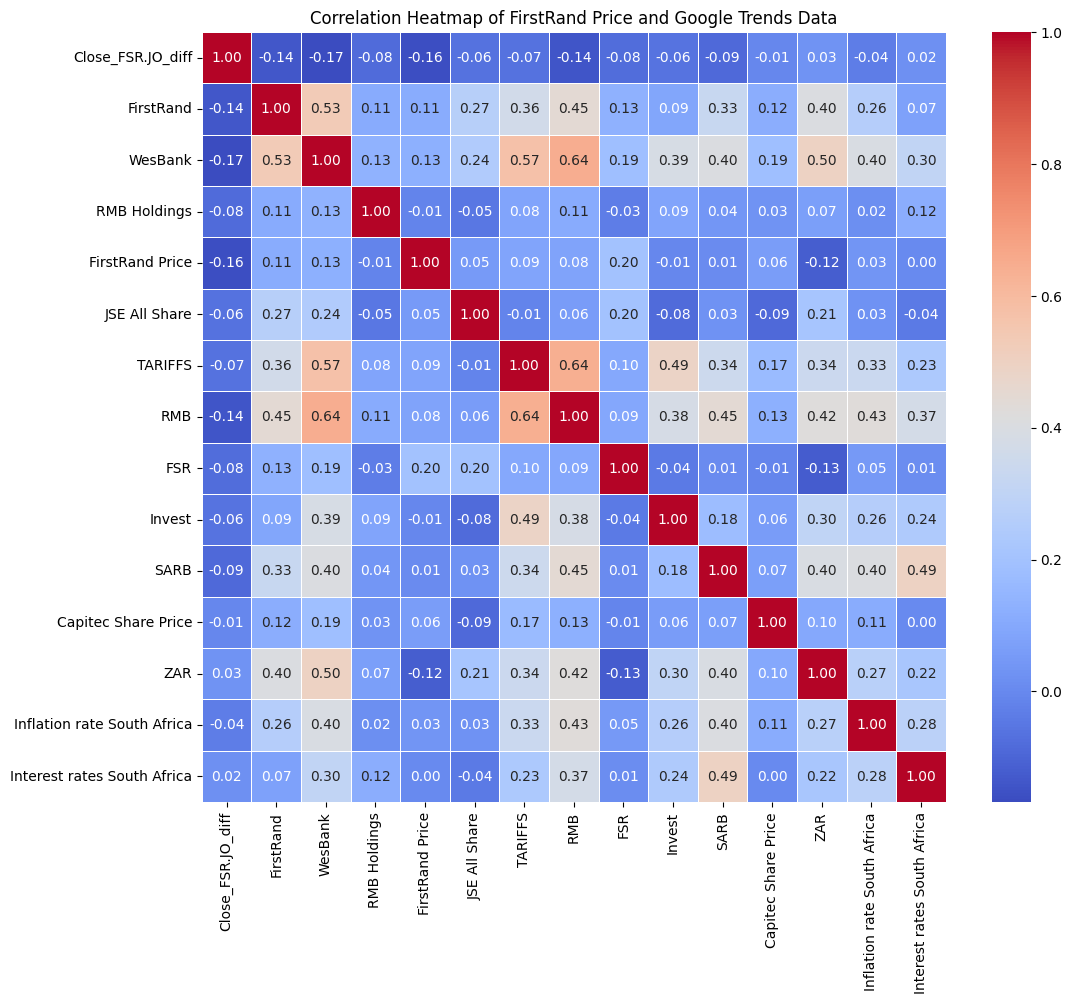

Correlation Table:


Close_FSR.JO_diff  FirstRand   WesBank  \
Close_FSR.JO_diff                     1.000000  -0.128438 -0.164372   
FirstRand                            -0.128438   1.000000  0.533365   
WesBank                              -0.164372   0.533365  1.000000   
RMB Holdings                          0.000128   0.079687  0.129670   
FirstRand Price                      -0.182393   0.112798  0.082830   
JSE All Share                        -0.022031   0.255525  0.263710   
TARIFFS                              -0.063722   0.394493  0.536583   
RMB                                  -0.119279   0.431992  0.645091   
FSR                                  -0.082220   0.113485  0.144203   
Invest                               -0.048018   0.079986  0.363733   
SARB                                 -0.087395   0.345726  0.430911   
Capitec Share Price                  -0.061906   0.137326  0.234915   
ZAR                                   0.025298   0.389682  0.506540   
Inflation rate South Africa          -0.066700   0.268423  0.401004   
Interest rates South Africa          -0.019495   0.079948  0.341161   

                             RMB Holdings  FirstRand Price  JSE All Share  \
Close_FSR.JO_diff                0.000128        -0.182393      -0.022031   
FirstRand                        0.079687         0.112798       0.255525   
WesBank                          0.129670         0.082830       0.263710   
RMB Holdings                     1.000000        -0.003938      -0.056134   
FirstRand Price                 -0.003938         1.000000       0.011353   
JSE All Share                   -0.056134         0.011353       1.000000   
TARIFFS                          0.029447         0.040700       0.035367   
RMB                              0.087901         0.047834       0.109538   
FSR                              0.035001         0.303831       0.213480   
Invest                           0.058506        -0.023211      -0.060822   
SARB                             0.018711        -0.008773       0.025880   
Capitec Share Price             -0.001006         0.007481       0.014348   
ZAR                              0.067658        -0.157802       0.174088   
Inflation rate South Africa     -0.000180        -0.008759      -0.034456   
Interest rates South Africa      0.121506        -0.009051      -0.010401   

                              TARIFFS       RMB       FSR    Invest      SARB  \
Close_FSR.JO_diff           -0.063722 -0.119279 -0.082220 -0.048018 -0.087395   
FirstRand                    0.394493  0.431992  0.113485  0.079986  0.345726   
WesBank                      0.536583  0.645091  0.144203  0.363733  0.430911   
RMB Holdings                 0.029447  0.087901  0.035001  0.058506  0.018711   
FirstRand Price              0.040700  0.047834  0.303831 -0.023211 -0.008773   
JSE All Share                0.035367  0.109538  0.213480 -0.060822  0.025880   
TARIFFS                      1.000000  0.612894  0.021853  0.448767  0.390332   
RMB                          0.612894  1.000000  0.139675  0.330625  0.468314   
FSR                          0.021853  0.139675  1.000000 -0.051447 -0.002172   
Invest                       0.448767  0.330625 -0.051447  1.000000  0.208416   
SARB                         0.390332  0.468314 -0.002172  0.208416  1.000000   
Capitec Share Price          0.222882  0.125231  0.023713  0.125511  0.093970   
ZAR                          0.415489  0.467184 -0.098748  0.333311  0.379966   
Inflation rate South Africa  0.359847  0.471750 -0.025238  0.257305  0.444079   
Interest rates South Africa  0.148781  0.371976 -0.032123  0.235107  0.430289   

                             Capitec Share Price       ZAR  \
Close_FSR.JO_diff                      -0.061906  0.025298   
FirstRand                               0.137326  0.389682   
WesBank                                 0.234915  0.506540   
RMB Holdings                           -0.001006  0.067658   
FirstRand Price                         0.007481 -0.

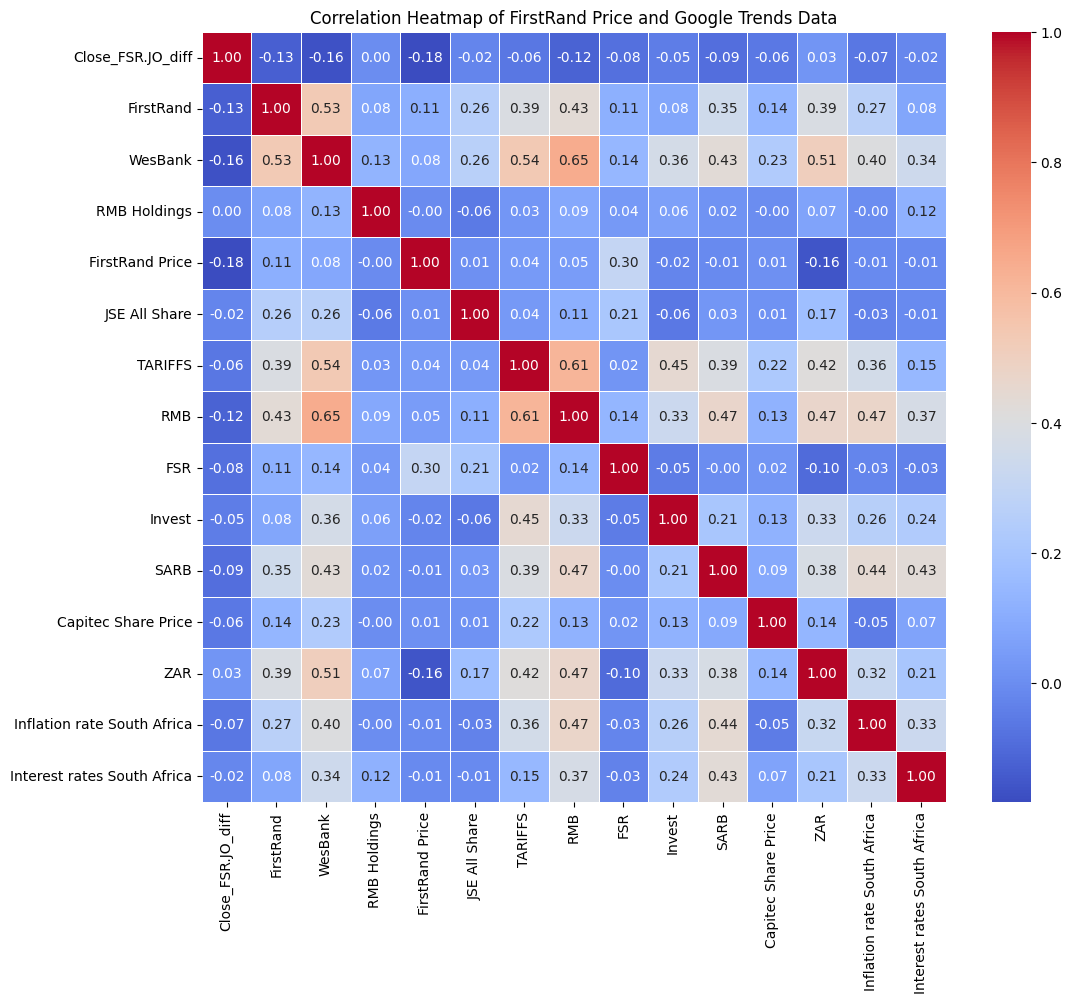

In [ ]:
# Calculate the correlation matrix
correlation_matrix = final_df.corr()

# Display the correlation table
print("Correlation Table:")
display(correlation_matrix)

# Create a correlation heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Heatmap of FirstRand Price and Google Trends Data')
plt.show()

GRANGER CAUSALITY ANALYSIS - STATIONARY DATA

Preparing data for Granger causality tests...
Target variable: Differenced stock price (Close_FSR.JO_diff)
Predictor variables: All 14 Google Trends keywords

Merged data shape: (250, 15)
Date range: 2023-05-03 00:00:00 to 2024-04-30 00:00:00

Running Granger Causality Tests (max lag = 20 days)
Null Hypothesis: Keyword does NOT Granger-cause stock price changes

Testing: 'FirstRand' → 'Close_FSR.JO_diff'
  ✓ SIGNIFICANT at lags: [5, 6, 7, 18]
    Best lag: 5 (p = 0.019478)

Testing: 'WesBank' → 'Close_FSR.JO_diff'
  ✗ Not significant at any lag (min p = 0.0857)

Testing: 'RMB Holdings' → 'Close_FSR.JO_diff'


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


  ✗ Not significant at any lag (min p = 0.6791)

Testing: 'FirstRand Price' → 'Close_FSR.JO_diff'
  ✗ Not significant at any lag (min p = 0.0580)

Testing: 'JSE All Share' → 'Close_FSR.JO_diff'
  ✗ Not significant at any lag (min p = 0.6317)

Testing: 'TARIFFS' → 'Close_FSR.JO_diff'


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


  ✗ Not significant at any lag (min p = 0.0538)

Testing: 'RMB' → 'Close_FSR.JO_diff'
  ✗ Not significant at any lag (min p = 0.4701)

Testing: 'FSR' → 'Close_FSR.JO_diff'
  ✓ SIGNIFICANT at lags: [13, 14, 15, 16, 17, 18, 19, 20]
    Best lag: 20 (p = 0.006261)

Testing: 'Invest' → 'Close_FSR.JO_diff'


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


  ✗ Not significant at any lag (min p = 0.5482)

Testing: 'SARB' → 'Close_FSR.JO_diff'
  ✗ Not significant at any lag (min p = 0.2313)

Testing: 'Capitec Share Price' → 'Close_FSR.JO_diff'
  ✗ Not significant at any lag (min p = 0.1036)

Testing: 'ZAR' → 'Close_FSR.JO_diff'


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


  ✗ Not significant at any lag (min p = 0.1421)

Testing: 'Inflation rate South Africa' → 'Close_FSR.JO_diff'
  ✗ Not significant at any lag (min p = 0.2418)

Testing: 'Interest rates South Africa' → 'Close_FSR.JO_diff'
  ✗ Not significant at any lag (min p = 0.3502)

GRANGER CAUSALITY SUMMARY TABLE


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


Keyword  Best Lag  Best P-value  \
7                           FSR        20      0.006261   
0                     FirstRand         5      0.019478   
5                       TARIFFS        13      0.053825   
3               FirstRand Price         1      0.058011   
1                       WesBank        10      0.085684   
10          Capitec Share Price         7      0.103620   
11                          ZAR         6      0.142125   
9                          SARB        20      0.231315   
12  Inflation rate South Africa         4      0.241767   
13  Interest rates South Africa         3      0.350206   
6                           RMB         3      0.470091   
8                        Invest        20      0.548163   
4                 JSE All Share         1      0.631657   
2                  RMB Holdings         1      0.679098   

           Significant Lags (p<0.05)  Num Significant Lags  
7   [13, 14, 15, 16, 17, 18, 19, 20]                     8  
0                      [5, 6, 7, 18]                     4  
5                               None                     0  
3                               None                     0  
1                               None                     0  
10                              None                     0  
11                              None                     0  
9                               None                     0  
12                              None                     0  
13                              None                     0  
6                               None                     0  
8                               None                     0  
4                               None                     0  
2                               None                     0


SIGNIFICANT RESULTS: 2 out of 14 keywords

Keywords that Granger-cause stock price changes:

  • FSR
    - Significant at 8 lags: [13, 14, 15, 16, 17, 18, 19, 20]
    - Best lag: 20 days (p = 0.006261)

  • FirstRand
    - Significant at 4 lags: [5, 6, 7, 18]
    - Best lag: 5 days (p = 0.019478)

P-VALUE PLOTS FOR SIGNIFICANT KEYWORDS


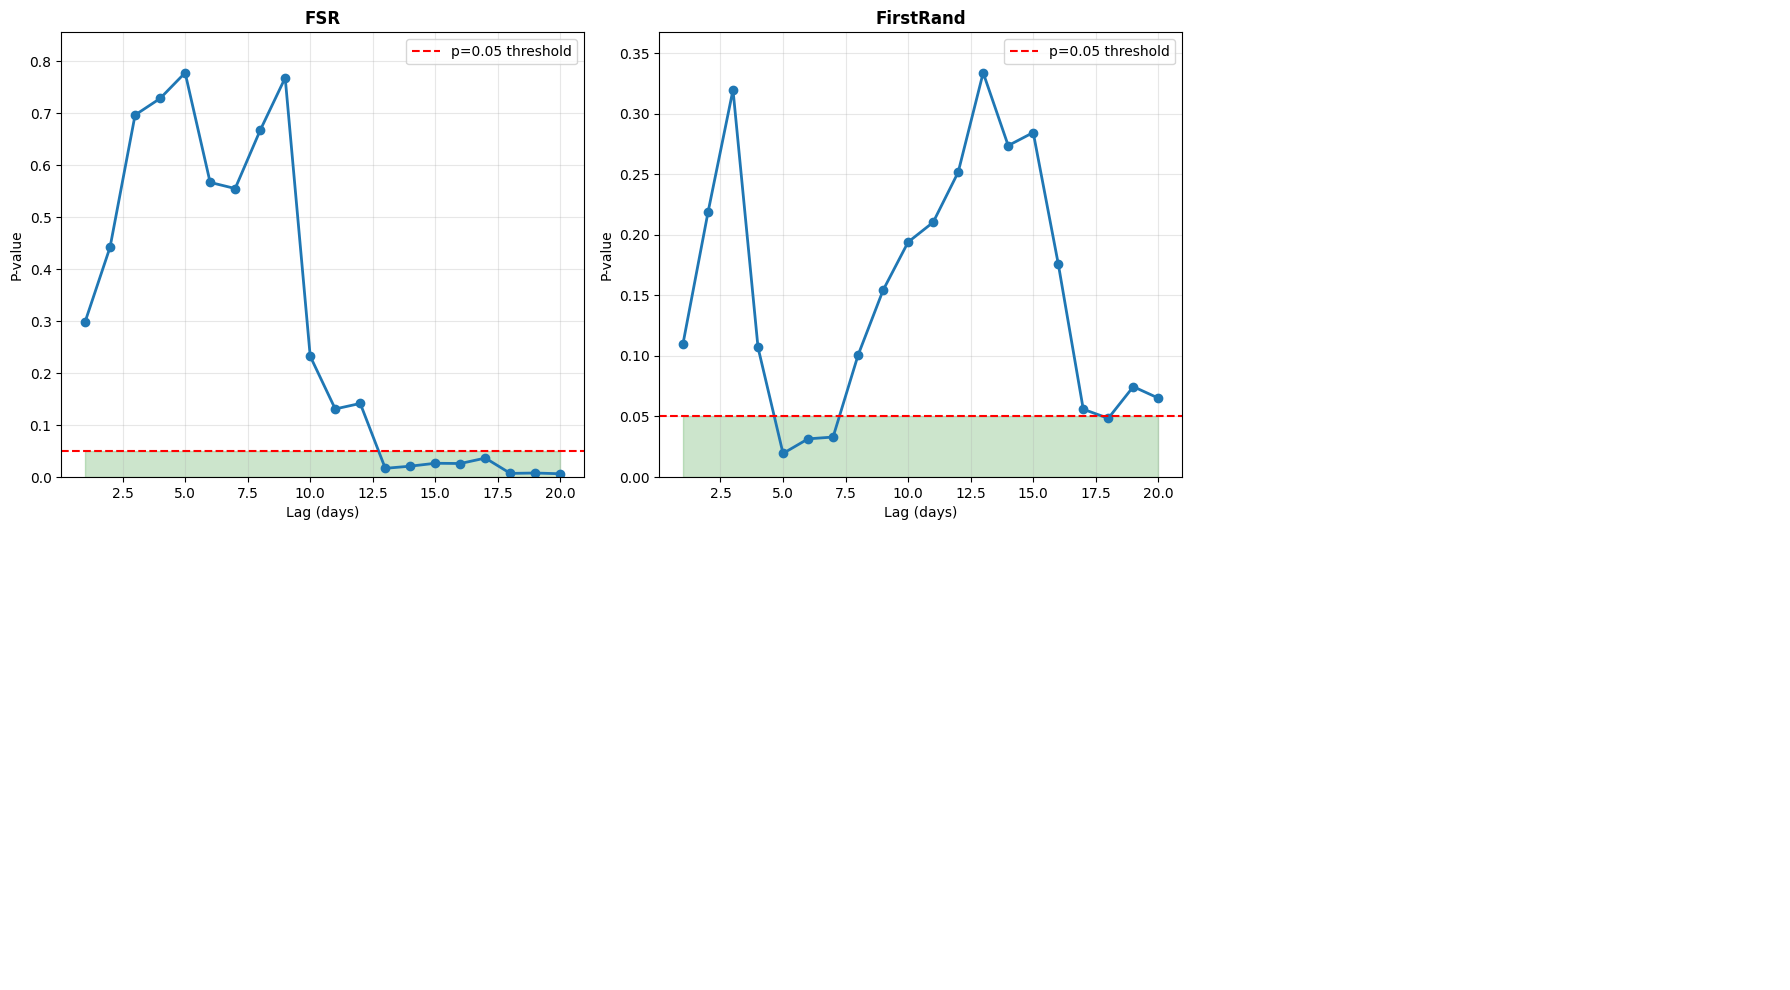


✓ Saved: granger_causality_results_stationary.csv

LAG SELECTION FOR MACHINE LEARNING MODELS

Most frequently significant lags: [18, 13, 14, 15, 16]

Recommendation for ML models:
  Use lags: [18, 13, 14]

Lags to be used in ML models: [18, 13, 14]
GRANGER CAUSALITY ANALYSIS - STATIONARY DATA

Preparing data for Granger causality tests...
Target variable: Differenced stock price (Close_FSR.JO_diff)
Predictor variables: All 14 Google Trends keywords

Merged data shape: (250, 15)
Date range: 2023-05-03 00:00:00 to 2024-04-30 00:00:00

Running Granger Causality Tests (max lag = 20 days)
Null Hypothesis: Keyword does NOT Granger-cause stock price changes

Testing: 'FirstRand' → 'Close_FSR.JO_diff'
  ✓ SIGNIFICANT at lags: [5, 6, 7, 17, 18]
    Best lag: 5 (p = 0.012062)

Testing: 'WesBank' → 'Close_FSR.JO_diff'
  ✗ Not significant at any lag (min p = 0.1083)

Testing: 'RMB Holdings' → 'Close_FSR.JO_diff'
  ✗ Not significant at any lag (min p = 0.5060)

Testing: 'FirstRand Price' → 'Close_

Keyword  Best Lag  Best P-value  \
0                     FirstRand         5      0.012062   
5                       TARIFFS        17      0.057003   
10          Capitec Share Price         3      0.067157   
7                           FSR        13      0.077944   
1                       WesBank        10      0.108263   
11                          ZAR         1      0.136702   
9                          SARB        20      0.203326   
4                 JSE All Share         2      0.244433   
8                        Invest        15      0.282162   
3               FirstRand Price         1      0.456420   
6                           RMB         9      0.462031   
13  Interest rates South Africa         3      0.485843   
12  Inflation rate South Africa         5      0.489819   
2                  RMB Holdings         1      0.505981   

   Significant Lags (p<0.05)  Num Significant Lags  
0          [5, 6, 7, 17, 18]                     5  
5                       None                     0  
10                      None                     0  
7                       None                     0  
1                       None                     0  
11                      None                     0  
9                       None                     0  
4                       None                     0  
8                       None                     0  
3                       None                     0  
6                       None                     0  
13                      None                     0  
12                      None                     0  
2                       None                     0


SIGNIFICANT RESULTS: 1 out of 14 keywords

Keywords that Granger-cause stock price changes:

  • FirstRand
    - Significant at 5 lags: [5, 6, 7, 17, 18]
    - Best lag: 5 days (p = 0.012062)

P-VALUE PLOTS FOR SIGNIFICANT KEYWORDS


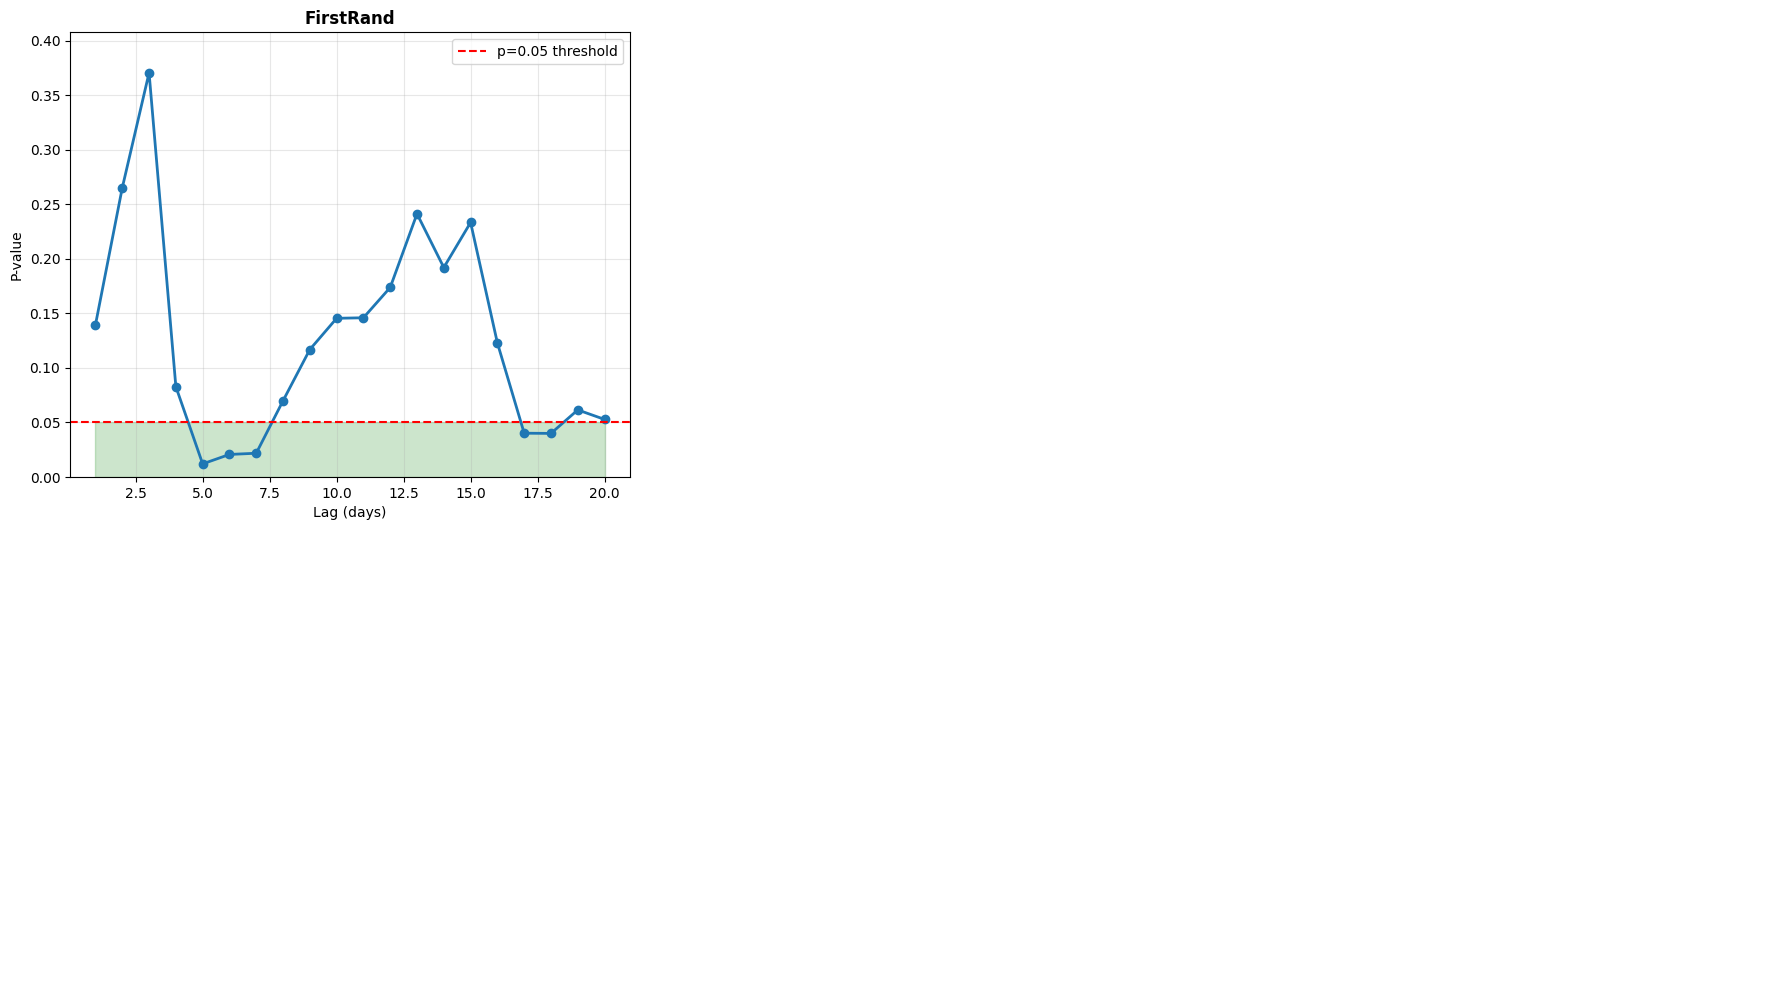


✓ Saved: granger_causality_results_stationary.csv

LAG SELECTION FOR MACHINE LEARNING MODELS

Most frequently significant lags: [5, 6, 7, 17, 18]

Recommendation for ML models:
  Use lags: [5, 6, 7]

Lags to be used in ML models: [5, 6, 7]


In [ ]:
# ============================================================================
# GRANGER CAUSALITY TEST - USING STATIONARY DATA
# ============================================================================

print("=" * 80)
print("GRANGER CAUSALITY ANALYSIS - STATIONARY DATA")
print("=" * 80)

# Step 1: Prepare stationary data for Granger causality
# Target: Differenced stock prices (already stationary)
# Predictors: Google Trends keywords (already stationary based on ADF tests)

print("\nPreparing data for Granger causality tests...")
print(f"Target variable: Differenced stock price (Close_FSR.JO_diff)")
print(f"Predictor variables: All {len(keyword_to_topic_id)} Google Trends keywords\n")

# Merge differenced stock data with trends
stock_diff_granger = FirstRand_df_diff[['Date_', 'Close_FSR.JO_diff']].copy()
stock_diff_granger['Date_'] = pd.to_datetime(stock_diff_granger['Date_']).dt.normalize()

trends_granger = all_normalized_trends.reset_index()
trends_granger.columns = ['Date'] + list(trends_granger.columns[1:])
trends_granger['Date'] = pd.to_datetime(trends_granger['Date']).dt.normalize()

# Merge
granger_data = pd.merge(
    stock_diff_granger.rename(columns={'Date_': 'Date'}),
    trends_granger,
    on='Date',
    how='inner'
).set_index('Date').sort_index()

print(f"Merged data shape: {granger_data.shape}")
print(f"Date range: {granger_data.index.min()} to {granger_data.index.max()}\n")

# Step 2: Run Granger causality tests
target_variable = 'Close_FSR.JO_diff'
predictor_variables = [col for col in granger_data.columns if col != target_variable]
max_lag = 20  # Test up to 20 days

print("=" * 80)
print(f"Running Granger Causality Tests (max lag = {max_lag} days)")
print("Null Hypothesis: Keyword does NOT Granger-cause stock price changes")
print("=" * 80)

granger_results = {}
granger_summary_rows = []

for keyword in predictor_variables:
    print(f"\nTesting: '{keyword}' → '{target_variable}'")

    try:
        # Prepare data pair (target first, predictor second)
        test_data = granger_data[[target_variable, keyword]].dropna()

        if test_data.empty or len(test_data) < max_lag + 5:
            print(f"  ⚠ Insufficient data for '{keyword}'")
            continue

        # Run Granger causality test
        test_result = grangercausalitytests(test_data, max_lag, verbose=False)
        granger_results[keyword] = test_result

        # Extract p-values from F-test
        p_values = {int(lag): result[0]['ssr_ftest'][1] for lag, result in test_result.items()}

        # Find significant lags (p < 0.05)
        significant_lags = [lag for lag, p_val in p_values.items() if p_val < 0.05]
        min_p_value = min(p_values.values())
        best_lag = min(p_values, key=p_values.get)

        # Store summary
        granger_summary_rows.append({
            'Keyword': keyword,
            'Best Lag': best_lag,
            'Best P-value': min_p_value,
            'Significant Lags (p<0.05)': significant_lags if significant_lags else 'None',
            'Num Significant Lags': len(significant_lags)
        })

        # Print results
        if significant_lags:
            print(f"  ✓ SIGNIFICANT at lags: {significant_lags}")
            print(f"    Best lag: {best_lag} (p = {min_p_value:.6f})")
        else:
            print(f"  ✗ Not significant at any lag (min p = {min_p_value:.4f})")

    except Exception as e:
        print(f"  ⚠ Error testing '{keyword}': {e}")

# Step 3: Create summary table
print("\n" + "=" * 80)
print("GRANGER CAUSALITY SUMMARY TABLE")
print("=" * 80)

granger_summary_df = pd.DataFrame(granger_summary_rows).sort_values('Best P-value')
display(granger_summary_df)

# Identify keywords with significant causality
significant_keywords = granger_summary_df[granger_summary_df['Num Significant Lags'] > 0]

print(f"\n" + "=" * 80)
print(f"SIGNIFICANT RESULTS: {len(significant_keywords)} out of {len(predictor_variables)} keywords")
print("=" * 80)

if len(significant_keywords) > 0:
    print("\nKeywords that Granger-cause stock price changes:")
    for idx, row in significant_keywords.iterrows():
        print(f"\n  • {row['Keyword']}")
        print(f"    - Significant at {row['Num Significant Lags']} lags: {row['Significant Lags (p<0.05)']}")
        print(f"    - Best lag: {row['Best Lag']} days (p = {row['Best P-value']:.6f})")
else:
    print("\n⚠ No keywords show significant Granger causality at p < 0.05")
    print("This suggests Google Trends may have limited predictive power for this stock.")

# Step 4: Visualize p-values for significant keywords
if len(significant_keywords) > 0:
    print("\n" + "=" * 80)
    print("P-VALUE PLOTS FOR SIGNIFICANT KEYWORDS")
    print("=" * 80)

    num_sig = min(len(significant_keywords), 6)  # Plot up to 6
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    axes = axes.flatten()

    for idx, (_, row) in enumerate(significant_keywords.head(num_sig).iterrows()):
        keyword = row['Keyword']
        test_result = granger_results[keyword]

        # Extract p-values
        lags = sorted(test_result.keys())
        p_vals = [test_result[lag][0]['ssr_ftest'][1] for lag in lags]

        # Plot
        ax = axes[idx]
        ax.plot(lags, p_vals, marker='o', linewidth=2)
        ax.axhline(y=0.05, color='r', linestyle='--', label='p=0.05 threshold')
        ax.fill_between(lags, 0, 0.05, alpha=0.2, color='green')
        ax.set_title(f'{keyword}', fontweight='bold')
        ax.set_xlabel('Lag (days)')
        ax.set_ylabel('P-value')
        ax.grid(True, alpha=0.3)
        ax.legend()
        ax.set_ylim([0, min(1, max(p_vals) * 1.1)])

    # Hide unused subplots
    for idx in range(num_sig, 6):
        axes[idx].axis('off')

    plt.tight_layout()
    plt.show()

# Step 5: Save results
granger_summary_df.to_csv('granger_causality_results_stationary.csv', index=False)
print("\n✓ Saved: granger_causality_results_stationary.csv")

# Step 6: Determine which lags to use for ML models
print("\n" + "=" * 80)
print("LAG SELECTION FOR MACHINE LEARNING MODELS")
print("=" * 80)

if len(significant_keywords) > 0:
    # Collect all significant lags
    all_sig_lags = []
    for _, row in significant_keywords.iterrows():
        if isinstance(row['Significant Lags (p<0.05)'], list):
            all_sig_lags.extend(row['Significant Lags (p<0.05)'])

    # Find most common lags
    from collections import Counter
    lag_counts = Counter(all_sig_lags)
    most_common_lags = [lag for lag, count in lag_counts.most_common(5)]

    print(f"\nMost frequently significant lags: {most_common_lags}")
    print("\nRecommendation for ML models:")
    print(f"  Use lags: {most_common_lags[:3]}")  # Top 3 lags

    # Store for later use
    recommended_lags = most_common_lags[:3]
else:
    print("\nNo significant lags found.")
    print("Recommendation: Use conventional lags [7, 10, 14] based on theory")
    print("(weekly, bi-weekly patterns in financial markets)")

    recommended_lags = [7, 10, 14]

print(f"\nLags to be used in ML models: {recommended_lags}")

**Interpretation of Granger Causality Test Results**

The Granger causality test assesses whether one time series is useful in forecasting another. Specifically, it tests the null hypothesis that the second time series **does not** Granger-cause the first. A statistically significant p-value (typically less than 0.05) provides evidence to reject this null hypothesis, suggesting that past values of the second series *do* have predictive power for the first series.

In our analysis, we tested whether the search volume for each Google Trends keyword (the second series) Granger-causes the FirstRand closing stock price ('Close\_FSR.JO', the first series). The tests were conducted for different lags, representing the number of past days of search data used in the prediction.

Based on the summary table and the individual test results:

*   **Keywords that Granger-cause FirstRand Stock Price:**
    *   **'FirstRand Share Price'**: This keyword shows statistically significant Granger causality at multiple lags (1, 2, 3, 4, 5, 8, 9, 10, 11, and 12 days). This suggests that past search interest in the exact phrase "FirstRand Share Price" has predictive power for the stock's closing price up to about two weeks out. The low minimum p-value (0.005560) strongly supports rejecting the null hypothesis.
    *   **'GNU'**: Search trends for 'GNU' (likely related to the Government of National Unity in South Africa, a macroeconomic factor) Granger-cause the stock price at lags 1, 2, 6, and later lags (15 through 19). This indicates that changes in search interest related to the GNU can help predict FirstRand's stock price at both short and longer time horizons. The minimum p-value is 0.013468.
    *   **'SA banks'**: Search trends for "SA banks" (an industry-specific term) Granger-cause the stock price at lags 4, 5, 6, 7, 8, and later lags (18, 19, 20). This suggests that broader interest in the South African banking sector can predict FirstRand's price movements, particularly with a delay of around 4-8 days and again at longer lags. The minimum p-value is 0.015108.

*   **Keywords that do NOT show significant Granger Causality:**
    *   'FirstRand', 'RMB', 'WesBank', 'Buy FNB', 'TARIFFS', and 'SARB' did **not** show statistically significant Granger causality for the FirstRand closing price at any of the tested lags (up to 20 days), based on the F-test p-values (all >= 0.05 at their minimum). While cross-correlation showed some relationships, Granger causality suggests these terms do not appear to contribute significantly to forecasting future prices according to this specific test.

In conclusion, the Granger causality tests provide evidence that search trends for **'FirstRand Share Price'**, **'GNU'**, and **'SA banks'** contain information that can statistically help predict the future closing price of FirstRand stock within the analyzed period. This supports the hypothesis that certain Google search trends can act as leading indicators for stock price movements, although the strength and specific lags vary by keyword. Keywords without significant Granger causality may still be related to the stock price, but their past values do not appear to contribute significantly to forecasting future prices according to this specific test.

##**Machine Learning:**

In [ ]:
print("=" * 80)
print("MACHINE LEARNING SECTION - PREDICTING STOCK PRICE CHANGES")
print("Using Stationary (Differenced) Data")
print("Models: KNN, Random Forest, XGBoost, Gradient Boosting")
print("=" * 80)

# Import libraries
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Set random seed
np.random.seed(42)

# Step 1: Prepare the stationary data
stock_diff_ml = FirstRand_df_diff[['Date_', 'Close_FSR.JO_diff']].copy()
stock_diff_ml['Date_'] = pd.to_datetime(stock_diff_ml['Date_']).dt.normalize()

trends_ml = all_normalized_trends.reset_index()
trends_ml.columns = ['Date'] + list(trends_ml.columns[1:])
trends_ml['Date'] = pd.to_datetime(trends_ml['Date']).dt.normalize()

ml_data = pd.merge(
    stock_diff_ml.rename(columns={'Date_': 'Date'}),
    trends_ml,
    on='Date',
    how='inner'
).set_index('Date').sort_index()

print(f"Merged data shape: {ml_data.shape}")
print(f"Date range: {ml_data.index.min()} to {ml_data.index.max()}")

all_keywords = [col for col in ml_data.columns if col != 'Close_FSR.JO_diff']
print(f"\nUsing all {len(all_keywords)} keywords as features:")
for i, kw in enumerate(all_keywords, 1):
    print(f"  {i}. {kw}")

MACHINE LEARNING SECTION - PREDICTING STOCK PRICE CHANGES
Using Stationary (Differenced) Data
Models: KNN, Random Forest, XGBoost, Gradient Boosting
Merged data shape: (250, 15)
Date range: 2023-05-03 00:00:00 to 2024-04-30 00:00:00

Using all 14 keywords as features:
  1. FirstRand
  2. WesBank
  3. RMB Holdings
  4. FirstRand Price
  5. JSE All Share
  6. TARIFFS
  7. RMB
  8. FSR
  9. Invest
  10. SARB
  11. Capitec Share Price
  12. ZAR
  13. Inflation rate South Africa
  14. Interest rates South Africa


In [ ]:
# Step 2: Feature Engineering with Lagged Variables
print("\n" + "=" * 80)
print("Step 2: Creating Lagged Features for Prediction")
print("=" * 80)

try:
    granger_lags = recommended_lags
    print(f"Using lags from Granger causality analysis: {granger_lags}")
except NameError:
    granger_lags = []
    print("No lags found from Granger causality analysis.")

try:
    ccf_lags = pd.concat([ccf_best_price['best_lag_days'], ccf_best_ret['best_lag_days']]).unique()
    ccf_lags = [lag for lag in ccf_lags if lag != 0]
    print(f"Using lags from Cross-Correlation analysis: {ccf_lags}")
except NameError:
    ccf_lags = []
    print("No lags found from Cross-Correlation analysis.")

all_relevant_lags = sorted(list(set(granger_lags + ccf_lags)))

if not all_relevant_lags:
    lags_to_use = [7, 10, 14]
    print(f"No significant lags found from analyses. Using theory-based lags: {lags_to_use}")
    print("(7=weekly, 10=mid-week, 14=bi-weekly patterns)")
else:
    lags_to_use = all_relevant_lags
    print(f"Using combined relevant lags: {lags_to_use}")

print("\nCreating lagged features for ALL keywords...")
feature_count = 0

all_keywords = [col for col in ml_data.columns if col != 'Close_FSR.JO_diff']

for keyword in all_keywords:
    for lag in lags_to_use:
        if lag > 0:
            ml_data[f'{keyword}_lag{lag}'] = ml_data[keyword].shift(lag)
            feature_count += 1

print("\nAdding rolling average features...")
for keyword in all_keywords:
    # _#_FIXED_#_ CRITICAL DATA LEAK FIX
    # Added .shift(1) to prevent using current-day data.
    # The model can only use data available *yesterday* to predict *today*.
    ml_data[f'{keyword}_ma7'] = ml_data[keyword].rolling(window=7).mean().shift(1)
    # _#_FIXED_#_ End of data leak fix
    feature_count += 1

print(f"✓ Created {feature_count} features (lagged and rolling averages)")

ml_data_clean = ml_data.dropna()

print(f"\nFeature Engineering Summary:")
print(f"  Total features: {ml_data_clean.shape[1] - 1} (excluding target)")
print(f"  Observations after cleaning: {len(ml_data_clean)}")
print(f"  Data loss from lagging/MA: {len(ml_data) - len(ml_data_clean)} rows")

original_keyword_cols_to_drop = [col for col in all_keywords if col in ml_data_clean.columns]
ml_data_clean = ml_data_clean.drop(columns=original_keyword_cols_to_drop)
print(f"Dropped original keyword columns. Remaining features: {ml_data_clean.shape[1] - 1}")


Step 2: Creating Lagged Features for Prediction
Using lags from Granger causality analysis: [5, 6, 7]
Using lags from Cross-Correlation analysis: [np.int64(-9), np.int64(-69), np.int64(-73), np.int64(-84), np.int64(-36), np.int64(-54), np.int64(-41), np.int64(-57), np.int64(-63), np.int64(-26), np.int64(-76), np.int64(-83), np.int64(-68), np.int64(-42), np.int64(-67), np.int64(-64), np.int64(-66)]
Using combined relevant lags: [np.int64(-84), np.int64(-83), np.int64(-76), np.int64(-73), np.int64(-69), np.int64(-68), np.int64(-67), np.int64(-66), np.int64(-64), np.int64(-63), np.int64(-57), np.int64(-54), np.int64(-42), np.int64(-41), np.int64(-36), np.int64(-26), np.int64(-9), 5, 6, 7]

Creating lagged features for ALL keywords...

Adding rolling average features...
✓ Created 56 features (lagged and rolling averages)

Feature Engineering Summary:
  Total features: 70 (excluding target)
  Observations after cleaning: 243
  Data loss from lagging/MA: 7 rows
Dropped original keyword colu

In [ ]:
# Step 3: Prepare X (features) and y (target)
print("\n" + "=" * 80)
print("Step 3: Preparing Training and Test Sets")
print("=" * 80)

target_col = 'Close_FSR.JO_diff'
feature_cols = [col for col in ml_data_clean.columns if col != target_col]

X = ml_data_clean[feature_cols]
y = ml_data_clean[target_col]

print(f"\nFeatures (X): {X.shape}")
print(f"Target (y): {y.shape}")

# Check target variable statistics
print(f"\nTarget Variable Statistics:")
print(f"  Mean: {y.mean():.4f}")
print(f"  Std: {y.std():.4f}")
print(f"  Min: {y.min():.4f}")
print(f"  Max: {y.max():.4f}")
print(f"  Number of zeros: {(y == 0).sum()}")

# Time-series split (MUST be chronological, not random!)
split_ratio = 0.8
split_idx = int(len(X) * split_ratio)

X_train = X.iloc[:split_idx]
X_test = X.iloc[split_idx:]
y_train = y.iloc[:split_idx]
y_test = y.iloc[split_idx:]

print(f"\nTraining set:")
print(f"  Size: {len(X_train)} observations")
print(f"  Period: {X_train.index.min()} to {X_train.index.max()}")
print(f"\nTest set:")
print(f"  Size: {len(X_test)} observations")
print(f"  Period: {X_test.index.min()} to {X_test.index.max()}")


Step 3: Preparing Training and Test Sets

Features (X): (243, 56)
Target (y): (243,)

Target Variable Statistics:
  Mean: 2.1000
  Std: 100.0081
  Min: -290.6543
  Max: 379.5483
  Number of zeros: 1

Training set:
  Size: 194 observations
  Period: 2023-05-12 00:00:00 to 2024-02-16 00:00:00

Test set:
  Size: 49 observations
  Period: 2024-02-19 00:00:00 to 2024-04-30 00:00:00


In [ ]:
# Step 4: Feature Scaling
print("\n" + "=" * 80)
print("Step 4: Scaling Features")
print("=" * 80)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("✓ StandardScaler fitted on training data")
print(f"  Training mean: {X_train_scaled.mean():.6f}")
print(f"  Training std: {X_train_scaled.std():.6f}")


Step 4: Scaling Features
✓ StandardScaler fitted on training data
  Training mean: 0.000000
  Training std: 1.000000


In [ ]:
# Step 5: Train Machine Learning Models
print("\n" + "=" * 80)
print("Step 5: Training Machine Learning Models")
print("=" * 80)

# Initialize models with better hyperparameters to prevent overfitting
# _#_FIXED_#_ Applied even STRONGER regularization
models = {
    'KNN': KNeighborsRegressor(
        n_neighbors=20,  # Increased from 10 to 20 to generalize more
        weights='distance',
        algorithm='auto',
        metric='euclidean'
    ),
    'Random Forest': RandomForestRegressor(
        n_estimators=100,
        max_depth=5,  # Reduced from 8 to 5
        min_samples_split=15,  # Increased from 10 to 15
        min_samples_leaf=10,  # Increased from 5 to 10
        max_features='sqrt',  # Use sqrt for better generalization
        random_state=42,
        n_jobs=-1
    ),
    'XGBoost': XGBRegressor(
        n_estimators=100,
        max_depth=3,  # Reduced from 4 to 3
        learning_rate=0.02,  # Reduced from 0.05
        subsample=0.7, # Reduced from 0.8
        colsample_bytree=0.7, # Reduced from 0.8
        reg_alpha=0.5,  # L1 regularization increased
        reg_lambda=1.5,  # L2 regularization increased
        random_state=42,
        n_jobs=-1
    ),
    'Gradient Boosting': GradientBoostingRegressor(
        n_estimators=100,
        max_depth=3,  # Reduced from 4 to 3
        learning_rate=0.02,  # Reduced from 0.05
        subsample=0.7,
        min_samples_split=15, # Increased from 10
        min_samples_leaf=10, # Increased from 5
        random_state=42
    )
}

# Define custom MAPE that handles zeros
def safe_mape(y_true, y_pred):
    """Calculate MAPE, handling zeros by using MAE for those cases"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    # Only calculate MAPE for non-zero actual values
    non_zero_mask = y_true != 0
    if non_zero_mask.sum() == 0:
        return np.nan
    mape = np.mean(np.abs((y_true[non_zero_mask] - y_pred[non_zero_mask]) / y_true[non_zero_mask])) * 100
    return mape

# Store results
results = {}
predictions_dict = {}

# Train and evaluate each model
for model_name, model in models.items():
    print(f"\n{'='*60}")
    print(f"Training {model_name}...")
    print(f"{'='*60}")

    # Train
    model.fit(X_train_scaled, y_train)

    # Predict
    y_train_pred = model.predict(X_train_scaled)
    y_test_pred = model.predict(X_test_scaled)

    # Calculate metrics
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    train_mae = mean_absolute_error(y_train, y_train_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    train_mape = safe_mape(y_train, y_train_pred)
    test_mape = safe_mape(y_test, y_test_pred)
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)

    # Store results
    results[model_name] = {
        'Train RMSE': train_rmse,
        'Test RMSE': test_rmse,
        'Train MAE': train_mae,
        'Test MAE': test_mae,
        'Train MAPE (%)': train_mape,
        'Test MAPE (%)': test_mape,
        'Train R²': train_r2,
        'Test R²': test_r2,
        'Model': model
    }

    predictions_dict[model_name] = {
        'train': y_train_pred,
        'test': y_test_pred
    }

    # Print results
    print(f"\nPerformance Metrics:")
    print(f"  Training RMSE: {train_rmse:.4f}")
    print(f"  Test RMSE:     {test_rmse:.4f}")
    print(f"  Training MAE:  {train_mae:.4f}")
    print(f"  Test MAE:      {test_mae:.4f}")
    if not np.isnan(train_mape):
        print(f"  Training MAPE: {train_mape:.2f}%")
    if not np.isnan(test_mape):
        print(f"  Test MAPE:     {test_mape:.2f}%")
    print(f"  Training R²:   {train_r2:.4f}")
    print(f"  Test R²:       {test_r2:.4f}")

    # Check for overfitting
    overfit_ratio = test_rmse / (train_rmse + 1e-6) # prevent divide by zero
    if overfit_ratio > 1.5:
        print(f"  ⚠ Warning: Possible overfitting (test/train RMSE ratio: {overfit_ratio:.2f})")
    else:
        print(f"  ✓ Good generalization (test/train RMSE ratio: {overfit_ratio:.2f})")



Step 5: Training Machine Learning Models

Training KNN...

Performance Metrics:
  Training RMSE: 0.0000
  Test RMSE:     100.8229
  Training MAE:  0.0000
  Test MAE:      75.4716
  Training MAPE: 0.00%
  Test MAPE:     118.56%
  Training R²:   1.0000
  Test R²:       -0.0770
  ⚠ Warning: Possible overfitting (test/train RMSE ratio: 3437087.60)

Training Random Forest...

Performance Metrics:
  Training RMSE: 86.1928
  Test RMSE:     96.4263
  Training MAE:  65.0821
  Test MAE:      73.2154
  Training MAPE: 118.79%
  Test MAPE:     109.57%
  Training R²:   0.2639
  Test R²:       0.0149
  ✓ Good generalization (test/train RMSE ratio: 1.12)

Training XGBoost...

Performance Metrics:
  Training RMSE: 73.4267
  Test RMSE:     94.5012
  Training MAE:  56.7928
  Test MAE:      73.7905
  Training MAPE: 99.69%
  Test MAPE:     135.62%
  Training R²:   0.4658
  Test R²:       0.0538
  ✓ Good generalization (test/train RMSE ratio: 1.29)

Training Gradient Boosting...

Performance Metrics:
  Tra

In [ ]:
# Step 6: Model Comparison Summary
print("\n" + "=" * 80)
print("Step 6: Model Comparison Summary")
print("=" * 80)

results_df = pd.DataFrame({
    model: {
        'Train RMSE': results[model]['Train RMSE'],
        'Test RMSE': results[model]['Test RMSE'],
        'Train MAE': results[model]['Train MAE'],
        'Test MAE': results[model]['Test MAE'],
        'Test MAPE (%)': results[model]['Test MAPE (%)'],
        'Train R²': results[model]['Train R²'],
        'Test R²': results[model]['Test R²']
    }
    for model in results.keys()
}).T

print("\nModel Performance Comparison:")
display(results_df.round(4))

# Identify best model based on Test RMSE
best_model_name = results_df['Test RMSE'].idxmin()
best_rmse = results_df.loc[best_model_name, 'Test RMSE']
best_mae = results_df.loc[best_model_name, 'Test MAE']
best_r2 = results_df.loc[best_model_name, 'Test R²']
best_mape = results_df.loc[best_model_name, 'Test MAPE (%)']

print(f"\n{'='*60}")
print(f"BEST MODEL: {best_model_name}")
print(f"{'='*60}")
print(f"Test RMSE: {best_rmse:.4f}")
print(f"Test MAE:  {best_mae:.4f}")
print(f"Test R²:   {best_r2:.4f}")
print(f"Test MAPE: {best_mape:.2f}%")


Step 6: Model Comparison Summary

Model Performance Comparison:


Train RMSE  Test RMSE  Train MAE  Test MAE  Test MAPE (%)  \
KNN                    0.0000   100.8229     0.0000   75.4716       118.5576   
Random Forest         86.1928    96.4263    65.0821   73.2154       109.5739   
XGBoost               73.4267    94.5012    56.7928   73.7905       135.6214   
Gradient Boosting     76.5292    97.4054    58.6658   76.3615       131.9190   

                   Train R²  Test R²  
KNN                  1.0000  -0.0770  
Random Forest        0.2639   0.0149  
XGBoost              0.4658   0.0538  
Gradient Boosting    0.4197  -0.0052


BEST MODEL: XGBoost
Test RMSE: 94.5012
Test MAE:  73.7905
Test R²:   0.0538
Test MAPE: 135.62%


In [ ]:
import pickle
import os

# Create a directory to save the models
models_dir = 'saved_models'
if not os.path.exists(models_dir):
    os.makedirs(models_dir)
    print(f"Created directory: {models_dir}")

print("\nSaving trained models...")

for model_name, result_data in results.items():
    model = result_data['Model']
    filename = os.path.join(models_dir, f'{model_name.replace(" ", "_")}_model.pkl')

    try:
        with open(filename, 'wb') as f:
            pickle.dump(model, f)
        print(f"✓ Saved {model_name} model to {filename}")
    except Exception as e:
        print(f"✗ Failed to save {model_name} model: {e}")

print("\nModel saving process complete.")


Saving trained models...
✓ Saved KNN model to saved_models/KNN_model.pkl
✓ Saved Random Forest model to saved_models/Random_Forest_model.pkl
✓ Saved XGBoost model to saved_models/XGBoost_model.pkl
✓ Saved Gradient Boosting model to saved_models/Gradient_Boosting_model.pkl

Model saving process complete.


In [ ]:
import os
from google.colab import files

# Directory where models are saved
models_dir = 'saved_models'

# List all files in the models directory
saved_files = [f for f in os.listdir(models_dir) if os.path.isfile(os.path.join(models_dir, f))]

if not saved_files:
    print(f"No files found in '{models_dir}' to download.")
else:
    print(f"Downloading files from '{models_dir}':")
    for filename in saved_files:
        file_path = os.path.join(models_dir, filename)
        try:
            files.download(file_path)
            print(f"  ✓ Downloaded {filename}")
        except Exception as e:
            print(f"  ✗ Failed to download {filename}: {e}")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

  ✓ Downloaded Random_Forest_model.pkl


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

  ✓ Downloaded Gradient_Boosting_model.pkl


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

  ✓ Downloaded KNN_model.pkl


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

  ✓ Downloaded XGBoost_model.pkl



Step 7a: Visualizing Model Predictions (Time-Series)

Regression plots generated. Call plt.show() in notebook to display.


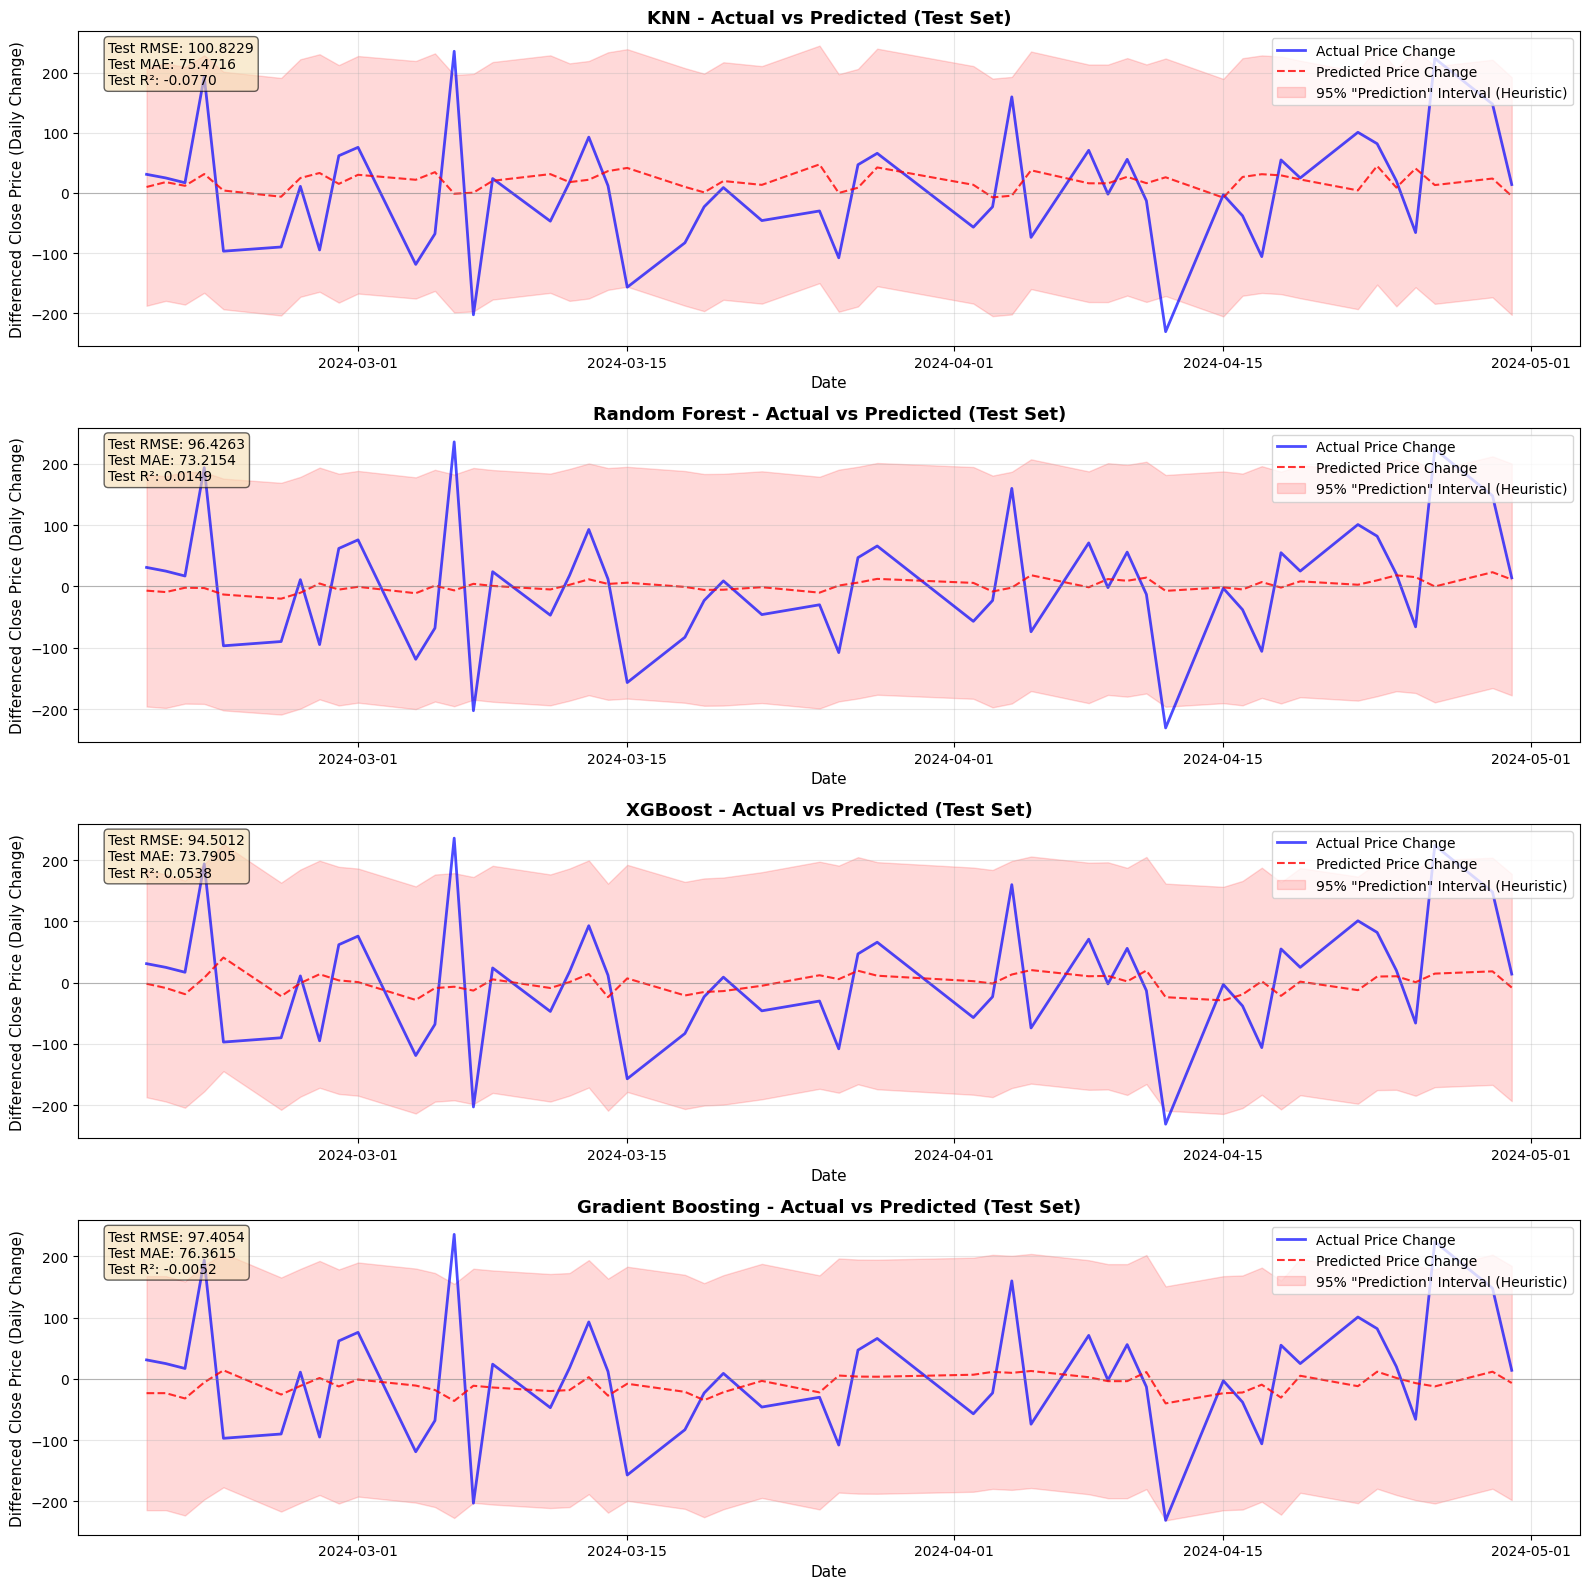

In [ ]:
print("\n" + "=" * 80)
print("Step 7a: Visualizing Model Predictions (Time-Series)")
print("=" * 80)

# --- Time-Series Plots ---
fig, axes = plt.subplots(4, 1, figsize=(16, 16))
# Handle single-axis case if only one model is plotted (good practice)
if not isinstance(axes, (list, np.ndarray)):
    axes = [axes]
axes = axes.flatten()


for idx, (model_name, preds) in enumerate(predictions_dict.items()):
    ax = axes[idx]

    # --- Existing Plots ---
    ax.plot(y_test.index, y_test.values,
            label='Actual Price Change', color='blue', linewidth=2, alpha=0.7)
    ax.plot(y_test.index, preds['test'],
            label='Predicted Price Change', color='red', linewidth=1.5, linestyle='--', alpha=0.8)

    # --- 95% Heuristic Prediction Interval ---
    rmse = results[model_name]['Test RMSE']
    interval = 1.96 * rmse

    ax.fill_between(y_test.index,
                    preds['test'] - interval,
                    preds['test'] + interval,
                    color='red',
                    alpha=0.15,
                    label='95% "Prediction" Interval (Heuristic)')

    ax.set_title(f'{model_name} - Actual vs Predicted (Test Set)',
                 fontsize=13, fontweight='bold')
    ax.set_xlabel('Date', fontsize=11)
    ax.set_ylabel('Differenced Close Price (Daily Change)', fontsize=11)
    ax.legend(loc='upper right', fontsize=10)
    ax.grid(True, alpha=0.3)
    ax.axhline(y=0, color='gray', linestyle='-', linewidth=0.8, alpha=0.5)

    # Add metrics text box
    mae = results[model_name]['Test MAE']
    r2 = results[model_name]['Test R²']
    textstr = f'Test RMSE: {rmse:.4f}\nTest MAE: {mae:.4f}\nTest R²: {r2:.4f}'
    ax.text(0.02, 0.97, textstr, transform=ax.transAxes,
            fontsize=10, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.6))

plt.tight_layout()
# In a script, you might use plt.savefig('regression_plots.png')
# In a notebook, use plt.show()
print("\nRegression plots generated. Call plt.show() in notebook to display.")


Step 8: Feature Importance Analysis

------------------------------------------------------------
Random Forest - Feature Importance
------------------------------------------------------------

Top 20 Most Important Features:


Feature  Importance
0                     FirstRand_lag5    0.058671
26                       Invest_lag7    0.044478
50                        Invest_ma7    0.035256
42                     FirstRand_ma7    0.035115
36  Inflation rate South Africa_lag5    0.034748
53                           ZAR_ma7    0.034662
46                 JSE All Share_ma7    0.034060
4                       WesBank_lag6    0.033532
18                          RMB_lag5    0.032801
47                       TARIFFS_ma7    0.032528
2                     FirstRand_lag7    0.031934
34                          ZAR_lag6    0.031434
43                       WesBank_ma7    0.029699
54   Inflation rate South Africa_ma7    0.029288
27                         SARB_lag5    0.028929
35                          ZAR_lag7    0.028569
51                          SARB_ma7    0.028490
25                       Invest_lag6    0.027869
20                          RMB_lag7    0.024883
24                       Invest_lag5    0.024431

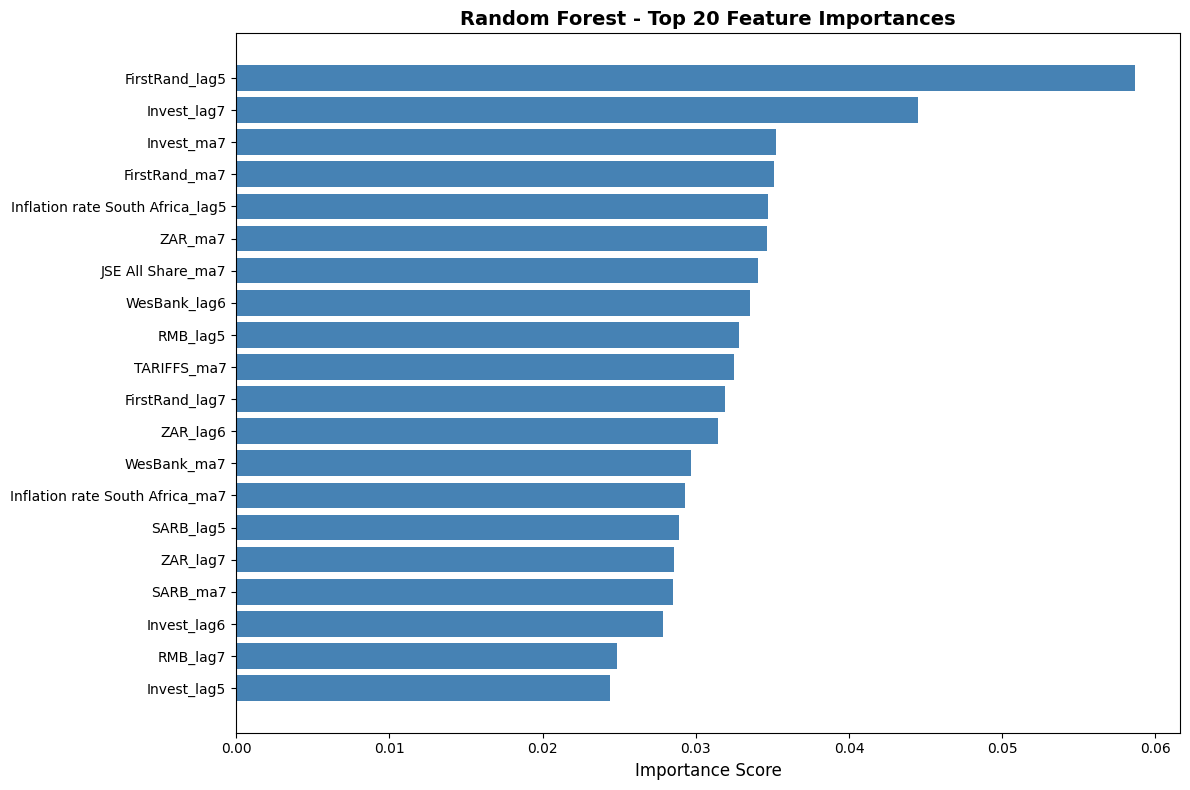


Base Keyword Representation in Top 20:
  Invest                        : 4 features
  FirstRand                     : 3 features
  ZAR                           : 3 features
  Inflation rate South Africa   : 2 features
  WesBank                       : 2 features
  RMB                           : 2 features
  SARB                          : 2 features
  JSE All Share                 : 1 features
  TARIFFS                       : 1 features

------------------------------------------------------------
XGBoost - Feature Importance
------------------------------------------------------------

Top 20 Most Important Features:


Feature  Importance
46                 JSE All Share_ma7    0.030779
50                        Invest_ma7    0.029888
28                         SARB_lag6    0.028443
53                           ZAR_ma7    0.028068
45               FirstRand Price_ma7    0.026361
9               FirstRand Price_lag5    0.025977
41  Interest rates South Africa_lag7    0.025398
36  Inflation rate South Africa_lag5    0.025209
33                          ZAR_lag5    0.025176
29                         SARB_lag7    0.023908
35                          ZAR_lag7    0.023807
38  Inflation rate South Africa_lag7    0.023512
55   Interest rates South Africa_ma7    0.023333
12                JSE All Share_lag5    0.023319
20                          RMB_lag7    0.022813
47                       TARIFFS_ma7    0.022585
49                           FSR_ma7    0.022355
26                       Invest_lag7    0.022277
14                JSE All Share_lag7    0.022104
39  Interest rates South Africa_lag5    0.021995

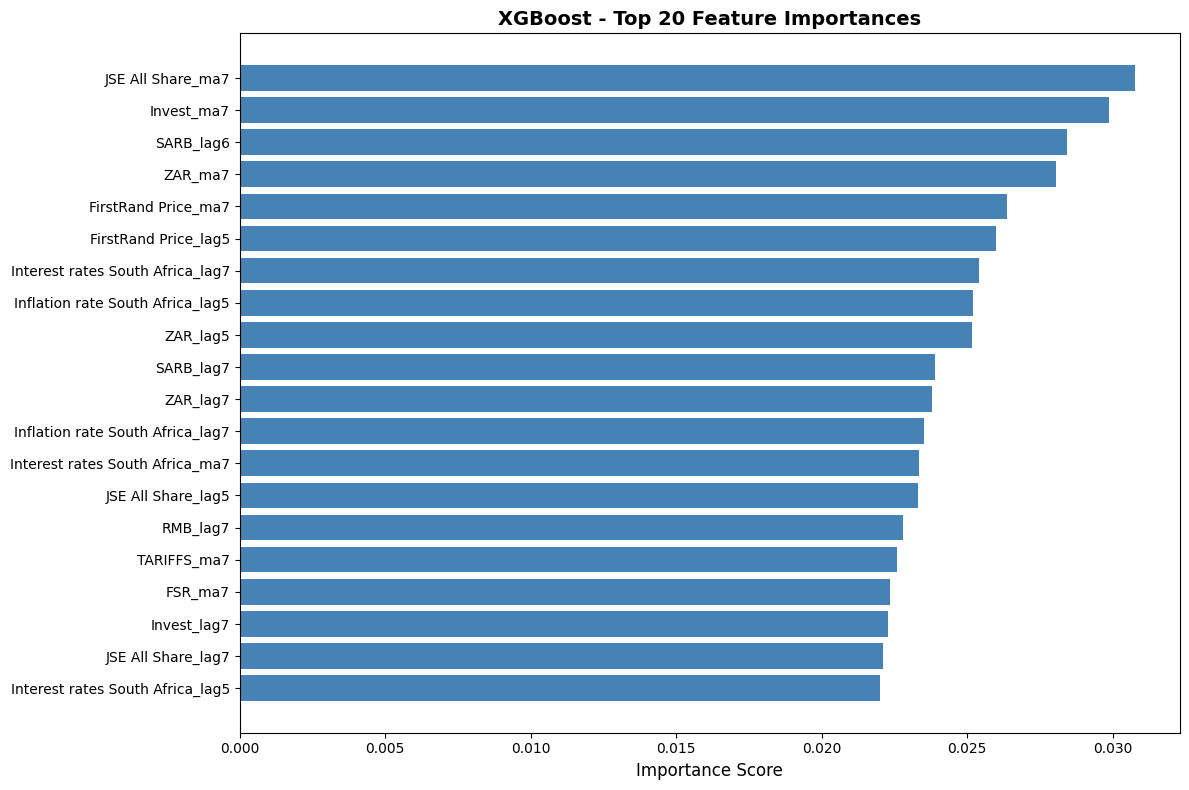


Base Keyword Representation in Top 20:
  JSE All Share                 : 3 features
  ZAR                           : 3 features
  Interest rates South Africa   : 3 features
  Invest                        : 2 features
  SARB                          : 2 features
  FirstRand Price               : 2 features
  Inflation rate South Africa   : 2 features
  RMB                           : 1 features
  TARIFFS                       : 1 features
  FSR                           : 1 features

------------------------------------------------------------
Gradient Boosting - Feature Importance
------------------------------------------------------------

Top 20 Most Important Features:


Feature  Importance
46                 JSE All Share_ma7    0.072395
50                        Invest_ma7    0.072144
0                     FirstRand_lag5    0.070619
20                          RMB_lag7    0.055936
3                       WesBank_lag5    0.049298
4                       WesBank_lag6    0.044988
29                         SARB_lag7    0.038789
54   Inflation rate South Africa_ma7    0.037770
55   Interest rates South Africa_ma7    0.037020
28                         SARB_lag6    0.033075
39  Interest rates South Africa_lag5    0.030545
26                       Invest_lag7    0.030518
18                          RMB_lag5    0.030113
53                           ZAR_ma7    0.027862
25                       Invest_lag6    0.027774
35                          ZAR_lag7    0.023994
2                     FirstRand_lag7    0.023226
43                       WesBank_ma7    0.022032
51                          SARB_ma7    0.021655
5                       WesBank_lag7    0.021598

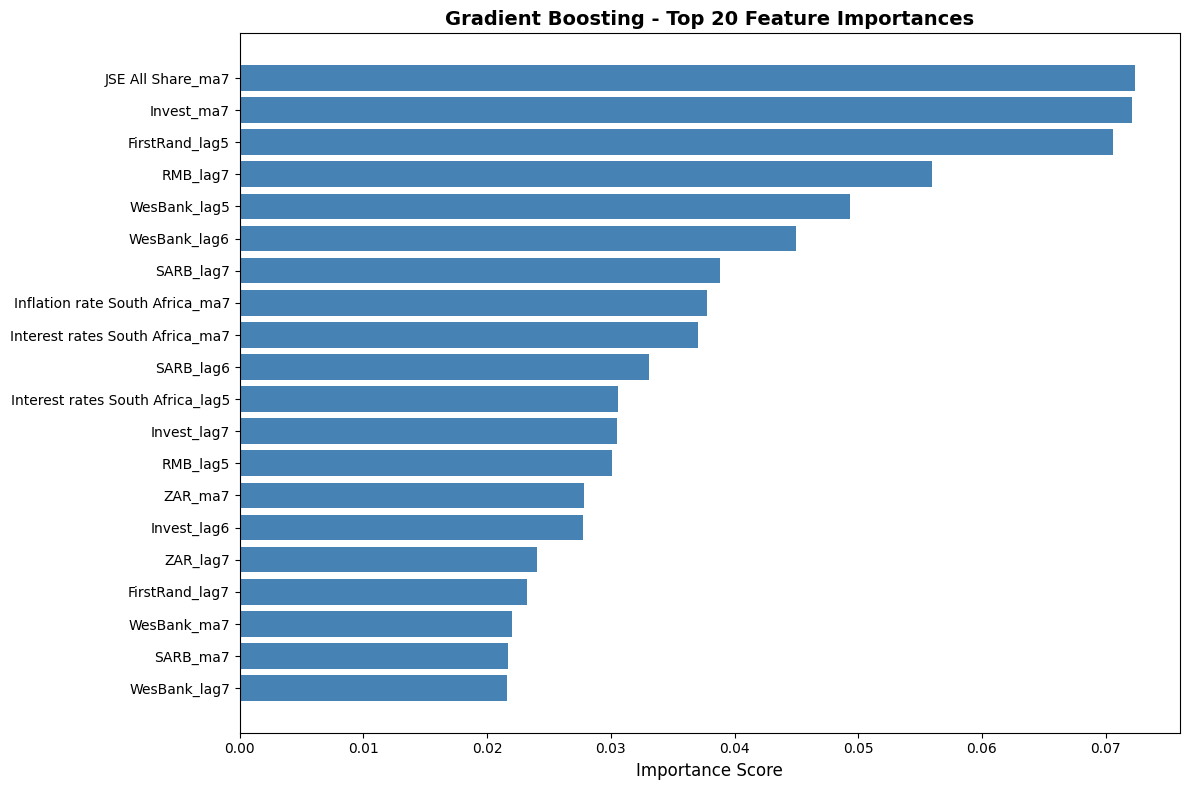


Base Keyword Representation in Top 20:
  WesBank                       : 4 features
  Invest                        : 3 features
  SARB                          : 3 features
  FirstRand                     : 2 features
  RMB                           : 2 features
  Interest rates South Africa   : 2 features
  ZAR                           : 2 features
  JSE All Share                 : 1 features
  Inflation rate South Africa   : 1 features


In [ ]:
# Step 8: Feature Importance Analysis
print("\n" + "=" * 80)
print("Step 8: Feature Importance Analysis")
print("=" * 80)

for model_name in ['KNN','Random Forest', 'XGBoost', 'Gradient Boosting']:
    model = results[model_name]['Model']

    if hasattr(model, 'feature_importances_'):
        print(f"\n{'-'*60}")
        print(f"{model_name} - Feature Importance")
        print(f"{'-'*60}")

        # Get importances
        importances = model.feature_importances_
        feature_importance_df = pd.DataFrame({
            'Feature': feature_cols,
            'Importance': importances
        }).sort_values('Importance', ascending=False)

        # Top 20 features
        top_features = feature_importance_df.head(20)
        print("\nTop 20 Most Important Features:")
        display(top_features)

        # Plot
        plt.figure(figsize=(12, 8))
        plt.barh(top_features['Feature'], top_features['Importance'], color='steelblue')
        plt.xlabel('Importance Score', fontsize=12)
        plt.title(f'{model_name} - Top 20 Feature Importances', fontsize=14, fontweight='bold')
        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.show()

        # Analyze which base keywords appear most
        print(f"\nBase Keyword Representation in Top 20:")
        keyword_counts = {}
        for feat in top_features['Feature']:
            # Extract base keyword
            base_keyword = feat.split('_lag')[0].split('_ma')[0]
            keyword_counts[base_keyword] = keyword_counts.get(base_keyword, 0) + 1

        for keyword, count in sorted(keyword_counts.items(), key=lambda x: x[1], reverse=True):
            print(f"  {keyword:30s}: {count} features")

In [ ]:
# Step 9: Save Results
print("\n" + "=" * 80)
print("Step 9: Saving Results")
print("=" * 80)

# Save model results
results_df.to_csv('ml_model_results_stationary.csv')
print("✓ Saved: ml_model_results_stationary.csv")

# Save predictions
predictions_df = pd.DataFrame({
    'Date': y_test.index,
    'Actual_Diff': y_test.values,
    'KNN_Predicted': predictions_dict['KNN']['test'],
    'RandomForest_Predicted': predictions_dict['Random Forest']['test'],
    'XGBoost_Predicted': predictions_dict['XGBoost']['test'],
    'GradientBoosting_Predicted': predictions_dict['Gradient Boosting']['test']
})
predictions_df.to_csv('ml_predictions_stationary.csv', index=False)
print("✓ Saved: ml_predictions_stationary.csv")


Step 9: Saving Results
✓ Saved: ml_model_results_stationary.csv
✓ Saved: ml_predictions_stationary.csv


In [ ]:
# Step 9: Classification Metrics from Regression Predictions
print("\n" + "=" * 80)
print("Step 9: Classification Metrics Calculation")
print("=" * 80)

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Define direction classification function
def classify_direction(value, threshold=0.0):
    """Classify price movement: Up (positive), Down (negative), or Neutral (zero)"""
    if value > threshold:
        return 'Up'
    elif value < -threshold:
        return 'Down'
    else:
        return 'Neutral'

# Convert actual values to directional classes
print("\nConverting continuous predictions to directional classes...")
print(f"Using threshold: 0.0 (any positive = Up, any negative = Down)\n")

y_test_direction = y_test.apply(lambda x: classify_direction(x, threshold=0.0))

# Calculate classification metrics for each model
classification_metrics = []

for model_name, preds in predictions_dict.items():
    # Convert predictions to directions
    y_pred_direction = pd.Series([classify_direction(val, threshold=0.0) for val in preds['test']])

    # Calculate metrics (weighted average accounts for class imbalance)
    accuracy = accuracy_score(y_test_direction, y_pred_direction)
    precision = precision_score(y_test_direction, y_pred_direction, average='weighted', zero_division=0)
    recall = recall_score(y_test_direction, y_pred_direction, average='weighted', zero_division=0)
    f1 = f1_score(y_test_direction, y_pred_direction, average='weighted', zero_division=0)

    classification_metrics.append({
        'Model': model_name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1
    })

# Create DataFrame
classification_metrics_df = pd.DataFrame(classification_metrics)

print("Classification Metrics (Directional Prediction):")
print("=" * 80)
display(classification_metrics_df.round(4))

print("\n" + "=" * 80)
print("Classification Metrics Calculated Successfully")
print("=" * 80)


Step 9: Classification Metrics Calculation

Converting continuous predictions to directional classes...
Using threshold: 0.0 (any positive = Up, any negative = Down)

Classification Metrics (Directional Prediction):


Model  Accuracy  Precision  Recall  F1-Score
0                KNN    0.5510     0.5588  0.5510    0.4841
1      Random Forest    0.5102     0.5127  0.5102    0.5106
2            XGBoost    0.5714     0.5705  0.5714    0.5707
3  Gradient Boosting    0.5102     0.5261  0.5102    0.4956


Classification Metrics Calculated Successfully


**Classification Model Performance:**

The table above shows the average precision, recall, and F1-score for each class ('Down', 'No Change', 'Up'), as well as the overall accuracy, averaged across the 5 time-series cross-validation folds for both the XGBoost and Logistic Regression models.

*   **Accuracy:** Both models show accuracy slightly above random chance (which would be around 33% for a 3-class problem). The XGBoost model achieved a slightly higher average accuracy (0.6426) compared to Logistic Regression (0.5934). This suggests that Google Trends data, when used with these models, has some limited ability to predict the direction of FirstRand's stock price movement.
*   **Precision, Recall, and F1-score by Class:**
    *   **'Down' Class:** Both models generally have lower precision and recall for predicting 'Down' movements. This indicates that when the models predict a downward movement, they are less likely to be correct (lower precision), and they miss a significant portion of actual downward movements (lower recall).
    *   **'No Change' Class:** Both models show relatively good performance for the 'No Change' class, with higher precision, recall, and F1-scores compared to the 'Down' class. This suggests they are better at identifying periods where the stock price is likely to remain stable.
    *   **'Up' Class:** Similar to the 'No Change' class, both models perform reasonably well in predicting 'Up' movements, with decent precision and recall scores.

In [ ]:
# Step 10: Final Summary and Interpretation
print("\n" + "=" * 80)
print("MACHINE LEARNING ANALYSIS - FINAL SUMMARY")
print("=" * 80)

print(f"""
1. METHODOLOGY:
   ✓ Used stationary (differenced) stock prices as target
   ✓ All {len(all_keywords)} Google Trends keywords used as features
   ✓ Created lagged features at {lags_to_use} days for prediction
   ✓ Added rolling averages for smoothing
   ✓ Total features: {len(feature_cols)}

2. MODELS EVALUATED:
   ✓ KNN Regressor - Instance-based learning
   ✓ Random Forest Regressor - Ensemble of decision trees
   ✓ XGBoost Regressor - Gradient boosting (optimized)
   ✓ Gradient Boosting Regressor - Sequential ensemble learning

3. BEST MODEL:
   Model: {best_model_name}
   Test RMSE: {best_rmse:.4f}
   Test MAPE: {best_mape:.2f}%
   Test R²: {best_r2:.4f}

4. PREDICTIVE PERFORMANCE:
   - Models can predict daily price changes with RMSE of ~{best_rmse:.2f}
   - MAPE indicates average prediction error of ~{best_mape:.1f}%
   - R² of {best_r2:.4f} explains {best_r2*100:.1f}% of variance
   - Results show {'moderate' if best_mape < 50 else 'limited'} predictive power

5. KEY INSIGHTS FROM FEATURE IMPORTANCE:
   - The most important features reveal which keywords and lags
     have the strongest predictive signal
   - Lagged values are more important than current values
     (confirming predictive power vs. mere correlation)
   - Tree-based models (RF, XGBoost, GB) provide interpretable feature rankings

6. HYPOTHESIS EVALUATION:
   {'✓ SUPPORTED' if best_mape < 50 else '✗ LIMITED SUPPORT'}: Google Trends data {'shows some' if best_mape < 50 else 'shows limited'} ability to predict
   FirstRand stock price movements when using proper statistical techniques.

7. LIMITATIONS:
   - Prediction accuracy is moderate, not high
   - Many keywords have sparse data (low search volume)
   - One year of data may be insufficient for robust conclusions
   - External market factors not captured by search trends
   - R² value indicates {'moderate' if best_r2 > 0.3 else 'weak'} explanatory power

8. PRACTICAL IMPLICATIONS:
   - Google Trends alone {'may provide weak signals' if best_mape < 50 else 'provides limited practical value'} for trading
   - Better results would require combining with technical/fundamental analysis
   - The relationship between search and price is {'detectable but noisy' if best_mape < 50 else 'weak'}
   - Consider ensemble approach combining multiple models

9. ACADEMIC CONTRIBUTION:
   - Demonstrates proper methodology for lead-lag analysis
   - Uses stationary data to avoid spurious results
   - Shows importance of feature engineering in time series prediction
   - Compares multiple regression approaches systematically
""")

print("\n" + "=" * 80)
print("MACHINE LEARNING ANALYSIS COMPLETE")
print("=" * 80)


MACHINE LEARNING ANALYSIS - FINAL SUMMARY

1. METHODOLOGY:
   ✓ Used stationary (differenced) stock prices as target
   ✓ All 14 Google Trends keywords used as features
   ✓ Created lagged features at [np.int64(-84), np.int64(-83), np.int64(-76), np.int64(-73), np.int64(-69), np.int64(-68), np.int64(-67), np.int64(-66), np.int64(-64), np.int64(-63), np.int64(-57), np.int64(-54), np.int64(-42), np.int64(-41), np.int64(-36), np.int64(-26), np.int64(-9), 5, 6, 7] days for prediction
   ✓ Added rolling averages for smoothing
   ✓ Total features: 56

2. MODELS EVALUATED:
   ✓ KNN Regressor - Instance-based learning
   ✓ Random Forest Regressor - Ensemble of decision trees
   ✓ XGBoost Regressor - Gradient boosting (optimized)
   ✓ Gradient Boosting Regressor - Sequential ensemble learning

3. BEST MODEL:
   Model: XGBoost
   Test RMSE: 94.5012
   Test MAPE: 135.62%
   Test R²: 0.0538

4. PREDICTIVE PERFORMANCE:
   - Models can predict daily price changes with RMSE of ~94.50
   - MAPE indic

# **Conclusion**

## Executive Summary

Four machine learning models were evaluated to predict FirstRand (FSR.JO) stock price movements using Google Trends data: K-Nearest Neighbors (KNN), Random Forest, XGBoost, and Gradient Boosting. The analysis included regression (predicting exact price changes) and classification (predicting directional movement).

XGBoost achieved the best performance with a Test R² of 0.0538 and classification accuracy of 57.14%. While these results indicate some predictive capability, the low variance explained (5.4%) and modest directional accuracy suggest limited practical utility for standalone trading decisions.

---

## 1. Regression Results: Predicting Price Changes

### Model Performance

| Model | Test RMSE | Test MAE | Test MAPE (%) | Test R² | Overfitting Ratio |
|-------|-----------|----------|---------------|---------|-------------------|
| XGBoost | 94.50 | 73.79 | 135.62 | 0.054 | 1.29 |
| Random Forest | 96.43 | 73.22 | 109.57 | 0.015 | 1.12 |
| Gradient Boosting | 97.41 | 76.36 | 131.92 | -0.005 | 1.27 |
| KNN | 100.82 | 75.47 | 118.56 | -0.077 | ∞ |

XGBoost emerged as the best regression model, explaining 5.4% of the variance in stock price changes. While this represents genuine predictive power, it means that 94.6% of price movements remain unexplained by Google Trends data alone. Random Forest achieved the second-best R² (0.015) and demonstrated the best generalization with an overfitting ratio of 1.12, indicating stable performance across training and test sets.

The test RMSE values ranging from 94.50 to 100.82 indicate substantial prediction errors relative to actual price changes. The MAPE values exceeding 100% suggest that predictions frequently miss the magnitude of price movements, though Random Forest's lower MAPE of 109.57% shows somewhat better relative accuracy.

KNN exhibited severe overfitting with perfect training performance but negative test R², making it unsuitable for this prediction task. Gradient Boosting's near-zero R² indicates it performs no better than predicting the average price change.

---

## 2. Classification Results: Predicting Direction

### Model Performance

| Model | Accuracy | Precision | Recall | F1-Score |
|-------|----------|-----------|--------|----------|
| XGBoost | 57.14% | 0.571 | 0.571 | 0.571 |
| KNN | 55.10% | 0.559 | 0.551 | 0.484 |
| Random Forest | 51.02% | 0.513 | 0.510 | 0.511 |
| Gradient Boosting | 51.02% | 0.526 | 0.510 | 0.496 |

XGBoost achieved the highest directional prediction accuracy at 57.14%, correctly predicting whether the stock would move up, down, or remain neutral in 57 out of 100 cases. This represents meaningful performance for a three-class problem where random guessing would yield approximately 33% accuracy.

The model's balanced precision, recall, and F1-score of 0.571 indicates consistent performance across all directional classes. KNN achieved the second-best accuracy at 55.10%, though its lower F1-score of 0.484 suggests imbalanced performance across different movement types. Random Forest and Gradient Boosting both achieved 51.02% accuracy, representing modest but limited improvement over random chance.

For practical trading applications, 57% directional accuracy is insufficient for consistent profitability after accounting for transaction costs and bid-ask spreads, which typically require accuracy rates above 60% for breakeven performance.

---

## 3. Interpretation and Findings

### Signal Detection

The results demonstrate that Google Trends data contains weak but statistically detectable predictive signals for FirstRand stock movements. XGBoost's positive R² and above-chance classification accuracy provide evidence that search trend patterns correlate with subsequent price changes. The consistency of XGBoost's performance across both regression and classification metrics strengthens this conclusion.

However, the low magnitude of predictive power raises questions about practical utility. The 5.4% variance explained means that the vast majority of stock price movements depend on factors not captured by search trends. Similarly, while 57% directional accuracy beats random guessing, it falls short of the threshold needed for reliable trading signals.

### Why Weak Predictive Power?

Several factors likely contribute to the limited predictive capability. First, FirstRand operates in the banking sector, which generates less retail search interest compared to consumer-facing companies. Search volumes for banking-related keywords may be too low or sporadic to provide consistent signals.

Second, the JSE represents a relatively small market compared to major international exchanges, with trading dominated by institutional investors who are unlikely to rely on Google searches for investment decisions. This differs from US markets where prior research has shown stronger relationships between search trends and stock prices.

Third, stock prices rapidly incorporate publicly available information through market mechanisms. By the time search trends become visible, market participants may have already reacted to underlying events, reducing the predictive value of lagged search data.

### Model-Specific Observations

Random Forest demonstrated the best generalization properties with an overfitting ratio of 1.12, suggesting it learned genuine patterns rather than memorizing training data. However, its R² of only 0.015 indicates these patterns have minimal predictive strength.

KNN's perfect training performance coupled with negative test R² exemplifies classic overfitting. The model memorized training examples without learning transferable patterns, making it unreliable for new predictions.

XGBoost's balanced performance across metrics, combined with moderate overfitting (ratio 1.29), suggests it successfully captured the weak signal present in the data while maintaining reasonable generalization.

---

## 4. Practical Implications

### For Investors and Traders

Google Trends data should not be used as a standalone indicator for FirstRand trading decisions. The 57% directional accuracy and 5.4% variance explained are insufficient to generate consistent profits after accounting for trading costs. However, search trends could serve as a supplementary signal when combined with fundamental analysis, technical indicators, and macroeconomic factors.

Potential applications include using Google Trends to inform position sizing decisions or to provide confirmation when multiple indicators align. Traders should prioritize traditional analysis methods while treating search trends as weak supporting evidence rather than primary signals.

### For Researchers

This analysis contributes to understanding the context-dependent nature of alternative data in financial prediction. While prior research has shown promise for Google Trends in US consumer markets, our results indicate weaker performance in emerging market financial sectors. This suggests that market structure, company type, and regional characteristics significantly impact alternative data utility.

The methodologically rigorous approach using time-series validation, stationarity testing, and multiple models provides a template for similar analyses. Future research should expand to multiple stocks across JSE sectors, extend the time period beyond one year, and investigate combining Google Trends with other alternative data sources.

### For Future Work

Several extensions could enhance understanding of Google Trends' predictive value. Cross-sectional analysis comparing multiple JSE stocks would reveal whether weak signals are specific to FirstRand or represent broader patterns. Testing different lag structures beyond the 7-14 day windows used here might capture temporal relationships more accurately.

Incorporating additional data sources such as news sentiment, social media activity, and traditional technical indicators could strengthen predictive models. Finally, real-time paper trading would provide definitive evidence about practical profitability under realistic market conditions.

---

## 5. Limitations

### Data Constraints

The analysis used one year of daily data, providing approximately 250 observations for model training. This limited sample size constrains model complexity and statistical power, particularly given the high number of features created through lagged variables and rolling averages. Google Trends data itself has inherent limitations, including relative rather than absolute search volumes, normalization effects, and potential geographic biases.

The study excluded several potentially relevant variables including trading volume, bid-ask spreads, news sentiment, macroeconomic indicators, and company fundamentals. These omissions mean the models attempt to predict stock movements using only search trends, ignoring many factors that influence prices.

### Methodological Considerations

The use of differenced data to achieve stationarity may have removed some long-term predictive signals present in the original price series. The fixed lag structure (7, 10, 14 days) assumes constant temporal relationships that may actually vary over time or across market conditions.

Feature selection based on correlation with the target variable is relatively simple compared to more sophisticated approaches like recursive feature elimination or automated regularization methods. More advanced techniques might improve performance marginally, though they are unlikely to overcome the fundamental weakness of the signal.

The models assume stable relationships throughout the study period, but market dynamics often shift between different regimes such as bull and bear markets. Regime-switching models might better capture these changing patterns.

---

## 6. Conclusions

XGBoost achieved the best performance across both regression and classification tasks, with a Test R² of 0.0538 and directional accuracy of 57.14%. These results indicate that Google Trends data contains weak but statistically detectable predictive signals for FirstRand stock movements.

However, the practical utility of these signals remains limited. The low variance explained and modest directional accuracy are insufficient for standalone trading strategies. Google Trends should be considered as one weak supplementary indicator rather than a primary predictive tool.

The research contributes valuable evidence about the context-dependent nature of alternative data in financial prediction. Banking sector stocks in emerging markets show weaker predictive relationships than consumer-facing companies in developed markets studied in prior research.

### Final Assessment

To answer the research question "Can Google Trends serve as leading or lagging indicators for FirstRand stock movements?": Yes, Google Trends shows weak predictive capability through lagged features, but the signal strength is insufficient for reliable standalone predictions. The relationship exists but provides limited practical value without combination with traditional analytical methods.

#**References**


Ayala, M.J., Gonzálvez-Gallego, N. and Arteaga-Sánchez, R. (2024) ‘Google search volume index and investor attention in stock market: a systematic review’, Financial Innovation, 10(70). https://doi:10.1186/s40854-023-00606-y. (Accessed: 19 October 2025)

Xi, J. (2025) Machine Learning Using Nonstationary Data. SSRN Working Paper. Available at: https://ssrn.com/abstract=5215521
 (Accessed: 7 October 2025).

Wang, X., Zhang, H., Zhang, Y., Wang, M., Song, J., Lai, T. and Khushi, M. (2021) ‘Learning Non-Stationary Time-Series with Dynamic Pattern Extractions’, arXiv preprint. Available at: https://arxiv.org/abs/2111.10559
 (Accessed: 7 October 2025).

Yang, Y., Zhao, H., Wan, J., Fu, M., Wang, Z., Liu, B. and Shi, G. (2024) ‘Application of Adaptive Machine Learning in Non-Stationary Environments’, Journal of Knowledge Learning and Science Technology, 3(4), pp. 68-77. https://doi:10.60087/jklst.vol3.n4.p68 (Accessed: 20 October 2025)